In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [3]:
rb_fp = pd.read_csv('rb_fantasy3.csv')
wr_fp = pd.read_csv('wr_fantasy3.csv')
te_fp = pd.read_csv('te_fantasy3.csv')
fp_df = rb_fp.append(wr_fp.append(te_fp))
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021)
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,10.9176,-,-,-,-,-,-,11,17
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,15.2667,-,-,-,10,12,16,14,15
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,-,-,1,10,11,-,-,-,-
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,6.65,1,16,3,10,16,15,16,4
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,-,10,6,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16,15,14,14,16,15,11,17
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,2.1,-,-,-,-,-,1,2,17
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,-,-,13,10,8,-,-,-,-
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,-,3,-,-,-,-,-,-,-


In [4]:
fp_df['rb?'] = np.where(fp_df['Position'] == 'RB',1,0)
fp_df['wr?'] = np.where(fp_df['Position'] == 'WR',1,0)
fp_df['te?'] = np.where(fp_df['Position'] == 'TE',1,0)
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,...,-,-,-,-,-,11,17,1,0,0
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,...,-,-,10,12,16,14,15,1,0,0
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,...,1,10,11,-,-,-,-,1,0,0
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,...,16,3,10,16,15,16,4,1,0,0
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,...,6,-,-,-,-,-,-,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,...,15,14,14,16,15,11,17,0,0,1
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,...,-,-,-,-,1,2,17,0,0,1
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,...,13,10,8,-,-,-,-,0,0,1
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,0,0,1


In [5]:
fp_clean = fp_df.replace('-',np.nan).set_index('Full Name').drop(columns=['Position'])
fp_final_df = fp_clean.apply(lambda x: pd.to_numeric(x))
fp_final_df

,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
Full Name,,,,,,,,,,,,,,,,,,,,
A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,NaN,NaN,NaN,NaN,NaN,NaN,11.0,17.0,1,0,0
Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,NaN,NaN,NaN,10.0,12.0,16.0,14.0,15.0,1,0,0
Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,NaN,1.0,10.0,11.0,NaN,NaN,NaN,NaN,1,0,0
Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,1.0,16.0,3.0,10.0,16.0,15.0,16.0,4.0,1,0,0
Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16.0,15.0,14.0,14.0,16.0,15.0,11.0,17.0,0,0,1
Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,NaN,NaN,NaN,NaN,NaN,1.0,2.0,17.0,0,0,1
Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,NaN,13.0,10.0,8.0,NaN,NaN,NaN,NaN,0,0,1


In [6]:
fp_final_df['fpts_2014'] = fp_final_df['Fantasy Points Per Game (2014)'] * fp_final_df['Games (2014)']
fp_final_df['fpts_2015'] = fp_final_df['Fantasy Points Per Game (2015)'] * fp_final_df['Games (2015)']
fp_final_df['fpts_2016'] = fp_final_df['Fantasy Points Per Game (2016)'] * fp_final_df['Games (2016)']
fp_final_df['fpts_2017'] = fp_final_df['Fantasy Points Per Game (2017)'] * fp_final_df['Games (2017)']
fp_final_df['fpts_2018'] = fp_final_df['Fantasy Points Per Game (2018)'] * fp_final_df['Games (2018)']
fp_final_df['fpts_2019'] = fp_final_df['Fantasy Points Per Game (2019)'] * fp_final_df['Games (2019)']
fp_final_df['fpts_2020'] = fp_final_df['Fantasy Points Per Game (2020)'] * fp_final_df['Games (2020)']
fp_final_df['fpts_2021'] = fp_final_df['Fantasy Points Per Game (2021)'] * fp_final_df['Games (2021)']
fp_final_df.reset_index()

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,40.2996,185.5992
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,0,0,NaN,NaN,NaN,80.0,171.6,315.2,258.9006,229.0005
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,0,0,NaN,2.8,47.0,12.1,NaN,NaN,NaN,NaN
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,0,0,11.3,260.8,9.0,79.0,188.8,147.0,124.4992,26.6000
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,154.0,42.6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,0,1,144.0,171.0,183.4,203.0,280.0,213.0,77.5005,180.6998
1294,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,0,1,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,35.7000
1295,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,0,1,NaN,107.9,120.0,56.0,NaN,NaN,NaN,NaN
1296,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
rb_dc = pd.read_csv('rb_dc.csv')
wr_dc = pd.read_csv('wr_dc.csv')
te_dc = pd.read_csv('te_dc.csv')

dc_df = rb_dc.append(wr_dc.append(te_dc))
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age
0,A.J. Dillon,RB,2.30,34.8%,19.3
1,Aaron Green,RB,Undrafted,18.7%,20.9
2,Aaron Jones,RB,5.39,47.0%,18.8
3,Aaron Ripkowski,RB,6.30,3.9%,-
4,Abram Smith,RB,Undrafted,25.5%,23
...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-
459,Zach Ertz,TE,2.03,31.8%,21.8
460,Zach Gentry,TE,5.03,15.6%,-
461,Zach Miller,TE,2.06,18.1%,20.7


In [8]:
dc_df['cdr'] = dc_df['College Dominator Rating'].str.strip('%')
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9
4,Abram Smith,RB,Undrafted,25.5%,23,25.5
...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8
460,Zach Gentry,TE,5.03,15.6%,-,15.6
461,Zach Miller,TE,2.06,18.1%,20.7,18.1


In [9]:
dc_df['drafted'] = np.where(dc_df['Draft Pick'] != 'Undrafted', 1, 0)
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr,drafted
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8,1
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7,0
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0,1
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9,1
4,Abram Smith,RB,Undrafted,25.5%,23,25.5,0
...,...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1,0
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8,1
460,Zach Gentry,TE,5.03,15.6%,-,15.6,1
461,Zach Miller,TE,2.06,18.1%,20.7,18.1,1


In [10]:
dc_df_clean = dc_df[['Draft Pick','Breakout Age','cdr','drafted']].set_index(dc_df['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_final = dc_df_clean.reset_index()
dc_df_final

,Full Name,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,2.30,19.3,34.8,1
1,Aaron Green,NaN,20.9,18.7,0
2,Aaron Jones,5.39,18.8,47.0,1
3,Aaron Ripkowski,6.30,NaN,3.9,1
4,Abram Smith,NaN,23.0,25.5,0
...,...,...,...,...,...
2272,Xavier Grimble,NaN,NaN,13.1,0
2273,Zach Ertz,2.03,21.8,31.8,1
2274,Zach Gentry,5.03,NaN,15.6,1
2275,Zach Miller,2.06,20.7,18.1,1


In [11]:
full_data = fp_final_df.merge(dc_df_final,on='Full Name',how='inner')
full_data

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [12]:
full_data.columns

Index(['Full Name', 'Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)',
       'Fantasy Points Per Game (2017)', 'Fantasy Points Per Game (2018)',
       'Fantasy Points Per Game (2019)', 'Fantasy Points Per Game (2020)',
       'Fantasy Points Per Game (2021)', 'Games (2014)', 'Games (2015)',
       'Games (2016)', 'Games (2017)', 'Games (2018)', 'Games (2019)',
       'Games (2020)', 'Games (2021)', 'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021', 'Draft Pick', 'Breakout Age', 'cdr',
       'drafted'],
      dtype='object')

In [31]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [14]:
fp_2017 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2017)'])
fp_2017

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),rb?,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,80.0,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,1.0,10.0,1,0,0,NaN,2.8,47.0,12.1,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,1.0,16.0,3.0,1,0,0,11.3,260.8,9.0,79.0,1.07,19.5,42.7,1
5,Akeem Hunt,29.3,NaN,2.8,2.1,0.7,NaN,7.0,8.0,1,0,0,NaN,19.6,16.8,9.8,NaN,20.5,27.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,0.0,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,5.0,11.0,10.0,0,0,1,19.5,35.2,52.0,39.6,7.01,21.1,19.5,1
1249,Will Tye,30.6,NaN,8.0,5.8,3.9,NaN,13.0,16.0,0,0,1,NaN,104.0,92.8,7.8,NaN,21.8,36.1,0
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,NaN,NaN,8.0,0,0,1,NaN,NaN,34.4,14.4,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,16.0,15.0,14.0,0,0,1,144.0,171.0,183.4,203.0,2.03,21.8,31.8,1


In [15]:
fp_2017['y'] = np.where(fp_2017['Fantasy Points Per Game (2017)'] > 15,1,0)
fp_2017['y'].value_counts()

0    448
1     23
Name: y, dtype: int64

In [16]:
fpts_df_2017 = fp_2017[['fpts_2014','fpts_2015', 'fpts_2016']]

In [17]:
fppg_df_2017 = fp_2017[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [18]:
df_2017 = fp_2017[['y','rb?','te?']]
df_2017

,y,rb?,te?
1,0,1,0
2,0,1,0
3,0,1,0
5,0,1,0
7,0,1,0
...,...,...,...
1247,0,0,1
1249,0,0,1
1250,0,0,1
1251,0,0,1


In [19]:
df_2017['age'] = fp_2017['Age'] - 5
df_2017

,y,rb?,te?,age
1,0,1,0,22.5
2,0,1,0,24.4
3,0,1,0,32.2
5,0,1,0,24.3
7,0,1,0,23.0
...,...,...,...,...
1247,0,0,1,28.8
1249,0,0,1,25.6
1250,0,0,1,24.7
1251,0,0,1,26.5


In [20]:
df_2017['max_ppg'] = fppg_df_2017.max(axis=1)
df_2017

,y,rb?,te?,age,max_ppg
1,0,1,0,22.5,NaN
2,0,1,0,24.4,4.7
3,0,1,0,32.2,16.3
5,0,1,0,24.3,2.8
7,0,1,0,23.0,NaN
...,...,...,...,...,...
1247,0,0,1,28.8,5.2
1249,0,0,1,25.6,8.0
1250,0,0,1,24.7,4.3
1251,0,0,1,26.5,13.1


In [21]:
df_2017['last_pts'] = fppg_df_2017['Fantasy Points Per Game (2016)']
df_2017

,y,rb?,te?,age,max_ppg,last_pts
1,0,1,0,22.5,NaN,NaN
2,0,1,0,24.4,4.7,4.7
3,0,1,0,32.2,16.3,3.0
5,0,1,0,24.3,2.8,2.1
7,0,1,0,23.0,NaN,NaN
...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2
1249,0,0,1,25.6,8.0,5.8
1250,0,0,1,24.7,4.3,4.3
1251,0,0,1,26.5,13.1,13.1


In [22]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg
1,0,1,0,22.5,NaN,NaN,NaN
2,0,1,0,24.4,4.7,4.7,3.750000
3,0,1,0,32.2,16.3,3.0,10.200000
5,0,1,0,24.3,2.8,2.1,2.450000
7,0,1,0,23.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000
1249,0,0,1,25.6,8.0,5.8,6.900000
1250,0,0,1,24.7,4.3,4.3,4.300000
1251,0,0,1,26.5,13.1,13.1,11.166667


In [23]:
df_2017['hit_rate'] = fppg_df_2017[fppg_df_2017 > 15].count(axis = 1) / fppg_df_2017.count(axis=1)
df_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate
1,0,1,0,22.5,NaN,NaN,NaN,NaN
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000
7,0,1,0,23.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000


In [24]:
df_2017['Draft Pick'] = fp_2017['Draft Pick']
df_2017['Breakout Age'] = fp_2017['Breakout Age']
df_2017['cdr'] = fp_2017['cdr']
df_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8


In [25]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = fp_2017['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8,Zach Ertz,2017


In [26]:
test_2017 = df_2017.copy()
test_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8


In [27]:
test_2017_id = df_2017_id.copy()
test_2017_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8,Zach Ertz,2017


### 2018

In [28]:
fp_2018 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2018)'])
fp_2018

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),Games (2016),...,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,NaN,NaN,NaN,...,0,NaN,NaN,NaN,80.0,171.6,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,1.0,16.0,3.0,...,0,11.3,260.8,9.0,79.0,188.8,1.07,19.5,42.7,1
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,15.2,6.08,NaN,3.2,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,NaN,9.0,...,0,NaN,NaN,36.0,171.0,109.0,5.34,19.0,29.9,1
11,Alfred Blue,31.1,6.1,8.0,4.4,5.6,6.1,16.0,14.0,14.0,...,0,97.6,112.0,61.6,44.8,97.6,6.05,21.4,14.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,Vernon Davis,38.3,4.8,6.0,7.6,7.6,5.7,13.0,13.0,15.0,...,1,62.4,78.0,114.0,121.6,74.1,1.06,21.6,35.9,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,5.0,11.0,10.0,...,1,19.5,35.2,52.0,39.6,46.2,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,35.6,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,NaN,NaN,8.0,...,1,NaN,NaN,34.4,14.4,12.8,NaN,NaN,13.1,0


In [29]:
fp_2018['y'] = np.where(fp_2018['Fantasy Points Per Game (2018)'] > 15,1,0)
fp_2018['y'].value_counts()

0    456
1     35
Name: y, dtype: int64

In [32]:
fpts_df_2018 = fp_2018[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

fppg_df_2018 = fp_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = fp_2018[['y','rb?','te?']]


df_2018['age'] = fp_2018['Age'] - 4


df_2018['max_ppg'] = fppg_df_2018.max(axis=1)


df_2018['last_pts'] = fppg_df_2018['Fantasy Points Per Game (2017)']


df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018.mean(axis=1)


df_2018['hit_rate'] = fppg_df_2018[fppg_df_2018 > 15].count(axis = 1) / fppg_df_2018.count(axis=1)


df_2018['Draft Pick'] = fp_2018['Draft Pick']
df_2018['Breakout Age'] = fp_2018['Breakout Age']
df_2018['cdr'] = fp_2018['cdr']

df_2018_id = df_2018.copy()
df_2018_id['id'] = fp_2018['Full Name']
df_2018_id['year'] = 2018
df_2018_id


test_2018 = df_2018.copy()
test_2018

test_2018_id = df_2018_id.copy()
test_2018_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,23.5,8.0,8.0,8.000000,0.000000,5.39,18.8,47.0,Aaron Jones,2018
3,0,1,0,33.2,16.3,7.9,9.066667,0.333333,1.07,19.5,42.7,Adrian Peterson,2018
7,0,1,0,24.0,0.0,0.0,0.000000,0.000000,6.08,NaN,3.2,Alex Armah,2018
8,0,1,0,23.8,11.4,11.4,7.700000,0.000000,5.34,19.0,29.9,Alex Collins,2018
11,0,1,0,27.1,8.0,5.6,6.000000,0.000000,6.05,21.4,14.4,Alfred Blue,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,1,34.3,7.6,7.6,7.066667,0.000000,1.06,21.6,35.9,Vernon Davis,2018
1247,0,0,1,29.8,5.2,3.6,4.000000,0.000000,7.01,21.1,19.5,Virgil Green,2018
1248,0,0,1,21.9,NaN,NaN,NaN,NaN,4.20,NaN,10.3,Will Dissly,2018
1250,0,0,1,25.7,4.3,2.4,3.350000,0.000000,NaN,NaN,13.1,Xavier Grimble,2018


### 2019

In [33]:
fp_2019 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2019)'])
fp_2019

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,NaN,NaN,...,NaN,NaN,NaN,80.0,171.6,315.2,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,1.0,16.0,...,11.3,260.8,9.0,79.0,188.8,147.0,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.6,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,NaN,NaN,...,NaN,NaN,NaN,0.0,15.2,9.6,6.08,NaN,3.2,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.9,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,5.0,11.0,...,19.5,35.2,52.0,39.6,46.2,22.8,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,NaN,NaN,...,NaN,NaN,NaN,NaN,35.6,73.8,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,0.6,NaN,NaN,...,NaN,NaN,34.4,14.4,12.8,1.2,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,16.0,15.0,...,144.0,171.0,183.4,203.0,280.0,213.0,2.03,21.8,31.8,1


In [34]:
fp_2019['y'] = np.where(fp_2019['Fantasy Points Per Game (2019)'] > 15,1,0)
fp_2019['y'].value_counts()

0    450
1     35
Name: y, dtype: int64

In [35]:
fpts_df_2019 = fp_2019[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

fppg_df_2019 = fp_2019[['Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)']]

df_2019 = fp_2019[['y','rb?','te?']]


df_2019['age'] = fp_2019['Age'] - 3


df_2019['max_ppg'] = fppg_df_2019.max(axis=1)


df_2019['last_pts'] = fppg_df_2019['Fantasy Points Per Game (2018)']


df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019.mean(axis=1)


df_2019['hit_rate'] = fppg_df_2019[fppg_df_2019 > 15].count(axis = 1) / fppg_df_2019.count(axis=1)


df_2019['Draft Pick'] = fp_2019['Draft Pick']
df_2019['Breakout Age'] = fp_2019['Breakout Age']
df_2019['cdr'] = fp_2019['cdr']

df_2019_id = df_2019.copy()
df_2019_id['id'] = fp_2019['Full Name']
df_2019_id['year'] = 2019
df_2019_id


final_data = final_data.append(df_2019)
final_data

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,1,1,0,24.5,14.3,14.3,11.150000,0.000000,5.39,18.8,47.0,Aaron Jones,2019
3,0,1,0,34.2,11.8,11.8,7.566667,0.000000,1.07,19.5,42.7,Adrian Peterson,2019
6,0,1,0,22.9,NaN,NaN,NaN,NaN,NaN,NaN,10.1,Alec Ingold,2019
7,0,1,0,25.0,1.9,1.9,0.950000,0.000000,6.08,NaN,3.2,Alex Armah,2019
9,0,1,0,20.9,NaN,NaN,NaN,NaN,3.38,19.2,28.7,Alexander Mattison,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,30.8,5.2,3.3,4.033333,0.000000,7.01,21.1,19.5,Virgil Green,2019
1248,0,0,1,22.9,8.9,8.9,8.900000,0.000000,4.20,NaN,10.3,Will Dissly,2019
1250,0,0,1,26.7,4.3,1.6,2.766667,0.000000,NaN,NaN,13.1,Xavier Grimble,2019
1251,0,0,1,28.5,17.5,17.5,15.033333,0.333333,2.03,21.8,31.8,Zach Ertz,2019


### 2020

In [36]:
fp_2020 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2020)'])
fp_2020

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Games (2014),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,NaN,...,NaN,NaN,NaN,NaN,NaN,40.2996,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,NaN,...,NaN,NaN,80.0,171.6,315.2,258.9006,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,1.0,...,260.8,9.0,79.0,188.8,147.0,124.4992,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,2.7000,NaN,...,NaN,NaN,NaN,NaN,17.6,29.7000,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,0.6000,NaN,...,NaN,NaN,0.0,15.2,9.6,7.2000,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,Vance McDonald,32.0,0.8,5.8,8.7,4.3,8.9,6.0,1.7786,4.0,...,81.2,87.0,38.7,133.5,84.0,24.9004,2.23,20.2,26.6,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,2.3333,5.0,...,35.2,52.0,39.6,46.2,22.8,13.9998,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,NaN,...,NaN,NaN,NaN,35.6,73.8,61.1008,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,16.0,...,171.0,183.4,203.0,280.0,213.0,77.5005,2.03,21.8,31.8,1


In [37]:
fp_2020['y'] = np.where(fp_2020['Fantasy Points Per Game (2020)'] > 15,1,0)
fp_2020['y'].value_counts()

0    507
1     36
Name: y, dtype: int64

In [38]:
fpts_df_2020 = fp_2020[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

fppg_df_2020 = fp_2020[['Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = fp_2020[['y','rb?','te?']]


df_2020['age'] = fp_2020['Age'] - 2


df_2020['max_ppg'] = fppg_df_2020.max(axis=1)


df_2020['last_pts'] = fppg_df_2020['Fantasy Points Per Game (2019)']


df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020.mean(axis=1)


df_2020['hit_rate'] = fppg_df_2020[fppg_df_2020 > 15].count(axis = 1) / fppg_df_2020.count(axis=1)


df_2020['Draft Pick'] = fp_2020['Draft Pick']
df_2020['Breakout Age'] = fp_2020['Breakout Age']
df_2020['cdr'] = fp_2020['cdr']

df_2020_id = df_2020.copy()
df_2020_id['id'] = fp_2020['Full Name']
df_2020_id['year'] = 2020
df_2020_id

final_data = final_data.append(df_2020)
final_data

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,1,1,0,24.5,14.3,14.3,11.150000,0.000000,5.39,18.8,47.0,Aaron Jones,2019
3,0,1,0,34.2,11.8,11.8,7.566667,0.000000,1.07,19.5,42.7,Adrian Peterson,2019
6,0,1,0,22.9,NaN,NaN,NaN,NaN,NaN,NaN,10.1,Alec Ingold,2019
7,0,1,0,25.0,1.9,1.9,0.950000,0.000000,6.08,NaN,3.2,Alex Armah,2019
9,0,1,0,20.9,NaN,NaN,NaN,NaN,3.38,19.2,28.7,Alexander Mattison,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0,0,1,30.0,8.9,6.0,6.400000,0.000000,2.23,20.2,26.6,Vance McDonald,2020
1247,0,0,1,31.8,3.6,1.9,2.933333,0.000000,7.01,21.1,19.5,Virgil Green,2020
1248,0,0,1,23.9,12.3,12.3,10.600000,0.000000,4.20,NaN,10.3,Will Dissly,2020
1251,0,0,1,29.5,17.5,14.2,15.400000,0.333333,2.03,21.8,31.8,Zach Ertz,2020


### 2021

In [39]:
fp_2021 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2021)'])
fp_2021

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,7.0333,6.2545,...,36.0,171.0,109.0,NaN,21.0999,68.7995,5.34,19.0,29.9,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,6.6846,7.8688,...,NaN,NaN,NaN,68.9,86.8998,125.9008,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,Tyler Higbee,29.4,NaN,NaN,2.1,4.3,4.7,11.5,8.5467,9.8000,...,25.2,60.2,65.8,161.0,128.2005,147.0000,4.12,22.7,15.6,1
1243,Tyler Kroft,29.6,NaN,3.7,2.7,8.3,1.5,2.1,4.1900,4.3667,...,18.9,124.5,7.5,18.9,41.9000,39.3003,3.21,20.9,11.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,3.3400,...,NaN,NaN,35.6,73.8,61.1008,50.1000,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1


In [40]:
fp_2021['y'] = np.where(fp_2021['Fantasy Points Per Game (2021)'] > 15,1,0)
fp_2021['y'].value_counts()

0    514
1     36
Name: y, dtype: int64

In [41]:
fpts_df_2021 = fp_2021[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]


fppg_df_2021 = fp_2021[['Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)']]

df_2021 = fp_2021[['y','rb?','te?']]


df_2021['age'] = fp_2021['Age'] - 1


df_2021['max_ppg'] = fppg_df_2021.max(axis=1)


df_2021['last_pts'] = fppg_df_2021['Fantasy Points Per Game (2020)']


df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021.mean(axis=1)


df_2021['hit_rate'] = fppg_df_2021[fppg_df_2021 > 15].count(axis = 1) / fppg_df_2021.count(axis=1)


df_2021['Draft Pick'] = fp_2021['Draft Pick']
df_2021['Breakout Age'] = fp_2021['Breakout Age']
df_2021['cdr'] = fp_2021['cdr']

df_2021_id = df_2021.copy()
df_2021_id['id'] = fp_2021['Full Name']
df_2021_id['year'] = 2021
df_2021_id

final_data = final_data.append(df_2021)
final_data

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,1,1,0,24.5,14.30,14.3000,11.150000,0.000000,5.39,18.8,47.0,Aaron Jones,2019
3,0,1,0,34.2,11.80,11.8000,7.566667,0.000000,1.07,19.5,42.7,Adrian Peterson,2019
6,0,1,0,22.9,NaN,NaN,NaN,NaN,NaN,NaN,10.1,Alec Ingold,2019
7,0,1,0,25.0,1.90,1.9000,0.950000,0.000000,6.08,NaN,3.2,Alex Armah,2019
9,0,1,0,20.9,NaN,NaN,NaN,NaN,3.38,19.2,28.7,Alexander Mattison,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,0,1,28.4,11.50,8.5467,8.248900,0.000000,4.12,22.7,15.6,Tyler Higbee,2021
1243,0,0,1,28.6,4.19,4.1900,2.596667,0.000000,3.21,20.9,11.5,Tyler Kroft,2021
1248,0,0,1,24.9,12.30,3.8188,8.339600,0.000000,4.20,NaN,10.3,Will Dissly,2021
1251,0,0,1,30.5,17.50,7.0455,12.915167,0.333333,2.03,21.8,31.8,Zach Ertz,2021


In [42]:
final_data_id.y.value_counts()

0    1471
1     107
Name: y, dtype: int64

In [43]:
final_data.to_csv('final_data4.csv')
final_data_id.to_csv('final_data_id4.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [44]:
fp_2022 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)','Games (2021)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']]
fp_2022

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [45]:
fpts_df_2022 = fp_2022[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                        'fpts_2021']]


fppg_df_2022 = fp_2022[['Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = fp_2022[['rb?','te?']]


df_2022['age'] = fp_2022['Age']


df_2022['max_ppg'] = fppg_df_2022.max(axis=1)


df_2022['last_pts'] = fppg_df_2022['Fantasy Points Per Game (2021)']


df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022.mean(axis=1)


df_2022['hit_rate'] = fppg_df_2022[fppg_df_2022 > 15].count(axis = 1) / fppg_df_2022.count(axis=1)


df_2022['Draft Pick'] = fp_2022['Draft Pick']
df_2022['Breakout Age'] = fp_2022['Breakout Age']
df_2022['cdr'] = fp_2022['cdr']

df_2022_id = df_2022.copy()
df_2022_id['id'] = fp_2022['Full Name']
df_2022_id['year'] = 2022

df_2022

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3
...,...,...,...,...,...,...,...,...,...,...
1251,0,1,31.5,14.2000,10.6294,10.624967,0.0,2.03,21.8,31.8
1252,0,1,25.7,2.1000,2.1000,1.166667,0.0,5.03,NaN,15.6
1253,0,1,37.6,NaN,NaN,NaN,NaN,2.06,20.7,18.1
1254,0,1,36.5,NaN,NaN,NaN,NaN,2.06,20.7,18.1


In [46]:
rb_dc_rookie = pd.read_csv('rb_2022_rookie.csv')
wr_dc_rookie = pd.read_csv('wr_2022_rookie.csv')
te_dc_rookie = pd.read_csv('te_2022_rookie.csv')

dc_df_rookie = rb_dc_rookie.append(wr_dc_rookie.append(te_dc_rookie))
dc_df_rookie

dc_df_rookie['cdr'] = dc_df_rookie['College Dominator Rating'].str.strip('%')
dc_df_rookie

dc_df_rookie['rb?'] = np.where(dc_df_rookie['Position']=='RB',1,0)
dc_df_rookie['te?'] = np.where(dc_df_rookie['Position']=='TE',1,0)


dc_df_rookie_clean = dc_df_rookie[['Draft Pick','Breakout Age','cdr','rb?','te?','Age']].set_index(
    dc_df_rookie['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_rookie_final = dc_df_rookie_clean.reset_index()
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
144,Rodney Williams,NaN,22.4,20.8,0,1,24.1
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2


In [47]:
dc_df_rookie_final = dc_df_rookie_final.append({'Full Name':'Travis Etienne','Draft Pick':1.25,
                                                'Breakout Age':19,'cdr':25.7,'rb?':1,'te?':0,'Age':23.3
                                               },ignore_index=True)
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2
148,Trey McBride,2.23,20.8,46.3,0,1,22.5


In [48]:
rookie_df = pd.DataFrame()
rookie_df[['id','rb?','te?','age']] = dc_df_rookie_final[['Full Name','rb?','te?','Age']]
rookie_df

,id,rb?,te?,age
0,Abram Smith,1,0,23.7
1,B.J. Smith,1,0,24.4
2,BJ Baylor,1,0,23.7
3,Breece Hall,1,0,21.0
4,Brian Robinson,1,0,23.2
...,...,...,...,...
145,Seth Green,0,1,0.0
146,Stone Smartt,0,1,0.0
147,Teagan Quitoriano,0,1,22.2
148,Trey McBride,0,1,22.5


In [49]:
df_2022.columns

Index(['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [50]:
rookie_df[['max_ppg', 'last_pts',
       '3_yr_trail_avg_fppg',
       'hit_rate',]] = np.nan
rookie_df

,id,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN


In [51]:
rookie_df[['Draft Pick', 'Breakout Age', 'cdr']] = dc_df_rookie_final[['Draft Pick', 'Breakout Age', 'cdr']]
rookie_df

,id,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN,NaN,23.0,25.5
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN,NaN,20.7,19.9
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN,NaN,23.0,25.0
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN,2.04,18.3,43.9
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN,3.34,22.5,24.4
...,...,...,...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3


In [52]:
df_2022_X_id = df_2022_id.append(rookie_df)
df_2022_X_id

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8,A.J. Dillon,2022.0
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0,Aaron Jones,2022.0
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9,Aaron Ripkowski,2022.0
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7,Adrian Peterson,2022.0
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3,Ahmad Bradshaw,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green,NaN
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt,NaN
147,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano,NaN
148,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride,NaN


In [53]:
df_2022_X = df_2022.append(rookie_df)
df_2022_X

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8,NaN
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0,NaN
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9,NaN
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7,NaN
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt
147,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano
148,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride


## XGBOOST

In [54]:
df = final_data.reset_index().drop(columns=['index'])
df.columns

Index(['y', 'rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split

In [56]:
def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(df, 'y', val_percent=0.33)

val_idxs, test_idxs = stratified_split(df[df.index.isin(val_idxs)], 'y', val_percent=0.5)

In [57]:
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')

In [58]:
print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(df, 'y')
print('-------- Label proportions in TRAIN data --------')
test_stratified(df[df.index.isin(train_idxs)], 'y')
print('------ Label proportions in VALIDATION data -----')
test_stratified(df[df.index.isin(val_idxs)], 'y')
print('-------- Label proportions in TEST data ---------')
test_stratified(df[df.index.isin(test_idxs)], 'y')

---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with 1: 0.068 (107 / 1578)
Proportion of records with 0: 0.93 (1471 / 1578)
-------- Label proportions in TRAIN data --------
Proportion of records with 1: 0.068 (72 / 1058)
Proportion of records with 0: 0.93 (986 / 1058)
------ Label proportions in VALIDATION data -----
Proportion of records with 0: 0.93 (243 / 261)
Proportion of records with 1: 0.069 (18 / 261)
-------- Label proportions in TEST data ---------
Proportion of records with 0: 0.93 (242 / 259)
Proportion of records with 1: 0.066 (17 / 259)


In [59]:
train_df = df[df.index.isin(train_idxs)]
X_train = train_df[['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']].values
Y_train = train_df[['y']].values
print('Retrieved Training Data')
val_df = df[df.index.isin(val_idxs)]
X_val = val_df[['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']].values
Y_val = val_df[['y']].values
print('Retrieved Validation Data')
test_df = df[df.index.isin(test_idxs)]
X_test = test_df[['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']].values
Y_test = test_df[['y']].values
print('Retrieved Test Data')

Retrieved Training Data
Retrieved Validation Data
Retrieved Test Data


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#store data, all in numpy arrays
training_data = {'X_train':X_train,'Y_train':Y_train,
                'X_val': X_val,'Y_val':Y_val,
                'X_test': X_test,'Y_test':Y_test}

In [61]:
import xgboost as xgb
import matplotlib.pyplot as plt

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=300):
    print('Fitting model...')
    eval_set = [(training_data['X_val'], training_data['Y_val'])]
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0]),
                                                                           eval_set=eval_set)
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['logloss','error']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = ['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

In [62]:
from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(objective='binary:logistic',early_stopping_rounds=100,seed=24)

Fitting model...
[0]	validation_0-logloss:0.48160
[1]	validation_0-logloss:0.36674
[2]	validation_0-logloss:0.29562
[3]	validation_0-logloss:0.25039
[4]	validation_0-logloss:0.21915
[5]	validation_0-logloss:0.19130
[6]	validation_0-logloss:0.17414
[7]	validation_0-logloss:0.16504
[8]	validation_0-logloss:0.15863
[9]	validation_0-logloss:0.15713
[10]	validation_0-logloss:0.15426
[11]	validation_0-logloss:0.15427
[12]	validation_0-logloss:0.15783
[13]	validation_0-logloss:0.15428
[14]	validation_0-logloss:0.15300
[15]	validation_0-logloss:0.15594
[16]	validation_0-logloss:0.15525
[17]	validation_0-logloss:0.15354
[18]	validation_0-logloss:0.15501
[19]	validation_0-logloss:0.15699
[20]	validation_0-logloss:0.15862
[21]	validation_0-logloss:0.15973
[22]	validation_0-logloss:0.16205
[23]	validation_0-logloss:0.16105
[24]	validation_0-logloss:0.16123
[25]	validation_0-logloss:0.16324
[26]	validation_0-logloss:0.16386
[27]	validation_0-logloss:0.16462
[28]	validation_0-logloss:0.16231
[29]	va

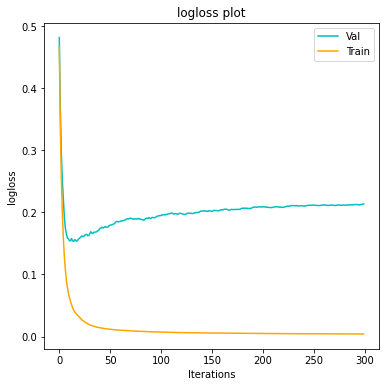

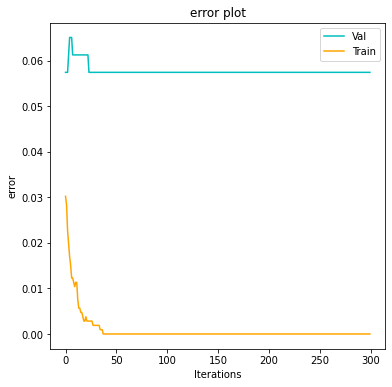

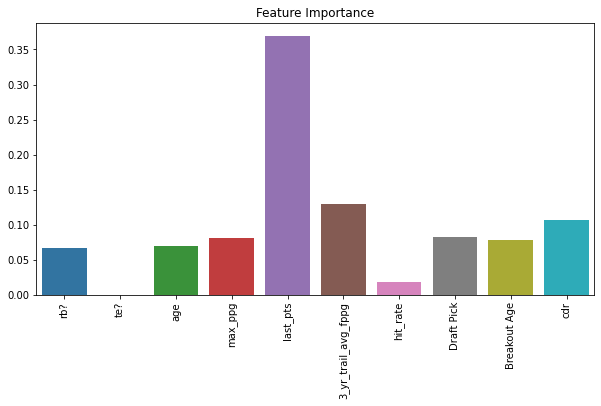

In [63]:
fitXgb(xgb1, training_data)

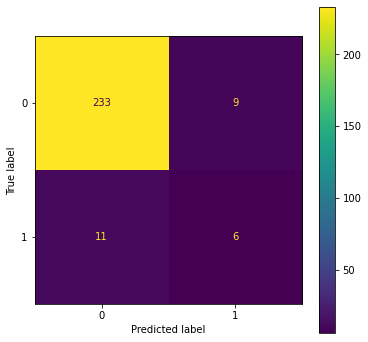

In [64]:
plot_confusion_matrix(xgb1,X_test,
                     Y_test,
                     values_format='d')

In [65]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [66]:
eval_set = [(X_val, Y_val)]

In [67]:
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_grid,scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, Y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.61368
[1]	validation_0-logloss:0.54903
[2]	validation_0-logloss:0.49603
[3]	validation_0-logloss:0.45107
[4]	validation_0-logloss:0.41368
[5]	validation_0-logloss:0.38031
[6]	validation_0-logloss:0.35313
[7]	validation_0-logloss:0.32928
[8]	validation_0-logloss:0.30923
[9]	validation_0-logloss:0.29150
[10]	validation_0-logloss:0.27474
[11]	validation_0-logloss:0.25999
[12]	validation_0-logloss:0.24848
[13]	validation_0-logloss:0.23615
[14]	validation_0-logloss:0.22631
[15]	validation_0-logloss:0.21819
[16]	validation_0-logloss:0.21027
[17]	validation_0-logloss:0.20317
[18]	validation_0-logloss:0.19598
[19]	validation_0-logloss:0.19069
[20]	validation_0-logloss:0.18641
[21]	validation_0-logloss:0.18212
[22]	validation_0-logloss:0.17902
[23]	validation_0-logloss:0.17565
[24]	validation_0-logloss:0.17116
[25]	validation_0-logloss:0.16832
[26]	validation_0-logloss:0.16600
[27]	validation_0-logloss:0.1

[54]	validation_0-logloss:0.17155
[29]	validation_0-logloss:0.18433
[45]	validation_0-logloss:0.13952
[55]	validation_0-logloss:0.17173
[30]	validation_0-logloss:0.18264
[46]	validation_0-logloss:0.13896
[31]	validation_0-logloss:0.18027
[47]	validation_0-logloss:0.13892
[32]	validation_0-logloss:0.17917
[0]	validation_0-logloss:0.61894
[26]	validation_0-logloss:0.17586
[1]	validation_0-logloss:0.55798
[27]	validation_0-logloss:0.17443
[2]	validation_0-logloss:0.50770
[28]	validation_0-logloss:0.17284
[3]	validation_0-logloss:0.46469
[29]	validation_0-logloss:0.17054
[10]	validation_0-logloss:0.30176
[25]	validation_0-logloss:0.17761
[11]	validation_0-logloss:0.28787
[26]	validation_0-logloss:0.17423
[30]	validation_0-logloss:0.16770
[12]	validation_0-logloss:0.27442
[27]	validation_0-logloss:0.17110
[13]	validation_0-logloss:0.26566
[36]	validation_0-logloss:0.15282
[28]	validation_0-logloss:0.16979
[14]	validation_0-logloss:0.25438
[37]	validation_0-logloss:0.15329
[29]	validation_0-

[61]	validation_0-logloss:0.17036
[50]	validation_0-logloss:0.15145
[8]	validation_0-logloss:0.30901
[63]	validation_0-logloss:0.15709
[62]	validation_0-logloss:0.17094
[51]	validation_0-logloss:0.15087
[64]	validation_0-logloss:0.15856
[39]	validation_0-logloss:0.17949
[52]	validation_0-logloss:0.15040
[56]	validation_0-logloss:0.16022
[65]	validation_0-logloss:0.15992
[40]	validation_0-logloss:0.17977
[53]	validation_0-logloss:0.15045
[57]	validation_0-logloss:0.15961
[66]	validation_0-logloss:0.16050
[58]	validation_0-logloss:0.15942
[41]	validation_0-logloss:0.17803
[54]	validation_0-logloss:0.14981
[55]	validation_0-logloss:0.14989
[67]	validation_0-logloss:0.16076
[59]	validation_0-logloss:0.15969
[42]	validation_0-logloss:0.17833
[60]	validation_0-logloss:0.15897
[68]	validation_0-logloss:0.16154
[43]	validation_0-logloss:0.17723
[61]	validation_0-logloss:0.15858
[69]	validation_0-logloss:0.16150
[80]	validation_0-logloss:0.14923
[44]	validation_0-logloss:0.17681
[62]	validation

[90]	validation_0-logloss:0.16708
[85]	validation_0-logloss:0.14914
[57]	validation_0-logloss:0.17269
[86]	validation_0-logloss:0.14877
[58]	validation_0-logloss:0.17299
[59]	validation_0-logloss:0.17262
[60]	validation_0-logloss:0.17264
[61]	validation_0-logloss:0.17338
[62]	validation_0-logloss:0.17296
[6]	validation_0-logloss:0.35053
[91]	validation_0-logloss:0.16827
[7]	validation_0-logloss:0.32669
[8]	validation_0-logloss:0.30540
[92]	validation_0-logloss:0.16794
[93]	validation_0-logloss:0.16812
[94]	validation_0-logloss:0.16912
[95]	validation_0-logloss:0.16784
[9]	validation_0-logloss:0.28665
[87]	validation_0-logloss:0.14897
[10]	validation_0-logloss:0.27004
[88]	validation_0-logloss:0.15101
[11]	validation_0-logloss:0.25507
[89]	validation_0-logloss:0.15117
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.61847
[12]	validation_0-logloss:0.24258
[90]	validation_0-logloss:0.15098
[13]	validation_0-

[21]	validation_0-logloss:0.19057
[14]	validation_0-logloss:0.24111
[21]	validation_0-logloss:0.21030
[47]	validation_0-logloss:0.17394
[59]	validation_0-logloss:0.15270
[15]	validation_0-logloss:0.23278
[36]	validation_0-logloss:0.16051
[16]	validation_0-logloss:0.22542
[60]	validation_0-logloss:0.15319
[75]	validation_0-logloss:0.13892
[61]	validation_0-logloss:0.15336
[48]	validation_0-logloss:0.17404
[76]	validation_0-logloss:0.13929
[62]	validation_0-logloss:0.15353
[22]	validation_0-logloss:0.20582
[77]	validation_0-logloss:0.13920
[37]	validation_0-logloss:0.15960
[49]	validation_0-logloss:0.17368
[38]	validation_0-logloss:0.15910
[78]	validation_0-logloss:0.14017
[23]	validation_0-logloss:0.20196
[39]	validation_0-logloss:0.15785
[24]	validation_0-logloss:0.19717
[40]	validation_0-logloss:0.15692
[79]	validation_0-logloss:0.13990
[25]	validation_0-logloss:0.19303
[50]	validation_0-logloss:0.17362
[80]	validation_0-logloss:0.13999
[26]	validation_0-logloss:0.18964
[63]	validatio

[0]	validation_0-logloss:0.61923
[74]	validation_0-logloss:0.15815
[1]	validation_0-logloss:0.55783
[75]	validation_0-logloss:0.15778
[64]	validation_0-logloss:0.15929
[2]	validation_0-logloss:0.50679
[65]	validation_0-logloss:0.15992
[84]	validation_0-logloss:0.16453
[66]	validation_0-logloss:0.15955
[48]	validation_0-logloss:0.17046
[85]	validation_0-logloss:0.16465
[67]	validation_0-logloss:0.15890
[49]	validation_0-logloss:0.17077
[96]	validation_0-logloss:0.16699
[86]	validation_0-logloss:0.16456
[71]	validation_0-logloss:0.16554
[50]	validation_0-logloss:0.17045
[97]	validation_0-logloss:0.16682
[72]	validation_0-logloss:0.16571
[87]	validation_0-logloss:0.16452
[51]	validation_0-logloss:0.17011
[98]	validation_0-logloss:0.16683
[88]	validation_0-logloss:0.16499
[73]	validation_0-logloss:0.16570
[52]	validation_0-logloss:0.16981
[76]	validation_0-logloss:0.15701
[99]	validation_0-logloss:0.16745
[74]	validation_0-logloss:0.16693
[82]	validation_0-logloss:0.14020
[3]	validation_0-

[99]	validation_0-logloss:0.16546
[3]	validation_0-logloss:0.48387
[18]	validation_0-logloss:0.22527
[4]	validation_0-logloss:0.44939
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-logloss:0.61471
[20]	validation_0-logloss:0.21055
[5]	validation_0-logloss:0.41939
[21]	validation_0-logloss:0.20617
[6]	validation_0-logloss:0.39341
[1]	validation_0-logloss:0.54965
[22]	validation_0-logloss:0.20104
[2]	validation_0-logloss:0.49723
[22]	validation_0-logloss:0.20307
[7]	validation_0-logloss:0.37026
[3]	validation_0-logloss:0.45206
[56]	validation_0-logloss:0.13786
[57]	validation_0-logloss:0.13807
[4]	validation_0-logloss:0.41315
[58]	validation_0-logloss:0.13767
[8]	validation_0-logloss:0.34995
[5]	validation_0-logloss:0.38136
[9]	validation_0-logloss:0.33315
[6]	validation_0-logloss:0.35315
[10]	validation_0-logloss:0.31824
[59]	validation_0-logloss:0.13749
[7]	validation_0-logloss:0.32915
[10]	validation_0-logloss

[62]	validation_0-logloss:0.16833
[84]	validation_0-logloss:0.13513
[24]	validation_0-logloss:0.18893
[48]	validation_0-logloss:0.16123
[63]	validation_0-logloss:0.16816
[25]	validation_0-logloss:0.18683
[64]	validation_0-logloss:0.16832
[49]	validation_0-logloss:0.16280
[26]	validation_0-logloss:0.18484
[65]	validation_0-logloss:0.16757
[50]	validation_0-logloss:0.16244
[27]	validation_0-logloss:0.18247
[66]	validation_0-logloss:0.16765
[51]	validation_0-logloss:0.16267
[67]	validation_0-logloss:0.16778
[28]	validation_0-logloss:0.18127
[80]	validation_0-logloss:0.15965
[29]	validation_0-logloss:0.17952
[52]	validation_0-logloss:0.16349
[81]	validation_0-logloss:0.15976
[30]	validation_0-logloss:0.17847
[31]	validation_0-logloss:0.17786
[69]	validation_0-logloss:0.15061
[82]	validation_0-logloss:0.15940
[53]	validation_0-logloss:0.16332
[70]	validation_0-logloss:0.14997
[83]	validation_0-logloss:0.15920
[54]	validation_0-logloss:0.16351
[84]	validation_0-logloss:0.15949
[94]	validatio

[6]	validation_0-logloss:0.36094
[7]	validation_0-logloss:0.33525
[27]	validation_0-logloss:0.16509
[3]	validation_0-logloss:0.45700
[28]	validation_0-logloss:0.16373
[4]	validation_0-logloss:0.42110
[29]	validation_0-logloss:0.16191
[30]	validation_0-logloss:0.15979
[5]	validation_0-logloss:0.39016
[31]	validation_0-logloss:0.15789
[6]	validation_0-logloss:0.36353
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-logloss:0.61514
[64]	validation_0-logloss:0.18481
[1]	validation_0-logloss:0.55306
[65]	validation_0-logloss:0.18493
[2]	validation_0-logloss:0.49869
[66]	validation_0-logloss:0.18528
[8]	validation_0-logloss:0.31297
[67]	validation_0-logloss:0.18669
[3]	validation_0-logloss:0.45498
[93]	validation_0-logloss:0.18654
[68]	validation_0-logloss:0.18841
[9]	validation_0-logloss:0.29224
[94]	validation_0-logloss:0.18744
[4]	validation_0-logloss:0.41698
[69]	validation_0-logloss:0.18941
[95]	validation_0-loglo

[34]	validation_0-logloss:0.18420
[69]	validation_0-logloss:0.15422
[16]	validation_0-logloss:0.22444
[18]	validation_0-logloss:0.21216
[35]	validation_0-logloss:0.18348
[41]	validation_0-logloss:0.16914
[36]	validation_0-logloss:0.18224
[33]	validation_0-logloss:0.16904
[19]	validation_0-logloss:0.20801
[42]	validation_0-logloss:0.16986
[23]	validation_0-logloss:0.19152
[20]	validation_0-logloss:0.20244
[21]	validation_0-logloss:0.19898
[24]	validation_0-logloss:0.18763
[43]	validation_0-logloss:0.16855
[22]	validation_0-logloss:0.19599
[23]	validation_0-logloss:0.19447
[25]	validation_0-logloss:0.18414
[44]	validation_0-logloss:0.17042
[24]	validation_0-logloss:0.19233
[45]	validation_0-logloss:0.17006
[25]	validation_0-logloss:0.19231
[46]	validation_0-logloss:0.17054
[26]	validation_0-logloss:0.18241
[47]	validation_0-logloss:0.17215
[26]	validation_0-logloss:0.19023
[48]	validation_0-logloss:0.17180
[27]	validation_0-logloss:0.18048
[37]	validation_0-logloss:0.18112
[27]	validatio

[79]	validation_0-logloss:0.15269
[78]	validation_0-logloss:0.18823
[80]	validation_0-logloss:0.15404
[81]	validation_0-logloss:0.15310
[79]	validation_0-logloss:0.18768
[57]	validation_0-logloss:0.16653
[31]	validation_0-logloss:0.17916
[58]	validation_0-logloss:0.16658
[73]	validation_0-logloss:0.18442
[32]	validation_0-logloss:0.17763
[59]	validation_0-logloss:0.16728
[74]	validation_0-logloss:0.18574
[33]	validation_0-logloss:0.17631
[60]	validation_0-logloss:0.16768
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.61366
[61]	validation_0-logloss:0.16812
[1]	validation_0-logloss:0.54857
[34]	validation_0-logloss:0.17583
[62]	validation_0-logloss:0.16801
[75]	validation_0-logloss:0.18776
[35]	validation_0-logloss:0.17545
[63]	validation_0-logloss:0.16804
[2]	validation_0-logloss:0.49500
[76]	validation_0-logloss:0.18759
[64]	validation_0-logloss:0.16771
[77]	validation_0-logloss:0.18793
[94]	validation_

[27]	validation_0-logloss:0.16945
[13]	validation_0-logloss:0.24647
[15]	validation_0-logloss:0.23959
[30]	validation_0-logloss:0.19119
[66]	validation_0-logloss:0.14596
[17]	validation_0-logloss:0.21984
[31]	validation_0-logloss:0.18962
[67]	validation_0-logloss:0.14683
[32]	validation_0-logloss:0.18818
[18]	validation_0-logloss:0.21523
[68]	validation_0-logloss:0.14709
[33]	validation_0-logloss:0.18644
[69]	validation_0-logloss:0.14747
[19]	validation_0-logloss:0.21114
[34]	validation_0-logloss:0.18538
[70]	validation_0-logloss:0.14746
[20]	validation_0-logloss:0.20615
[35]	validation_0-logloss:0.18429
[71]	validation_0-logloss:0.14835
[36]	validation_0-logloss:0.18316
[37]	validation_0-logloss:0.18253
[38]	validation_0-logloss:0.18148
[72]	validation_0-logloss:0.14814
[73]	validation_0-logloss:0.14841
[38]	validation_0-logloss:0.16198
[74]	validation_0-logloss:0.14948
[75]	validation_0-logloss:0.14927
[99]	validation_0-logloss:0.18084
[39]	validation_0-logloss:0.16238
[40]	validatio

[56]	validation_0-logloss:0.15300
[18]	validation_0-logloss:0.20992
[19]	validation_0-logloss:0.20492
[57]	validation_0-logloss:0.15290
[20]	validation_0-logloss:0.20042
[55]	validation_0-logloss:0.17050
[3]	validation_0-logloss:0.46337
[58]	validation_0-logloss:0.15395
[4]	validation_0-logloss:0.42627
[74]	validation_0-logloss:0.17875
[56]	validation_0-logloss:0.16989
[5]	validation_0-logloss:0.39452
[75]	validation_0-logloss:0.17887
[64]	validation_0-logloss:0.14098
[57]	validation_0-logloss:0.16979
[76]	validation_0-logloss:0.17903
[77]	validation_0-logloss:0.17926
[65]	validation_0-logloss:0.14090
[6]	validation_0-logloss:0.36685
[78]	validation_0-logloss:0.18002
[7]	validation_0-logloss:0.34241
[8]	validation_0-logloss:0.32100
[79]	validation_0-logloss:0.17875
[66]	validation_0-logloss:0.14087
[80]	validation_0-logloss:0.17904
[9]	validation_0-logloss:0.30330
[67]	validation_0-logloss:0.14088
[81]	validation_0-logloss:0.17964
[68]	validation_0-logloss:0.14149
[82]	validation_0-log

[75]	validation_0-logloss:0.15075
[86]	validation_0-logloss:0.18587
[98]	validation_0-logloss:0.14934
[87]	validation_0-logloss:0.17533
[92]	validation_0-logloss:0.16156
[76]	validation_0-logloss:0.15100
[99]	validation_0-logloss:0.14949
[88]	validation_0-logloss:0.17500
[93]	validation_0-logloss:0.16015
[89]	validation_0-logloss:0.17521
[94]	validation_0-logloss:0.16110
[90]	validation_0-logloss:0.17532
[95]	validation_0-logloss:0.16181
[9]	validation_0-logloss:0.31145
[51]	validation_0-logloss:0.16675
[91]	validation_0-logloss:0.17524
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.62153
[10]	validation_0-logloss:0.29495
[52]	validation_0-logloss:0.16676
[1]	validation_0-logloss:0.56235
[11]	validation_0-logloss:0.28112
[53]	validation_0-logloss:0.16648
[87]	validation_0-logloss:0.18731
[2]	validation_0-logloss:0.51196
[54]	validation_0-logloss:0.16629
[12]	validation_0-logloss:0.26828
[88]	validation

[17]	validation_0-logloss:0.23886
[26]	validation_0-logloss:0.17426
[42]	validation_0-logloss:0.15977
[18]	validation_0-logloss:0.23326
[72]	validation_0-logloss:0.13993
[17]	validation_0-logloss:0.23218
[27]	validation_0-logloss:0.17065
[43]	validation_0-logloss:0.15967
[18]	validation_0-logloss:0.22636
[73]	validation_0-logloss:0.14006
[44]	validation_0-logloss:0.15912
[28]	validation_0-logloss:0.16833
[45]	validation_0-logloss:0.15867
[2]	validation_0-logloss:0.49682
[74]	validation_0-logloss:0.14035
[29]	validation_0-logloss:0.16530
[30]	validation_0-logloss:0.16272
[3]	validation_0-logloss:0.45123
[75]	validation_0-logloss:0.14048
[90]	validation_0-logloss:0.16548
[31]	validation_0-logloss:0.16041
[38]	validation_0-logloss:0.16655
[91]	validation_0-logloss:0.16563
[76]	validation_0-logloss:0.14062
[32]	validation_0-logloss:0.15871
[39]	validation_0-logloss:0.16628
[92]	validation_0-logloss:0.16542
[33]	validation_0-logloss:0.15704
[77]	validation_0-logloss:0.13964
[40]	validation_

[36]	validation_0-logloss:0.18247
[83]	validation_0-logloss:0.16279
[81]	validation_0-logloss:0.15506
[97]	validation_0-logloss:0.15494
[47]	validation_0-logloss:0.17233
[66]	validation_0-logloss:0.14664
[98]	validation_0-logloss:0.15528
[48]	validation_0-logloss:0.17193
[67]	validation_0-logloss:0.14595
[90]	validation_0-logloss:0.15464
[49]	validation_0-logloss:0.17204
[81]	validation_0-logloss:0.12890
[91]	validation_0-logloss:0.15449
[50]	validation_0-logloss:0.17221
[82]	validation_0-logloss:0.12868
[92]	validation_0-logloss:0.15482
[51]	validation_0-logloss:0.17291
[83]	validation_0-logloss:0.12860
[93]	validation_0-logloss:0.15467
[2]	validation_0-logloss:0.49468
[84]	validation_0-logloss:0.12840
[94]	validation_0-logloss:0.15457
[3]	validation_0-logloss:0.44974
[85]	validation_0-logloss:0.12760
[4]	validation_0-logloss:0.41175
[95]	validation_0-logloss:0.15461
[99]	validation_0-logloss:0.15495
[5]	validation_0-logloss:0.38030
[96]	validation_0-logloss:0.15446
[68]	validation_0-

[15]	validation_0-logloss:0.22540
[62]	validation_0-logloss:0.15303
[29]	validation_0-logloss:0.18723
[16]	validation_0-logloss:0.21609
[63]	validation_0-logloss:0.15301
[6]	validation_0-logloss:0.35482
[64]	validation_0-logloss:0.15404
[25]	validation_0-logloss:0.18811
[30]	validation_0-logloss:0.18695
[31]	validation_0-logloss:0.18647
[7]	validation_0-logloss:0.33110
[26]	validation_0-logloss:0.18566
[14]	validation_0-logloss:0.23765
[8]	validation_0-logloss:0.30995
[32]	validation_0-logloss:0.18706
[15]	validation_0-logloss:0.23162
[27]	validation_0-logloss:0.18460
[9]	validation_0-logloss:0.29032
[16]	validation_0-logloss:0.22562
[20]	validation_0-logloss:0.19614
[66]	validation_0-logloss:0.16279
[28]	validation_0-logloss:0.18379
[10]	validation_0-logloss:0.27451
[21]	validation_0-logloss:0.19376
[29]	validation_0-logloss:0.18407
[11]	validation_0-logloss:0.26078
[67]	validation_0-logloss:0.16217
[22]	validation_0-logloss:0.19172
[30]	validation_0-logloss:0.18264
[65]	validation_0-

[62]	validation_0-logloss:0.19711
[42]	validation_0-logloss:0.18189
[48]	validation_0-logloss:0.17170
[5]	validation_0-logloss:0.38205
[49]	validation_0-logloss:0.17149
[43]	validation_0-logloss:0.18255
[6]	validation_0-logloss:0.35387
[7]	validation_0-logloss:0.32980
[44]	validation_0-logloss:0.18299
[50]	validation_0-logloss:0.17114
[63]	validation_0-logloss:0.19760
[45]	validation_0-logloss:0.18477
[64]	validation_0-logloss:0.19873
[46]	validation_0-logloss:0.18523
[47]	validation_0-logloss:0.18500
[48]	validation_0-logloss:0.18688
[49]	validation_0-logloss:0.18774
[50]	validation_0-logloss:0.18757
[65]	validation_0-logloss:0.19969
[59]	validation_0-logloss:0.18197
[27]	validation_0-logloss:0.17074
[60]	validation_0-logloss:0.18173
[66]	validation_0-logloss:0.20017
[37]	validation_0-logloss:0.16325
[28]	validation_0-logloss:0.16853
[61]	validation_0-logloss:0.18352
[38]	validation_0-logloss:0.16410
[62]	validation_0-logloss:0.18499
[29]	validation_0-logloss:0.16723
[63]	validation_0

[77]	validation_0-logloss:0.19751
[84]	validation_0-logloss:0.17891
[31]	validation_0-logloss:0.18143
[90]	validation_0-logloss:0.19804
[20]	validation_0-logloss:0.18619
[48]	validation_0-logloss:0.16277
[91]	validation_0-logloss:0.19798
[78]	validation_0-logloss:0.19816
[21]	validation_0-logloss:0.18201
[92]	validation_0-logloss:0.19871
[49]	validation_0-logloss:0.16313
[60]	validation_0-logloss:0.16241
[95]	validation_0-logloss:0.21385
[93]	validation_0-logloss:0.19910
[22]	validation_0-logloss:0.17867
[69]	validation_0-logloss:0.19574
[11]	validation_0-logloss:0.26513
[96]	validation_0-logloss:0.21441
[23]	validation_0-logloss:0.17553
[50]	validation_0-logloss:0.16375
[97]	validation_0-logloss:0.21467
[51]	validation_0-logloss:0.16424
[98]	validation_0-logloss:0.21506
[85]	validation_0-logloss:0.17933
[99]	validation_0-logloss:0.21491
[86]	validation_0-logloss:0.17874
[12]	validation_0-logloss:0.25294
[52]	validation_0-logloss:0.16433
[87]	validation_0-logloss:0.17857
[24]	validatio

[83]	validation_0-logloss:0.18591
[84]	validation_0-logloss:0.18641
[8]	validation_0-logloss:0.31720
[5]	validation_0-logloss:0.38586
[85]	validation_0-logloss:0.18715
[6]	validation_0-logloss:0.35843
[22]	validation_0-logloss:0.20222
[86]	validation_0-logloss:0.18725
[7]	validation_0-logloss:0.33486
[52]	validation_0-logloss:0.17403
[23]	validation_0-logloss:0.19862
[87]	validation_0-logloss:0.18733
[16]	validation_0-logloss:0.20864
[53]	validation_0-logloss:0.17544
[70]	validation_0-logloss:0.16114
[17]	validation_0-logloss:0.20171
[24]	validation_0-logloss:0.19546
[71]	validation_0-logloss:0.16179
[54]	validation_0-logloss:0.17543
[18]	validation_0-logloss:0.19609
[72]	validation_0-logloss:0.16163
[25]	validation_0-logloss:0.19281
[19]	validation_0-logloss:0.19059
[55]	validation_0-logloss:0.17615
[73]	validation_0-logloss:0.16176
[74]	validation_0-logloss:0.16191
[56]	validation_0-logloss:0.17716
[26]	validation_0-logloss:0.19072
[57]	validation_0-logloss:0.17792
[27]	validation_0-

[6]	validation_0-logloss:0.63919
[38]	validation_0-logloss:0.47024
[2]	validation_0-logloss:0.66867
[39]	validation_0-logloss:0.46631
[78]	validation_0-logloss:0.34214
[79]	validation_0-logloss:0.33993
[80]	validation_0-logloss:0.33739
[81]	validation_0-logloss:0.33520
[50]	validation_0-logloss:0.42219
[82]	validation_0-logloss:0.33280
[51]	validation_0-logloss:0.41885
[83]	validation_0-logloss:0.33060
[52]	validation_0-logloss:0.41544
[84]	validation_0-logloss:0.32843
[85]	validation_0-logloss:0.32630
[53]	validation_0-logloss:0.41210
[69]	validation_0-logloss:0.37160
[86]	validation_0-logloss:0.32431
[87]	validation_0-logloss:0.32223
[88]	validation_0-logloss:0.32030
[70]	validation_0-logloss:0.36899
[89]	validation_0-logloss:0.31820
[54]	validation_0-logloss:0.40885
[71]	validation_0-logloss:0.36644
[72]	validation_0-logloss:0.36412
[55]	validation_0-logloss:0.40566
[19]	validation_0-logloss:0.55471
[73]	validation_0-logloss:0.36176
[56]	validation_0-logloss:0.40252
[57]	validation_

[61]	validation_0-logloss:0.38096
[54]	validation_0-logloss:0.40479
[95]	validation_0-logloss:0.30908
[96]	validation_0-logloss:0.30726
[6]	validation_0-logloss:0.64153
[97]	validation_0-logloss:0.30546
[30]	validation_0-logloss:0.50607
[31]	validation_0-logloss:0.50153
[60]	validation_0-logloss:0.40083
[7]	validation_0-logloss:0.63469
[32]	validation_0-logloss:0.49705
[8]	validation_0-logloss:0.62800
[61]	validation_0-logloss:0.39790
[33]	validation_0-logloss:0.49257
[78]	validation_0-logloss:0.34547
[9]	validation_0-logloss:0.62141
[62]	validation_0-logloss:0.39507
[10]	validation_0-logloss:0.61497
[57]	validation_0-logloss:0.41120
[79]	validation_0-logloss:0.34310
[63]	validation_0-logloss:0.39223
[62]	validation_0-logloss:0.37800
[80]	validation_0-logloss:0.34068
[58]	validation_0-logloss:0.40817
[63]	validation_0-logloss:0.37510
[81]	validation_0-logloss:0.33853
[59]	validation_0-logloss:0.40539
[64]	validation_0-logloss:0.37223
[98]	validation_0-logloss:0.30359
[82]	validation_0-

[5]	validation_0-logloss:0.64900
[99]	validation_0-logloss:0.31942
[71]	validation_0-logloss:0.36268
[6]	validation_0-logloss:0.64181
[72]	validation_0-logloss:0.36017
[7]	validation_0-logloss:0.63516
[92]	validation_0-logloss:0.30372
[8]	validation_0-logloss:0.62823
[9]	validation_0-logloss:0.62143
[93]	validation_0-logloss:0.30178
[94]	validation_0-logloss:0.29986
[95]	validation_0-logloss:0.29794
[96]	validation_0-logloss:0.29607
[92]	validation_0-logloss:0.30698
[52]	validation_0-logloss:0.41882
[56]	validation_0-logloss:0.40733
[53]	validation_0-logloss:0.41549
[57]	validation_0-logloss:0.40424
[54]	validation_0-logloss:0.41228
[58]	validation_0-logloss:0.40121
[55]	validation_0-logloss:0.40901
[73]	validation_0-logloss:0.35749
[59]	validation_0-logloss:0.39839
[56]	validation_0-logloss:0.40585
[74]	validation_0-logloss:0.35502
[60]	validation_0-logloss:0.39553
[10]	validation_0-logloss:0.61475
[75]	validation_0-logloss:0.35235
[61]	validation_0-logloss:0.39264
[11]	validation_0-l

[14]	validation_0-logloss:0.59017
[15]	validation_0-logloss:0.58427
[53]	validation_0-logloss:0.41748
[16]	validation_0-logloss:0.57851
[54]	validation_0-logloss:0.41415
[31]	validation_0-logloss:0.50597
[55]	validation_0-logloss:0.41078
[32]	validation_0-logloss:0.50162
[33]	validation_0-logloss:0.49741
[56]	validation_0-logloss:0.40771
[34]	validation_0-logloss:0.49312
[57]	validation_0-logloss:0.40453
[5]	validation_0-logloss:0.65124
[6]	validation_0-logloss:0.64471
[9]	validation_0-logloss:0.62193
[7]	validation_0-logloss:0.63826
[10]	validation_0-logloss:0.61546
[8]	validation_0-logloss:0.63189
[9]	validation_0-logloss:0.62570
[11]	validation_0-logloss:0.60911
[10]	validation_0-logloss:0.61951
[12]	validation_0-logloss:0.60287
[11]	validation_0-logloss:0.61353
[13]	validation_0-logloss:0.59675
[12]	validation_0-logloss:0.60758
[13]	validation_0-logloss:0.60158
[14]	validation_0-logloss:0.59569
[18]	validation_0-logloss:0.56757
[19]	validation_0-logloss:0.56205
[20]	validation_0-lo

[58]	validation_0-logloss:0.40272
[36]	validation_0-logloss:0.48756
[59]	validation_0-logloss:0.39964
[60]	validation_0-logloss:0.39671
[20]	validation_0-logloss:0.56535
[61]	validation_0-logloss:0.39371
[62]	validation_0-logloss:0.39086
[63]	validation_0-logloss:0.38795
[64]	validation_0-logloss:0.38519
[65]	validation_0-logloss:0.38235
[61]	validation_0-logloss:0.39409
[78]	validation_0-logloss:0.35953
[62]	validation_0-logloss:0.39121
[79]	validation_0-logloss:0.35746
[54]	validation_0-logloss:0.42507
[63]	validation_0-logloss:0.38836
[80]	validation_0-logloss:0.35531
[64]	validation_0-logloss:0.38551
[81]	validation_0-logloss:0.35328
[55]	validation_0-logloss:0.42188
[13]	validation_0-logloss:0.60274
[65]	validation_0-logloss:0.38281
[82]	validation_0-logloss:0.35120
[56]	validation_0-logloss:0.41877
[14]	validation_0-logloss:0.59712
[76]	validation_0-logloss:0.36335
[57]	validation_0-logloss:0.41569
[15]	validation_0-logloss:0.59155
[66]	validation_0-logloss:0.38023
[77]	validatio

[97]	validation_0-logloss:0.32113
[15]	validation_0-logloss:0.59519
[98]	validation_0-logloss:0.31940
[9]	validation_0-logloss:0.61740
[99]	validation_0-logloss:0.31764
[10]	validation_0-logloss:0.61060
[80]	validation_0-logloss:0.35459
[81]	validation_0-logloss:0.35246
[82]	validation_0-logloss:0.35034
[83]	validation_0-logloss:0.34819
[11]	validation_0-logloss:0.60388
[84]	validation_0-logloss:0.34609
[1]	validation_0-logloss:0.67631
[12]	validation_0-logloss:0.59728
[2]	validation_0-logloss:0.66854
[2]	validation_0-logloss:0.66816
[69]	validation_0-logloss:0.38867
[3]	validation_0-logloss:0.66070
[3]	validation_0-logloss:0.66020
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.68498
[4]	validation_0-logloss:0.65297
[4]	validation_0-logloss:0.65240
[70]	validation_0-logloss:0.38618
[62]	validation_0-logloss:0.40686
[16]	validation_0-logloss:0.58991
[1]	validation_0-logloss:0.67701
[71]	validation_0-l

[79]	validation_0-logloss:0.36471
[60]	validation_0-logloss:0.42175
[39]	validation_0-logloss:0.45304
[61]	validation_0-logloss:0.41902
[40]	validation_0-logloss:0.44889
[41]	validation_0-logloss:0.44494
[34]	validation_0-logloss:0.48218
[35]	validation_0-logloss:0.47784
[36]	validation_0-logloss:0.47356
[37]	validation_0-logloss:0.46959
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.68517
[5]	validation_0-logloss:0.64683
[38]	validation_0-logloss:0.45805
[1]	validation_0-logloss:0.67738
[6]	validation_0-logloss:0.63977
[2]	validation_0-logloss:0.66978
[39]	validation_0-logloss:0.45392
[7]	validation_0-logloss:0.63265
[3]	validation_0-logloss:0.66230
[8]	validation_0-logloss:0.62567
[40]	validation_0-logloss:0.44992
[4]	validation_0-logloss:0.65498
[41]	validation_0-logloss:0.44576
[49]	validation_0-logloss:0.42017
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5

[80]	validation_0-logloss:0.32681
[38]	validation_0-logloss:0.46768
[65]	validation_0-logloss:0.38088
[86]	validation_0-logloss:0.32010
[81]	validation_0-logloss:0.32457
[66]	validation_0-logloss:0.37833
[87]	validation_0-logloss:0.31797
[77]	validation_0-logloss:0.33600
[82]	validation_0-logloss:0.32221
[67]	validation_0-logloss:0.37571
[78]	validation_0-logloss:0.33363
[68]	validation_0-logloss:0.37316
[79]	validation_0-logloss:0.33129
[83]	validation_0-logloss:0.32006
[80]	validation_0-logloss:0.32898
[32]	validation_0-logloss:0.49288
[33]	validation_0-logloss:0.48840
[34]	validation_0-logloss:0.48386
[35]	validation_0-logloss:0.47936
[46]	validation_0-logloss:0.43511
[69]	validation_0-logloss:0.37072
[47]	validation_0-logloss:0.43160
[77]	validation_0-logloss:0.34318
[70]	validation_0-logloss:0.36824
[71]	validation_0-logloss:0.36583
[48]	validation_0-logloss:0.42804
[49]	validation_0-logloss:0.42435
[78]	validation_0-logloss:0.34075
[39]	validation_0-logloss:0.46369
[88]	validatio

[69]	validation_0-logloss:0.36292
[70]	validation_0-logloss:0.36020
[35]	validation_0-logloss:0.48120
[36]	validation_0-logloss:0.47699
[37]	validation_0-logloss:0.47276
[38]	validation_0-logloss:0.46866
[71]	validation_0-logloss:0.35737
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.68481
[72]	validation_0-logloss:0.35483
[86]	validation_0-logloss:0.32464
[1]	validation_0-logloss:0.67664
[73]	validation_0-logloss:0.35226
[2]	validation_0-logloss:0.66863
[87]	validation_0-logloss:0.32260
[21]	validation_0-logloss:0.54418
[22]	validation_0-logloss:0.53872
[77]	validation_0-logloss:0.35181
[88]	validation_0-logloss:0.32055
[23]	validation_0-logloss:0.53342
[78]	validation_0-logloss:0.34953
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.68493
[39]	validation_0-logloss:0.46464
[24]	validation_0-logloss:0.52809
[1]	validation

[75]	validation_0-logloss:0.35398
[40]	validation_0-logloss:0.45164
[40]	validation_0-logloss:0.45247
[41]	validation_0-logloss:0.44849
[42]	validation_0-logloss:0.44460
[76]	validation_0-logloss:0.35165
[43]	validation_0-logloss:0.44078
[77]	validation_0-logloss:0.34929
[41]	validation_0-logloss:0.44757
[42]	validation_0-logloss:0.44358
[43]	validation_0-logloss:0.43962
[60]	validation_0-logloss:0.38470
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.1s
[0]	validation_0-logloss:0.68531
[61]	validation_0-logloss:0.38182
[1]	validation_0-logloss:0.67750
[33]	validation_0-logloss:0.48995
[62]	validation_0-logloss:0.37896
[34]	validation_0-logloss:0.48557
[2]	validation_0-logloss:0.66998
[63]	validation_0-logloss:0.37609
[35]	validation_0-logloss:0.48127
[3]	validation_0-logloss:0.66261
[36]	validation_0-logloss:0.47718
[64]	validation_0-logloss:0.37334
[78]	validation_0-logloss:0.34699
[65]	validation_0-logloss:0.37060
[79]	validation_

[61]	validation_0-logloss:0.39071
[39]	validation_0-logloss:0.46622
[40]	validation_0-logloss:0.46209
[24]	validation_0-logloss:0.53734
[82]	validation_0-logloss:0.32345
[41]	validation_0-logloss:0.45806
[83]	validation_0-logloss:0.32128
[42]	validation_0-logloss:0.45418
[25]	validation_0-logloss:0.53253
[26]	validation_0-logloss:0.52762
[84]	validation_0-logloss:0.31909
[85]	validation_0-logloss:0.31699
[82]	validation_0-logloss:0.32626
[74]	validation_0-logloss:0.35615
[76]	validation_0-logloss:0.34967
[83]	validation_0-logloss:0.32406
[31]	validation_0-logloss:0.50074
[84]	validation_0-logloss:0.32185
[32]	validation_0-logloss:0.49634
[75]	validation_0-logloss:0.35389
[85]	validation_0-logloss:0.31980
[33]	validation_0-logloss:0.49179
[77]	validation_0-logloss:0.34720
[76]	validation_0-logloss:0.35173
[78]	validation_0-logloss:0.34480
[62]	validation_0-logloss:0.38787
[79]	validation_0-logloss:0.34239
[77]	validation_0-logloss:0.34955
[63]	validation_0-logloss:0.38499
[78]	validatio

[69]	validation_0-logloss:0.37210
[13]	validation_0-logloss:0.59615
[80]	validation_0-logloss:0.34055
[70]	validation_0-logloss:0.36969
[71]	validation_0-logloss:0.36731
[72]	validation_0-logloss:0.36492
[14]	validation_0-logloss:0.59010
[81]	validation_0-logloss:0.33844
[82]	validation_0-logloss:0.33620
[83]	validation_0-logloss:0.33393
[84]	validation_0-logloss:0.33189
[35]	validation_0-logloss:0.48537
[85]	validation_0-logloss:0.32989
[86]	validation_0-logloss:0.32791
[36]	validation_0-logloss:0.48122
[87]	validation_0-logloss:0.32586
[37]	validation_0-logloss:0.47710
[38]	validation_0-logloss:0.47304
[15]	validation_0-logloss:0.58415
[16]	validation_0-logloss:0.57838
[17]	validation_0-logloss:0.57267
[18]	validation_0-logloss:0.56707
[19]	validation_0-logloss:0.56154
[68]	validation_0-logloss:0.37657
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.68580
[69]	validation_0-logloss:0.37400
[20]	valida

[35]	validation_0-logloss:0.49278
[31]	validation_0-logloss:0.50773
[47]	validation_0-logloss:0.43869
[32]	validation_0-logloss:0.50332
[36]	validation_0-logloss:0.48868
[48]	validation_0-logloss:0.43519
[33]	validation_0-logloss:0.49898
[62]	validation_0-logloss:0.39034
[34]	validation_0-logloss:0.49471
[63]	validation_0-logloss:0.38748
[37]	validation_0-logloss:0.48463
[38]	validation_0-logloss:0.48066
[29]	validation_0-logloss:0.52274
[64]	validation_0-logloss:0.38462
[39]	validation_0-logloss:0.47680
[30]	validation_0-logloss:0.51840
[40]	validation_0-logloss:0.47287
[16]	validation_0-logloss:0.58521
[41]	validation_0-logloss:0.46906
[31]	validation_0-logloss:0.51400
[42]	validation_0-logloss:0.46531
[17]	validation_0-logloss:0.57981
[18]	validation_0-logloss:0.57446
[32]	validation_0-logloss:0.50979
[65]	validation_0-logloss:0.38179
[66]	validation_0-logloss:0.37904
[67]	validation_0-logloss:0.37642
[79]	validation_0-logloss:0.34789
[80]	validation_0-logloss:0.34573
[49]	validatio

[25]	validation_0-logloss:0.54628
[74]	validation_0-logloss:0.36862
[26]	validation_0-logloss:0.54180
[18]	validation_0-logloss:0.55993
[27]	validation_0-logloss:0.53731
[19]	validation_0-logloss:0.55411
[54]	validation_0-logloss:0.42900
[55]	validation_0-logloss:0.42591
[36]	validation_0-logloss:0.49081
[56]	validation_0-logloss:0.42286
[75]	validation_0-logloss:0.36620
[37]	validation_0-logloss:0.48682
[74]	validation_0-logloss:0.36556
[76]	validation_0-logloss:0.36382
[73]	validation_0-logloss:0.37995
[38]	validation_0-logloss:0.48289
[74]	validation_0-logloss:0.37745
[77]	validation_0-logloss:0.36149
[75]	validation_0-logloss:0.37512
[39]	validation_0-logloss:0.47903
[76]	validation_0-logloss:0.37283
[75]	validation_0-logloss:0.36321
[40]	validation_0-logloss:0.47522
[20]	validation_0-logloss:0.54834
[76]	validation_0-logloss:0.36084
[28]	validation_0-logloss:0.53296
[77]	validation_0-logloss:0.35850
[78]	validation_0-logloss:0.35619
[79]	validation_0-logloss:0.35392
[29]	validatio

[83]	validation_0-logloss:0.35424
[5]	validation_0-logloss:0.64649
[26]	validation_0-logloss:0.51632
[6]	validation_0-logloss:0.63926
[7]	validation_0-logloss:0.63219
[27]	validation_0-logloss:0.51135
[54]	validation_0-logloss:0.40270
[28]	validation_0-logloss:0.50636
[55]	validation_0-logloss:0.39937
[29]	validation_0-logloss:0.50161
[56]	validation_0-logloss:0.39624
[91]	validation_0-logloss:0.33878
[27]	validation_0-logloss:0.51002
[92]	validation_0-logloss:0.33697
[93]	validation_0-logloss:0.33507
[69]	validation_0-logloss:0.39933
[28]	validation_0-logloss:0.50505
[16]	validation_0-logloss:0.57279
[70]	validation_0-logloss:0.39690
[29]	validation_0-logloss:0.50005
[84]	validation_0-logloss:0.35224
[71]	validation_0-logloss:0.39447
[30]	validation_0-logloss:0.49525
[17]	validation_0-logloss:0.56678
[31]	validation_0-logloss:0.49050
[85]	validation_0-logloss:0.35022
[72]	validation_0-logloss:0.39213
[86]	validation_0-logloss:0.34822
[18]	validation_0-logloss:0.56099
[32]	validation_0

[40]	validation_0-logloss:0.45939
[63]	validation_0-logloss:0.37616
[6]	validation_0-logloss:0.63931
[41]	validation_0-logloss:0.45548
[42]	validation_0-logloss:0.45149
[7]	validation_0-logloss:0.63215
[26]	validation_0-logloss:0.51849
[8]	validation_0-logloss:0.62496
[9]	validation_0-logloss:0.61806
[27]	validation_0-logloss:0.51363
[64]	validation_0-logloss:0.37332
[62]	validation_0-logloss:0.37646
[10]	validation_0-logloss:0.61139
[28]	validation_0-logloss:0.50876
[63]	validation_0-logloss:0.37349
[64]	validation_0-logloss:0.37077
[65]	validation_0-logloss:0.37043
[65]	validation_0-logloss:0.36806
[49]	validation_0-logloss:0.42184
[66]	validation_0-logloss:0.36529
[50]	validation_0-logloss:0.41848
[51]	validation_0-logloss:0.41518
[67]	validation_0-logloss:0.36253
[89]	validation_0-logloss:0.31452
[68]	validation_0-logloss:0.35997
[25]	validation_0-logloss:0.52371
[26]	validation_0-logloss:0.51864
[90]	validation_0-logloss:0.31246
[27]	validation_0-logloss:0.51345
[91]	validation_0-

[97]	validation_0-logloss:0.29648
[43]	validation_0-logloss:0.44349
[47]	validation_0-logloss:0.43185
[48]	validation_0-logloss:0.42848
[44]	validation_0-logloss:0.43977
[49]	validation_0-logloss:0.42523
[23]	validation_0-logloss:0.53311
[98]	validation_0-logloss:0.29474
[81]	validation_0-logloss:0.33540
[99]	validation_0-logloss:0.29302
[82]	validation_0-logloss:0.33325
[56]	validation_0-logloss:0.39753
[24]	validation_0-logloss:0.52787
[25]	validation_0-logloss:0.52271
[57]	validation_0-logloss:0.39429
[83]	validation_0-logloss:0.33098
[58]	validation_0-logloss:0.39124
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.68490
[1]	validation_0-logloss:0.67682
[76]	validation_0-logloss:0.35223
[2]	validation_0-logloss:0.66891
[77]	validation_0-logloss:0.35004
[3]	validation_0-logloss:0.66115
[26]	validation_0-logloss:0.51756
[78]	validation_0-logloss:0.34795
[27]	validation_0-logloss:0.51256
[79]	validation_

[80]	validation_0-logloss:0.34224
[16]	validation_0-logloss:0.57246
[75]	validation_0-logloss:0.34655
[81]	validation_0-logloss:0.34031
[82]	validation_0-logloss:0.33824
[35]	validation_0-logloss:0.47466
[76]	validation_0-logloss:0.34427
[36]	validation_0-logloss:0.47040
[13]	validation_0-logloss:0.59396
[37]	validation_0-logloss:0.46603
[14]	validation_0-logloss:0.58769
[38]	validation_0-logloss:0.46184
[91]	validation_0-logloss:0.31113
[15]	validation_0-logloss:0.58150
[59]	validation_0-logloss:0.38761
[92]	validation_0-logloss:0.30931
[60]	validation_0-logloss:0.38463
[17]	validation_0-logloss:0.56643
[93]	validation_0-logloss:0.30734
[61]	validation_0-logloss:0.38170
[18]	validation_0-logloss:0.56053
[19]	validation_0-logloss:0.55472
[77]	validation_0-logloss:0.34209
[20]	validation_0-logloss:0.54903
[78]	validation_0-logloss:0.33969
[83]	validation_0-logloss:0.33624
[39]	validation_0-logloss:0.45775
[79]	validation_0-logloss:0.33753
[84]	validation_0-logloss:0.33439
[16]	validatio

[5]	validation_0-logloss:0.64741
[25]	validation_0-logloss:0.52985
[36]	validation_0-logloss:0.47530
[6]	validation_0-logloss:0.64032
[7]	validation_0-logloss:0.63326
[37]	validation_0-logloss:0.47118
[8]	validation_0-logloss:0.62639
[38]	validation_0-logloss:0.46711
[26]	validation_0-logloss:0.52492
[55]	validation_0-logloss:0.39844
[27]	validation_0-logloss:0.52009
[56]	validation_0-logloss:0.39522
[57]	validation_0-logloss:0.39203
[58]	validation_0-logloss:0.38889
[11]	validation_0-logloss:0.60648
[73]	validation_0-logloss:0.34866
[93]	validation_0-logloss:0.30598
[12]	validation_0-logloss:0.60004
[94]	validation_0-logloss:0.30407
[74]	validation_0-logloss:0.34621
[13]	validation_0-logloss:0.59377
[95]	validation_0-logloss:0.30222
[49]	validation_0-logloss:0.42566
[75]	validation_0-logloss:0.34371
[96]	validation_0-logloss:0.30040
[50]	validation_0-logloss:0.42219
[39]	validation_0-logloss:0.46288
[51]	validation_0-logloss:0.41892
[40]	validation_0-logloss:0.45893
[52]	validation_0-

[93]	validation_0-logloss:0.30246
[43]	validation_0-logloss:0.44596
[94]	validation_0-logloss:0.30064
[44]	validation_0-logloss:0.44226
[59]	validation_0-logloss:0.39546
[60]	validation_0-logloss:0.39227
[61]	validation_0-logloss:0.38933
[95]	validation_0-logloss:0.29878
[45]	validation_0-logloss:0.43844
[62]	validation_0-logloss:0.38627
[46]	validation_0-logloss:0.43468
[42]	validation_0-logloss:0.45173
[47]	validation_0-logloss:0.43106
[63]	validation_0-logloss:0.38336
[43]	validation_0-logloss:0.44803
[78]	validation_0-logloss:0.34548
[81]	validation_0-logloss:0.33619
[64]	validation_0-logloss:0.38053
[79]	validation_0-logloss:0.34325
[44]	validation_0-logloss:0.44429
[80]	validation_0-logloss:0.34112
[65]	validation_0-logloss:0.37757
[82]	validation_0-logloss:0.33391
[66]	validation_0-logloss:0.37483
[81]	validation_0-logloss:0.33894
[67]	validation_0-logloss:0.37205
[83]	validation_0-logloss:0.33171
[96]	validation_0-logloss:0.29697
[45]	validation_0-logloss:0.44045
[97]	validatio

[14]	validation_0-logloss:0.59603
[69]	validation_0-logloss:0.37201
[15]	validation_0-logloss:0.59021
[70]	validation_0-logloss:0.36951
[74]	validation_0-logloss:0.35043
[63]	validation_0-logloss:0.38670
[75]	validation_0-logloss:0.35087
[64]	validation_0-logloss:0.38382
[76]	validation_0-logloss:0.34863
[65]	validation_0-logloss:0.38097
[75]	validation_0-logloss:0.34794
[55]	validation_0-logloss:0.41174
[76]	validation_0-logloss:0.34559
[66]	validation_0-logloss:0.37815
[77]	validation_0-logloss:0.34640
[56]	validation_0-logloss:0.40855
[67]	validation_0-logloss:0.37538
[95]	validation_0-logloss:0.30927
[26]	validation_0-logloss:0.52600
[68]	validation_0-logloss:0.37273
[27]	validation_0-logloss:0.52119
[28]	validation_0-logloss:0.51642
[57]	validation_0-logloss:0.40543
[29]	validation_0-logloss:0.51172
[58]	validation_0-logloss:0.40244
[30]	validation_0-logloss:0.50713
[31]	validation_0-logloss:0.50258
[96]	validation_0-logloss:0.30732
[32]	validation_0-logloss:0.49812
[77]	validatio

[27]	validation_0-logloss:0.53152
[99]	validation_0-logloss:0.30854
[28]	validation_0-logloss:0.52704
[29]	validation_0-logloss:0.52264
[30]	validation_0-logloss:0.51830
[27]	validation_0-logloss:0.52575
[71]	validation_0-logloss:0.36666
[31]	validation_0-logloss:0.51390
[72]	validation_0-logloss:0.36420
[28]	validation_0-logloss:0.52105
[73]	validation_0-logloss:0.36167
[97]	validation_0-logloss:0.30794
[74]	validation_0-logloss:0.35917
[32]	validation_0-logloss:0.50967
[98]	validation_0-logloss:0.30620
[4]	validation_0-logloss:0.65790
[33]	validation_0-logloss:0.50551
[99]	validation_0-logloss:0.30435
[43]	validation_0-logloss:0.46167
[34]	validation_0-logloss:0.50130
[5]	validation_0-logloss:0.65122
[35]	validation_0-logloss:0.49715
[44]	validation_0-logloss:0.45801
[6]	validation_0-logloss:0.64465
[94]	validation_0-logloss:0.31633
[45]	validation_0-logloss:0.45445
[95]	validation_0-logloss:0.31448
[29]	validation_0-logloss:0.51640
[30]	validation_0-logloss:0.51184
[96]	validation_0

[67]	validation_0-logloss:0.39329
[17]	validation_0-logloss:0.58446
[13]	validation_0-logloss:0.35467
[14]	validation_0-logloss:0.34171
[37]	validation_0-logloss:0.48701
[15]	validation_0-logloss:0.32998
[38]	validation_0-logloss:0.48309
[39]	validation_0-logloss:0.47921
[16]	validation_0-logloss:0.31876
[61]	validation_0-logloss:0.39906
[19]	validation_0-logloss:0.29239
[62]	validation_0-logloss:0.39620
[20]	validation_0-logloss:0.28435
[21]	validation_0-logloss:0.27650
[63]	validation_0-logloss:0.39335
[25]	validation_0-logloss:0.53828
[7]	validation_0-logloss:0.45072
[26]	validation_0-logloss:0.53358
[22]	validation_0-logloss:0.26881
[68]	validation_0-logloss:0.39075
[8]	validation_0-logloss:0.43111
[18]	validation_0-logloss:0.57935
[9]	validation_0-logloss:0.41265
[10]	validation_0-logloss:0.39604
[19]	validation_0-logloss:0.57432
[20]	validation_0-logloss:0.56937
[11]	validation_0-logloss:0.38045
[21]	validation_0-logloss:0.56446
[12]	validation_0-logloss:0.36605
[13]	validation_0

[44]	validation_0-logloss:0.19325
[96]	validation_0-logloss:0.32228
[45]	validation_0-logloss:0.19170
[80]	validation_0-logloss:0.35052
[46]	validation_0-logloss:0.19057
[97]	validation_0-logloss:0.32039
[81]	validation_0-logloss:0.34831
[48]	validation_0-logloss:0.17262
[49]	validation_0-logloss:0.17077
[82]	validation_0-logloss:0.34609
[50]	validation_0-logloss:0.16979
[42]	validation_0-logloss:0.47750
[51]	validation_0-logloss:0.16813
[43]	validation_0-logloss:0.47400
[52]	validation_0-logloss:0.16668
[42]	validation_0-logloss:0.17781
[43]	validation_0-logloss:0.17520
[44]	validation_0-logloss:0.47054
[20]	validation_0-logloss:0.28863
[21]	validation_0-logloss:0.28136
[91]	validation_0-logloss:0.33953
[22]	validation_0-logloss:0.27371
[44]	validation_0-logloss:0.17284
[92]	validation_0-logloss:0.33747
[23]	validation_0-logloss:0.26674
[52]	validation_0-logloss:0.43227
[45]	validation_0-logloss:0.17075
[93]	validation_0-logloss:0.33553
[47]	validation_0-logloss:0.18966
[46]	validatio

[88]	validation_0-logloss:0.34164
[97]	validation_0-logloss:0.14011
[98]	validation_0-logloss:0.14027
[89]	validation_0-logloss:0.33967
[75]	validation_0-logloss:0.38319
[90]	validation_0-logloss:0.33771
[76]	validation_0-logloss:0.38091
[91]	validation_0-logloss:0.17226
[92]	validation_0-logloss:0.17200
[93]	validation_0-logloss:0.17157
[94]	validation_0-logloss:0.17132
[95]	validation_0-logloss:0.17129
[3]	validation_0-logloss:0.55643
[96]	validation_0-logloss:0.15701
[93]	validation_0-logloss:0.33365
[4]	validation_0-logloss:0.52956
[97]	validation_0-logloss:0.15701
[94]	validation_0-logloss:0.33184
[98]	validation_0-logloss:0.15714
[5]	validation_0-logloss:0.50469
[6]	validation_0-logloss:0.48186
[99]	validation_0-logloss:0.15728
[95]	validation_0-logloss:0.33007
[66]	validation_0-logloss:0.15399
[96]	validation_0-logloss:0.32834
[67]	validation_0-logloss:0.15355
[68]	validation_0-logloss:0.15327
[77]	validation_0-logloss:0.37866
[69]	validation_0-logloss:0.15267
[96]	validation_0-

[9]	validation_0-logloss:0.43363
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.2s
[0]	validation_0-logloss:0.65478
[55]	validation_0-logloss:0.19044
[56]	validation_0-logloss:0.18929
[1]	validation_0-logloss:0.62036
[2]	validation_0-logloss:0.58840
[57]	validation_0-logloss:0.18831
[3]	validation_0-logloss:0.55930
[58]	validation_0-logloss:0.18725
[59]	validation_0-logloss:0.18635
[37]	validation_0-logloss:0.20745
[10]	validation_0-logloss:0.41844
[60]	validation_0-logloss:0.18542
[11]	validation_0-logloss:0.40339
[61]	validation_0-logloss:0.18466
[12]	validation_0-logloss:0.38910
[5]	validation_0-logloss:0.49805
[6]	validation_0-logloss:0.47850
[13]	validation_0-logloss:0.37739
[6]	validation_0-logloss:0.47456
[7]	validation_0-logloss:0.45672
[14]	validation_0-logloss:0.36577
[8]	validation_0-logloss:0.43731
[9]	validation_0-logloss:0.41740
[7]	validation_0-logloss:0.45285
[9]	validation_0-logloss:0.41965
[8]	validation_0-loglo

[53]	validation_0-logloss:0.19611
[54]	validation_0-logloss:0.18476
[53]	validation_0-logloss:0.16428
[54]	validation_0-logloss:0.19520
[55]	validation_0-logloss:0.19433
[54]	validation_0-logloss:0.16359
[56]	validation_0-logloss:0.19352
[55]	validation_0-logloss:0.16207
[45]	validation_0-logloss:0.18482
[56]	validation_0-logloss:0.16102
[57]	validation_0-logloss:0.15964
[46]	validation_0-logloss:0.18286
[47]	validation_0-logloss:0.18011
[58]	validation_0-logloss:0.15941
[48]	validation_0-logloss:0.17752
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.9s
[0]	validation_0-logloss:0.65482
[59]	validation_0-logloss:0.15874
[57]	validation_0-logloss:0.19208
[60]	validation_0-logloss:0.15760
[58]	validation_0-logloss:0.19142
[49]	validation_0-logloss:0.17645
[61]	validation_0-logloss:0.15626
[59]	validation_0-logloss:0.19070
[50]	validation_0-logloss:0.17480
[60]	validation_0-logloss:0.19008
[51]	validation_0-logloss:0.17245
[1]	validatio

[98]	validation_0-logloss:0.13690
[87]	validation_0-logloss:0.15053
[34]	validation_0-logloss:0.21972
[99]	validation_0-logloss:0.13678
[88]	validation_0-logloss:0.15013
[35]	validation_0-logloss:0.21650
[89]	validation_0-logloss:0.15012
[40]	validation_0-logloss:0.20113
[36]	validation_0-logloss:0.21296
[90]	validation_0-logloss:0.15015
[37]	validation_0-logloss:0.21000
[91]	validation_0-logloss:0.15007
[41]	validation_0-logloss:0.19829
[70]	validation_0-logloss:0.18215
[42]	validation_0-logloss:0.19635
[71]	validation_0-logloss:0.18203
[43]	validation_0-logloss:0.19384
[72]	validation_0-logloss:0.18136
[44]	validation_0-logloss:0.19162
[73]	validation_0-logloss:0.18118
[74]	validation_0-logloss:0.18106
[75]	validation_0-logloss:0.18062
[76]	validation_0-logloss:0.18036
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.0s
[0]	validation_0-logloss:0.65540
[77]	validation_0-logloss:0.18013
[1]	validation_0-logloss:0.62113
[78]	validatio

[40]	validation_0-logloss:0.19958
[91]	validation_0-logloss:0.14612
[13]	validation_0-logloss:0.38016
[92]	validation_0-logloss:0.14521
[14]	validation_0-logloss:0.36746
[15]	validation_0-logloss:0.35585
[93]	validation_0-logloss:0.14518
[41]	validation_0-logloss:0.19646
[94]	validation_0-logloss:0.14559
[42]	validation_0-logloss:0.19391
[16]	validation_0-logloss:0.34497
[43]	validation_0-logloss:0.19149
[17]	validation_0-logloss:0.33479
[18]	validation_0-logloss:0.32507
[44]	validation_0-logloss:0.18912
[45]	validation_0-logloss:0.18695
[95]	validation_0-logloss:0.14550
[19]	validation_0-logloss:0.31592
[13]	validation_0-logloss:0.37795
[46]	validation_0-logloss:0.18503
[11]	validation_0-logloss:0.41317
[20]	validation_0-logloss:0.30781
[47]	validation_0-logloss:0.18306
[12]	validation_0-logloss:0.39926
[30]	validation_0-logloss:0.23261
[48]	validation_0-logloss:0.18077
[13]	validation_0-logloss:0.38601
[14]	validation_0-logloss:0.36566
[49]	validation_0-logloss:0.17928
[31]	validatio

[64]	validation_0-logloss:0.17987
[84]	validation_0-logloss:0.17152
[85]	validation_0-logloss:0.17124
[86]	validation_0-logloss:0.17097
[87]	validation_0-logloss:0.17065
[88]	validation_0-logloss:0.17077
[89]	validation_0-logloss:0.17054
[90]	validation_0-logloss:0.17025
[91]	validation_0-logloss:0.17039
[65]	validation_0-logloss:0.17918
[62]	validation_0-logloss:0.17442
[89]	validation_0-logloss:0.16024
[63]	validation_0-logloss:0.17339
[90]	validation_0-logloss:0.15999
[91]	validation_0-logloss:0.16036
[64]	validation_0-logloss:0.17227
[92]	validation_0-logloss:0.16019
[65]	validation_0-logloss:0.17168
[93]	validation_0-logloss:0.15994
[66]	validation_0-logloss:0.17854
[66]	validation_0-logloss:0.17047
[96]	validation_0-logloss:0.17786
[94]	validation_0-logloss:0.15974
[90]	validation_0-logloss:0.15068
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.65730
[95]	validation_0-logloss:0.15957
[1]	validat

[51]	validation_0-logloss:0.19260
[1]	validation_0-logloss:0.61405
[52]	validation_0-logloss:0.19094
[30]	validation_0-logloss:0.26538
[53]	validation_0-logloss:0.18928
[2]	validation_0-logloss:0.58019
[31]	validation_0-logloss:0.26086
[54]	validation_0-logloss:0.18774
[3]	validation_0-logloss:0.54933
[32]	validation_0-logloss:0.25700
[33]	validation_0-logloss:0.25310
[34]	validation_0-logloss:0.24922
[48]	validation_0-logloss:0.21377
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.9s
[0]	validation_0-logloss:0.65306
[1]	validation_0-logloss:0.61777
[5]	validation_0-logloss:0.49982
[1]	validation_0-logloss:0.61741
[2]	validation_0-logloss:0.58475
[6]	validation_0-logloss:0.47660
[2]	validation_0-logloss:0.58482
[3]	validation_0-logloss:0.55516
[7]	validation_0-logloss:0.45571
[4]	validation_0-logloss:0.52783
[8]	validation_0-logloss:0.43564
[5]	validation_0-logloss:0.50317
[3]	validation_0-logloss:0.55470
[6]	validation_0-logloss:

[30]	validation_0-logloss:0.22973
[18]	validation_0-logloss:0.30360
[31]	validation_0-logloss:0.22615
[19]	validation_0-logloss:0.29373
[37]	validation_0-logloss:0.19553
[32]	validation_0-logloss:0.21915
[33]	validation_0-logloss:0.21981
[33]	validation_0-logloss:0.21621
[34]	validation_0-logloss:0.21219
[93]	validation_0-logloss:0.15850
[34]	validation_0-logloss:0.21674
[94]	validation_0-logloss:0.15812
[35]	validation_0-logloss:0.21423
[95]	validation_0-logloss:0.15796
[36]	validation_0-logloss:0.21137
[96]	validation_0-logloss:0.15765
[97]	validation_0-logloss:0.15752
[35]	validation_0-logloss:0.22175
[72]	validation_0-logloss:0.18020
[40]	validation_0-logloss:0.19217
[73]	validation_0-logloss:0.17981
[41]	validation_0-logloss:0.19042
[36]	validation_0-logloss:0.21909
[74]	validation_0-logloss:0.17926
[42]	validation_0-logloss:0.18873
[75]	validation_0-logloss:0.17828
[37]	validation_0-logloss:0.21584
[76]	validation_0-logloss:0.17753
[43]	validation_0-logloss:0.18681
[32]	validatio

[4]	validation_0-logloss:0.53003
[73]	validation_0-logloss:0.16038
[76]	validation_0-logloss:0.15555
[70]	validation_0-logloss:0.18512
[5]	validation_0-logloss:0.50566
[74]	validation_0-logloss:0.15982
[75]	validation_0-logloss:0.15949
[6]	validation_0-logloss:0.48347
[76]	validation_0-logloss:0.15867
[77]	validation_0-logloss:0.15544
[7]	validation_0-logloss:0.46288
[8]	validation_0-logloss:0.44241
[9]	validation_0-logloss:0.42509
[10]	validation_0-logloss:0.40895
[11]	validation_0-logloss:0.39267
[71]	validation_0-logloss:0.18446
[12]	validation_0-logloss:0.37888
[78]	validation_0-logloss:0.15475
[72]	validation_0-logloss:0.18365
[79]	validation_0-logloss:0.15451
[13]	validation_0-logloss:0.36625
[73]	validation_0-logloss:0.18321
[21]	validation_0-logloss:0.29128
[14]	validation_0-logloss:0.35380
[80]	validation_0-logloss:0.15439
[71]	validation_0-logloss:0.16954
[22]	validation_0-logloss:0.28486
[81]	validation_0-logloss:0.15423
[80]	validation_0-logloss:0.16581
[23]	validation_0-lo

[93]	validation_0-logloss:0.16955
[94]	validation_0-logloss:0.16971
[95]	validation_0-logloss:0.16963
[96]	validation_0-logloss:0.17063
[97]	validation_0-logloss:0.17076
[98]	validation_0-logloss:0.17037
[99]	validation_0-logloss:0.17018
[47]	validation_0-logloss:0.19600
[48]	validation_0-logloss:0.19542
[49]	validation_0-logloss:0.19362
[59]	validation_0-logloss:0.18873
[50]	validation_0-logloss:0.19235
[51]	validation_0-logloss:0.19050
[60]	validation_0-logloss:0.18832
[52]	validation_0-logloss:0.18898
[61]	validation_0-logloss:0.18767
[53]	validation_0-logloss:0.18729
[33]	validation_0-logloss:0.21284
[54]	validation_0-logloss:0.18629
[34]	validation_0-logloss:0.20954
[35]	validation_0-logloss:0.20647
[36]	validation_0-logloss:0.20346
[62]	validation_0-logloss:0.18694
[63]	validation_0-logloss:0.18635
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.65295
[1]	validation_0-logloss:0.61665
[37]	validatio

[26]	validation_0-logloss:0.24976
[28]	validation_0-logloss:0.23958
[27]	validation_0-logloss:0.24440
[29]	validation_0-logloss:0.23477
[30]	validation_0-logloss:0.23017
[10]	validation_0-logloss:0.41136
[11]	validation_0-logloss:0.39681
[31]	validation_0-logloss:0.22612
[32]	validation_0-logloss:0.22167
[39]	validation_0-logloss:0.18432
[73]	validation_0-logloss:0.16088
[33]	validation_0-logloss:0.21770
[89]	validation_0-logloss:0.16047
[40]	validation_0-logloss:0.18222
[74]	validation_0-logloss:0.16080
[34]	validation_0-logloss:0.21433
[29]	validation_0-logloss:0.24695
[90]	validation_0-logloss:0.16094
[75]	validation_0-logloss:0.16083
[41]	validation_0-logloss:0.18022
[91]	validation_0-logloss:0.16135
[76]	validation_0-logloss:0.16069
[30]	validation_0-logloss:0.24219
[42]	validation_0-logloss:0.17796
[27]	validation_0-logloss:0.24564
[92]	validation_0-logloss:0.16082
[31]	validation_0-logloss:0.23879
[38]	validation_0-logloss:0.20164
[32]	validation_0-logloss:0.23514
[28]	validatio

[77]	validation_0-logloss:0.14944
[64]	validation_0-logloss:0.17193
[78]	validation_0-logloss:0.14916
[65]	validation_0-logloss:0.17152
[66]	validation_0-logloss:0.17126
[14]	validation_0-logloss:0.35946
[79]	validation_0-logloss:0.14903
[80]	validation_0-logloss:0.14900
[15]	validation_0-logloss:0.34798
[16]	validation_0-logloss:0.33668
[81]	validation_0-logloss:0.14844
[68]	validation_0-logloss:0.16669
[82]	validation_0-logloss:0.14847
[69]	validation_0-logloss:0.16608
[83]	validation_0-logloss:0.14808
[84]	validation_0-logloss:0.14808
[70]	validation_0-logloss:0.16570
[85]	validation_0-logloss:0.14815
[68]	validation_0-logloss:0.16016
[86]	validation_0-logloss:0.14827
[87]	validation_0-logloss:0.14778
[69]	validation_0-logloss:0.15948
[17]	validation_0-logloss:0.32628
[88]	validation_0-logloss:0.14790
[70]	validation_0-logloss:0.15872
[47]	validation_0-logloss:0.19995
[89]	validation_0-logloss:0.14768
[71]	validation_0-logloss:0.16581
[71]	validation_0-logloss:0.15787
[68]	validatio

[32]	validation_0-logloss:0.22782
[33]	validation_0-logloss:0.22417
[34]	validation_0-logloss:0.22075
[35]	validation_0-logloss:0.21751
[53]	validation_0-logloss:0.18640
[36]	validation_0-logloss:0.21450
[54]	validation_0-logloss:0.18476
[37]	validation_0-logloss:0.21162
[55]	validation_0-logloss:0.18298
[38]	validation_0-logloss:0.20899
[56]	validation_0-logloss:0.18144
[39]	validation_0-logloss:0.20646
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.65712
[40]	validation_0-logloss:0.20412
[1]	validation_0-logloss:0.62455
[90]	validation_0-logloss:0.17047
[91]	validation_0-logloss:0.17054
[92]	validation_0-logloss:0.17030
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.65524
[93]	validation_0-logloss:0.17004
[1]	validation_0-logloss:0.62078
[94]	validation_0-logloss:0.17036
[95]	validation_0-logloss:0.17020
[96]	valid

[31]	validation_0-logloss:0.24026
[83]	validation_0-logloss:0.15103
[21]	validation_0-logloss:0.30715
[96]	validation_0-logloss:0.15614
[32]	validation_0-logloss:0.23618
[84]	validation_0-logloss:0.15078
[97]	validation_0-logloss:0.15557
[22]	validation_0-logloss:0.30016
[98]	validation_0-logloss:0.15533
[33]	validation_0-logloss:0.23214
[39]	validation_0-logloss:0.19946
[99]	validation_0-logloss:0.15586
[34]	validation_0-logloss:0.22855
[40]	validation_0-logloss:0.19653
[41]	validation_0-logloss:0.19411
[42]	validation_0-logloss:0.19161
[22]	validation_0-logloss:0.28856
[23]	validation_0-logloss:0.28148
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.1s
[0]	validation_0-logloss:0.65905
[24]	validation_0-logloss:0.27507
[1]	validation_0-logloss:0.62789
[21]	validation_0-logloss:0.30690
[2]	validation_0-logloss:0.59937
[25]	validation_0-logloss:0.26919
[76]	validation_0-logloss:0.17096
[3]	validation_0-logloss:0.57325
[26]	validatio

[83]	validation_0-logloss:0.14486
[42]	validation_0-logloss:0.21537
[84]	validation_0-logloss:0.14413
[43]	validation_0-logloss:0.21260
[85]	validation_0-logloss:0.14396
[73]	validation_0-logloss:0.16518
[86]	validation_0-logloss:0.14344
[87]	validation_0-logloss:0.14285
[88]	validation_0-logloss:0.14237
[89]	validation_0-logloss:0.14213
[90]	validation_0-logloss:0.14151
[91]	validation_0-logloss:0.14098
[61]	validation_0-logloss:0.18111
[92]	validation_0-logloss:0.14040
[62]	validation_0-logloss:0.17979
[74]	validation_0-logloss:0.16467
[63]	validation_0-logloss:0.17871
[75]	validation_0-logloss:0.16398
[64]	validation_0-logloss:0.17744
[44]	validation_0-logloss:0.20971
[76]	validation_0-logloss:0.16354
[45]	validation_0-logloss:0.20725
[77]	validation_0-logloss:0.16339
[46]	validation_0-logloss:0.20476
[66]	validation_0-logloss:0.16049
[69]	validation_0-logloss:0.17049
[47]	validation_0-logloss:0.20284
[63]	validation_0-logloss:0.19084
[70]	validation_0-logloss:0.16984
[11]	validatio

[38]	validation_0-logloss:0.20041
[26]	validation_0-logloss:0.24642
[26]	validation_0-logloss:0.24281
[27]	validation_0-logloss:0.24151
[27]	validation_0-logloss:0.23768
[28]	validation_0-logloss:0.23731
[28]	validation_0-logloss:0.23274
[39]	validation_0-logloss:0.19855
[92]	validation_0-logloss:0.16009
[29]	validation_0-logloss:0.22800
[40]	validation_0-logloss:0.19622
[93]	validation_0-logloss:0.15994
[30]	validation_0-logloss:0.22360
[41]	validation_0-logloss:0.19427
[94]	validation_0-logloss:0.15956
[31]	validation_0-logloss:0.21950
[32]	validation_0-logloss:0.21574
[33]	validation_0-logloss:0.21228
[34]	validation_0-logloss:0.20904
[95]	validation_0-logloss:0.15908
[76]	validation_0-logloss:0.16536
[77]	validation_0-logloss:0.16453
[78]	validation_0-logloss:0.16405
[29]	validation_0-logloss:0.23378
[42]	validation_0-logloss:0.19241
[96]	validation_0-logloss:0.15896
[30]	validation_0-logloss:0.22988
[43]	validation_0-logloss:0.19075
[97]	validation_0-logloss:0.15852
[31]	validatio

[64]	validation_0-logloss:0.18226
[15]	validation_0-logloss:0.33494
[16]	validation_0-logloss:0.32299
[65]	validation_0-logloss:0.18196
[11]	validation_0-logloss:0.38953
[12]	validation_0-logloss:0.37668
[13]	validation_0-logloss:0.36424
[59]	validation_0-logloss:0.16588
[5]	validation_0-logloss:0.50054
[60]	validation_0-logloss:0.16576
[6]	validation_0-logloss:0.47739
[61]	validation_0-logloss:0.16557
[7]	validation_0-logloss:0.45584
[62]	validation_0-logloss:0.16518
[77]	validation_0-logloss:0.17221
[11]	validation_0-logloss:0.38600
[12]	validation_0-logloss:0.37235
[13]	validation_0-logloss:0.35842
[15]	validation_0-logloss:0.34244
[78]	validation_0-logloss:0.17201
[16]	validation_0-logloss:0.33096
[26]	validation_0-logloss:0.24921
[17]	validation_0-logloss:0.32105
[17]	validation_0-logloss:0.31327
[27]	validation_0-logloss:0.24342
[79]	validation_0-logloss:0.17139
[18]	validation_0-logloss:0.31236
[18]	validation_0-logloss:0.30356
[28]	validation_0-logloss:0.23888
[19]	validation_0

[98]	validation_0-logloss:0.16270
[28]	validation_0-logloss:0.23307
[56]	validation_0-logloss:0.18442
[40]	validation_0-logloss:0.19761
[99]	validation_0-logloss:0.16290
[29]	validation_0-logloss:0.22799
[57]	validation_0-logloss:0.18373
[44]	validation_0-logloss:0.20068
[45]	validation_0-logloss:0.19889
[42]	validation_0-logloss:0.19593
[46]	validation_0-logloss:0.19798
[43]	validation_0-logloss:0.19400
[58]	validation_0-logloss:0.18352
[44]	validation_0-logloss:0.19249
[48]	validation_0-logloss:0.19820
[59]	validation_0-logloss:0.18331
[45]	validation_0-logloss:0.19086
[49]	validation_0-logloss:0.19684
[41]	validation_0-logloss:0.19603
[50]	validation_0-logloss:0.19507
[42]	validation_0-logloss:0.19372
[51]	validation_0-logloss:0.19516
[50]	validation_0-logloss:0.18389
[43]	validation_0-logloss:0.19169
[30]	validation_0-logloss:0.22324
[51]	validation_0-logloss:0.18264
[52]	validation_0-logloss:0.18213
[31]	validation_0-logloss:0.21901
[32]	validation_0-logloss:0.21494
[60]	validatio

[12]	validation_0-logloss:0.37784
[27]	validation_0-logloss:0.23814
[77]	validation_0-logloss:0.17973
[78]	validation_0-logloss:0.18045
[28]	validation_0-logloss:0.23307
[29]	validation_0-logloss:0.22840
[74]	validation_0-logloss:0.17221
[13]	validation_0-logloss:0.36432
[30]	validation_0-logloss:0.22434
[75]	validation_0-logloss:0.17147
[17]	validation_0-logloss:0.30873
[31]	validation_0-logloss:0.22039
[14]	validation_0-logloss:0.35121
[32]	validation_0-logloss:0.21671
[76]	validation_0-logloss:0.17158
[18]	validation_0-logloss:0.29942
[15]	validation_0-logloss:0.33896
[77]	validation_0-logloss:0.17092
[33]	validation_0-logloss:0.21359
[19]	validation_0-logloss:0.29042
[16]	validation_0-logloss:0.32775
[20]	validation_0-logloss:0.28194
[34]	validation_0-logloss:0.21078
[77]	validation_0-logloss:0.19048
[35]	validation_0-logloss:0.20817
[67]	validation_0-logloss:0.16216
[78]	validation_0-logloss:0.19050
[36]	validation_0-logloss:0.20577
[79]	validation_0-logloss:0.19058
[37]	validatio

[41]	validation_0-logloss:0.20195
[42]	validation_0-logloss:0.19982
[66]	validation_0-logloss:0.18082
[43]	validation_0-logloss:0.19785
[67]	validation_0-logloss:0.18090
[50]	validation_0-logloss:0.17092
[68]	validation_0-logloss:0.18064
[51]	validation_0-logloss:0.17016
[69]	validation_0-logloss:0.17990
[7]	validation_0-logloss:0.46127
[52]	validation_0-logloss:0.16936
[8]	validation_0-logloss:0.44103
[9]	validation_0-logloss:0.42337
[10]	validation_0-logloss:0.40719
[44]	validation_0-logloss:0.19566
[45]	validation_0-logloss:0.19410
[46]	validation_0-logloss:0.19225
[70]	validation_0-logloss:0.18001
[71]	validation_0-logloss:0.18002
[53]	validation_0-logloss:0.16826
[72]	validation_0-logloss:0.17991
[54]	validation_0-logloss:0.16764
[73]	validation_0-logloss:0.18009
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.65426
[55]	validation_0-logloss:0.16687
[11]	validation_0-logloss:0.39189
[1]	validation_0

[85]	validation_0-logloss:0.17583
[47]	validation_0-logloss:0.19758
[31]	validation_0-logloss:0.22909
[86]	validation_0-logloss:0.17596
[48]	validation_0-logloss:0.19574
[87]	validation_0-logloss:0.17564
[49]	validation_0-logloss:0.19431
[88]	validation_0-logloss:0.17601
[50]	validation_0-logloss:0.19353
[27]	validation_0-logloss:0.25121
[28]	validation_0-logloss:0.24642
[26]	validation_0-logloss:0.25711
[29]	validation_0-logloss:0.24264
[27]	validation_0-logloss:0.25144
[91]	validation_0-logloss:0.16128
[30]	validation_0-logloss:0.23730
[28]	validation_0-logloss:0.24604
[92]	validation_0-logloss:0.16154
[26]	validation_0-logloss:0.25281
[93]	validation_0-logloss:0.16172
[22]	validation_0-logloss:0.28146
[27]	validation_0-logloss:0.24782
[94]	validation_0-logloss:0.16127
[32]	validation_0-logloss:0.22526
[28]	validation_0-logloss:0.24257
[34]	validation_0-logloss:0.20869
[23]	validation_0-logloss:0.27452
[33]	validation_0-logloss:0.22168
[29]	validation_0-logloss:0.23755
[35]	validatio

[52]	validation_0-logloss:0.18641
[54]	validation_0-logloss:0.17681
[53]	validation_0-logloss:0.18522
[55]	validation_0-logloss:0.17134
[55]	validation_0-logloss:0.18899
[20]	validation_0-logloss:0.29694
[56]	validation_0-logloss:0.17001
[56]	validation_0-logloss:0.18838
[21]	validation_0-logloss:0.28858
[57]	validation_0-logloss:0.16884
[22]	validation_0-logloss:0.28071
[80]	validation_0-logloss:0.17839
[23]	validation_0-logloss:0.27371
[81]	validation_0-logloss:0.17807
[57]	validation_0-logloss:0.18803
[62]	validation_0-logloss:0.16119
[82]	validation_0-logloss:0.17808
[58]	validation_0-logloss:0.18727
[63]	validation_0-logloss:0.16067
[55]	validation_0-logloss:0.17622
[83]	validation_0-logloss:0.17812
[62]	validation_0-logloss:0.18008
[64]	validation_0-logloss:0.16021
[84]	validation_0-logloss:0.17801
[56]	validation_0-logloss:0.17567
[63]	validation_0-logloss:0.17986
[54]	validation_0-logloss:0.18445
[65]	validation_0-logloss:0.15864
[57]	validation_0-logloss:0.17464
[64]	validatio

[85]	validation_0-logloss:0.15313
[86]	validation_0-logloss:0.15284
[87]	validation_0-logloss:0.15222
[88]	validation_0-logloss:0.15196
[17]	validation_0-logloss:0.32886
[89]	validation_0-logloss:0.15208
[18]	validation_0-logloss:0.31963
[90]	validation_0-logloss:0.15189
[88]	validation_0-logloss:0.17903
[78]	validation_0-logloss:0.16414
[79]	validation_0-logloss:0.16388
[89]	validation_0-logloss:0.17906
[80]	validation_0-logloss:0.18390
[90]	validation_0-logloss:0.17943
[80]	validation_0-logloss:0.17064
[81]	validation_0-logloss:0.18372
[91]	validation_0-logloss:0.17984
[80]	validation_0-logloss:0.16374
[82]	validation_0-logloss:0.18364
[81]	validation_0-logloss:0.17062
[83]	validation_0-logloss:0.18351
[81]	validation_0-logloss:0.16351
[87]	validation_0-logloss:0.15054
[21]	validation_0-logloss:0.29786
[46]	validation_0-logloss:0.18300
[47]	validation_0-logloss:0.18109
[22]	validation_0-logloss:0.29026
[88]	validation_0-logloss:0.15025
[48]	validation_0-logloss:0.17926
[23]	validatio

[61]	validation_0-logloss:0.17361
[3]	validation_0-logloss:0.56637
[62]	validation_0-logloss:0.17250
[4]	validation_0-logloss:0.54111
[63]	validation_0-logloss:0.17133
[5]	validation_0-logloss:0.51788
[64]	validation_0-logloss:0.17051
[56]	validation_0-logloss:0.18222
[23]	validation_0-logloss:0.28962
[65]	validation_0-logloss:0.16995
[57]	validation_0-logloss:0.18095
[24]	validation_0-logloss:0.28232
[58]	validation_0-logloss:0.18007
[25]	validation_0-logloss:0.27556
[6]	validation_0-logloss:0.49706
[85]	validation_0-logloss:0.14341
[86]	validation_0-logloss:0.14310
[7]	validation_0-logloss:0.47706
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-logloss:0.61368
[87]	validation_0-logloss:0.14259
[1]	validation_0-logloss:0.54903
[8]	validation_0-logloss:0.45842
[2]	validation_0-logloss:0.49603
[6]	validation_0-logloss:0.49591
[3]	validation_0-logloss:0.45107
[7]	validation_0-logloss:0.47610
[8]	validation_0-loglo

[48]	validation_0-logloss:0.18430
[80]	validation_0-logloss:0.16717
[49]	validation_0-logloss:0.18202
[29]	validation_0-logloss:0.15290
[81]	validation_0-logloss:0.16688
[50]	validation_0-logloss:0.17974
[82]	validation_0-logloss:0.16666
[51]	validation_0-logloss:0.17767
[32]	validation_0-logloss:0.16009
[83]	validation_0-logloss:0.16640
[52]	validation_0-logloss:0.17558
[84]	validation_0-logloss:0.16615
[36]	validation_0-logloss:0.17582
[33]	validation_0-logloss:0.15927
[30]	validation_0-logloss:0.15026
[37]	validation_0-logloss:0.17600
[38]	validation_0-logloss:0.17544
[34]	validation_0-logloss:0.15869
[39]	validation_0-logloss:0.17485
[31]	validation_0-logloss:0.14815
[40]	validation_0-logloss:0.17526
[35]	validation_0-logloss:0.15940
[41]	validation_0-logloss:0.17555
[32]	validation_0-logloss:0.14691
[42]	validation_0-logloss:0.17506
[43]	validation_0-logloss:0.17440
[32]	validation_0-logloss:0.24321
[44]	validation_0-logloss:0.17352
[83]	validation_0-logloss:0.16188
[45]	validatio

[56]	validation_0-logloss:0.18740
[68]	validation_0-logloss:0.13957
[69]	validation_0-logloss:0.14077
[70]	validation_0-logloss:0.14141
[71]	validation_0-logloss:0.14074
[72]	validation_0-logloss:0.14184
[64]	validation_0-logloss:0.18565
[73]	validation_0-logloss:0.14237
[77]	validation_0-logloss:0.16959
[65]	validation_0-logloss:0.18456
[79]	validation_0-logloss:0.14746
[78]	validation_0-logloss:0.17068
[66]	validation_0-logloss:0.18357
[79]	validation_0-logloss:0.16989
[80]	validation_0-logloss:0.17151
[81]	validation_0-logloss:0.17214
[80]	validation_0-logloss:0.14690
[18]	validation_0-logloss:0.20040
[19]	validation_0-logloss:0.19398
[20]	validation_0-logloss:0.18939
[81]	validation_0-logloss:0.14633
[21]	validation_0-logloss:0.18636
[82]	validation_0-logloss:0.14591
[72]	validation_0-logloss:0.16348
[73]	validation_0-logloss:0.16517
[74]	validation_0-logloss:0.16535
[75]	validation_0-logloss:0.16577
[76]	validation_0-logloss:0.16685
[77]	validation_0-logloss:0.16719
[57]	validatio

[28]	validation_0-logloss:0.18607
[29]	validation_0-logloss:0.18415
[30]	validation_0-logloss:0.18245
[18]	validation_0-logloss:0.20568
[19]	validation_0-logloss:0.19937
[78]	validation_0-logloss:0.16220
[20]	validation_0-logloss:0.19403
[21]	validation_0-logloss:0.18846
[79]	validation_0-logloss:0.16163
[22]	validation_0-logloss:0.18633
[80]	validation_0-logloss:0.16025
[23]	validation_0-logloss:0.18240
[24]	validation_0-logloss:0.17937
[82]	validation_0-logloss:0.16862
[25]	validation_0-logloss:0.17548
[26]	validation_0-logloss:0.17486
[83]	validation_0-logloss:0.16805
[27]	validation_0-logloss:0.17141
[56]	validation_0-logloss:0.15036
[84]	validation_0-logloss:0.16782
[57]	validation_0-logloss:0.15149
[31]	validation_0-logloss:0.18008
[58]	validation_0-logloss:0.15181
[32]	validation_0-logloss:0.17899
[59]	validation_0-logloss:0.15140
[60]	validation_0-logloss:0.15270
[33]	validation_0-logloss:0.17796
[34]	validation_0-logloss:0.17635
[96]	validation_0-logloss:0.17011
[35]	validatio

[1]	validation_0-logloss:0.55147
[94]	validation_0-logloss:0.16997
[2]	validation_0-logloss:0.49774
[95]	validation_0-logloss:0.16992
[3]	validation_0-logloss:0.45374
[4]	validation_0-logloss:0.41646
[9]	validation_0-logloss:0.29001
[22]	validation_0-logloss:0.18660
[10]	validation_0-logloss:0.27426
[23]	validation_0-logloss:0.18356
[96]	validation_0-logloss:0.17075
[11]	validation_0-logloss:0.25939
[24]	validation_0-logloss:0.18060
[12]	validation_0-logloss:0.24758
[13]	validation_0-logloss:0.23589
[25]	validation_0-logloss:0.17903
[97]	validation_0-logloss:0.17115
[26]	validation_0-logloss:0.17557
[98]	validation_0-logloss:0.17132
[14]	validation_0-logloss:0.22598
[27]	validation_0-logloss:0.17415
[99]	validation_0-logloss:0.17200
[28]	validation_0-logloss:0.17189
[15]	validation_0-logloss:0.21742
[29]	validation_0-logloss:0.17124
[16]	validation_0-logloss:0.20985
[30]	validation_0-logloss:0.16988
[17]	validation_0-logloss:0.20270
[31]	validation_0-logloss:0.16927
[18]	validation_0-l

[66]	validation_0-logloss:0.17260
[67]	validation_0-logloss:0.17237
[68]	validation_0-logloss:0.17379
[69]	validation_0-logloss:0.17320
[70]	validation_0-logloss:0.17482
[51]	validation_0-logloss:0.15032
[52]	validation_0-logloss:0.15075
[53]	validation_0-logloss:0.15075
[54]	validation_0-logloss:0.15115
[55]	validation_0-logloss:0.15102
[56]	validation_0-logloss:0.15169
[57]	validation_0-logloss:0.15259
[58]	validation_0-logloss:0.15291
[59]	validation_0-logloss:0.15246
[60]	validation_0-logloss:0.15306
[60]	validation_0-logloss:0.17446
[61]	validation_0-logloss:0.15340
[62]	validation_0-logloss:0.15400
[61]	validation_0-logloss:0.17251
[63]	validation_0-logloss:0.15384
[62]	validation_0-logloss:0.17310
[64]	validation_0-logloss:0.15418
[63]	validation_0-logloss:0.17296
[65]	validation_0-logloss:0.15464
[66]	validation_0-logloss:0.15559
[67]	validation_0-logloss:0.15656
[64]	validation_0-logloss:0.17240
[68]	validation_0-logloss:0.15655
[69]	validation_0-logloss:0.15743
[70]	validatio

[11]	validation_0-logloss:0.27012
[12]	validation_0-logloss:0.25698
[13]	validation_0-logloss:0.24662
[98]	validation_0-logloss:0.16202
[49]	validation_0-logloss:0.15017
[50]	validation_0-logloss:0.14995
[40]	validation_0-logloss:0.17821
[99]	validation_0-logloss:0.16236
[41]	validation_0-logloss:0.17742
[51]	validation_0-logloss:0.14966
[42]	validation_0-logloss:0.17673
[43]	validation_0-logloss:0.17580
[52]	validation_0-logloss:0.14989
[44]	validation_0-logloss:0.17537
[53]	validation_0-logloss:0.15059
[9]	validation_0-logloss:0.30108
[45]	validation_0-logloss:0.17501
[54]	validation_0-logloss:0.15061
[46]	validation_0-logloss:0.17454
[86]	validation_0-logloss:0.16882
[55]	validation_0-logloss:0.15151
[10]	validation_0-logloss:0.28443
[47]	validation_0-logloss:0.17378
[56]	validation_0-logloss:0.15158
[48]	validation_0-logloss:0.17395
[57]	validation_0-logloss:0.15162
[11]	validation_0-logloss:0.27032
[87]	validation_0-logloss:0.16962
[49]	validation_0-logloss:0.17370
[58]	validation

[12]	validation_0-logloss:0.26143
[55]	validation_0-logloss:0.15649
[13]	validation_0-logloss:0.25064
[58]	validation_0-logloss:0.14139
[14]	validation_0-logloss:0.24113
[59]	validation_0-logloss:0.14098
[60]	validation_0-logloss:0.14164
[61]	validation_0-logloss:0.14170
[62]	validation_0-logloss:0.14177
[93]	validation_0-logloss:0.15818
[94]	validation_0-logloss:0.15840
[95]	validation_0-logloss:0.15899
[26]	validation_0-logloss:0.20270
[27]	validation_0-logloss:0.20083
[96]	validation_0-logloss:0.15891
[28]	validation_0-logloss:0.19891
[29]	validation_0-logloss:0.19736
[97]	validation_0-logloss:0.15925
[14]	validation_0-logloss:0.23600
[99]	validation_0-logloss:0.16989
[15]	validation_0-logloss:0.22659
[56]	validation_0-logloss:0.15771
[16]	validation_0-logloss:0.21809
[57]	validation_0-logloss:0.15884
[17]	validation_0-logloss:0.21060
[58]	validation_0-logloss:0.15880
[59]	validation_0-logloss:0.15803
[17]	validation_0-logloss:0.21352
[18]	validation_0-logloss:0.20389
[19]	validatio

[45]	validation_0-logloss:0.17165
[94]	validation_0-logloss:0.14325
[46]	validation_0-logloss:0.15037
[14]	validation_0-logloss:0.24869
[46]	validation_0-logloss:0.17197
[95]	validation_0-logloss:0.14339
[47]	validation_0-logloss:0.15016
[96]	validation_0-logloss:0.14318
[47]	validation_0-logloss:0.17163
[48]	validation_0-logloss:0.14950
[97]	validation_0-logloss:0.14289
[49]	validation_0-logloss:0.14908
[15]	validation_0-logloss:0.23953
[61]	validation_0-logloss:0.16736
[16]	validation_0-logloss:0.23095
[62]	validation_0-logloss:0.16700
[50]	validation_0-logloss:0.14871
[63]	validation_0-logloss:0.16794
[17]	validation_0-logloss:0.22346
[64]	validation_0-logloss:0.16595
[89]	validation_0-logloss:0.16674
[65]	validation_0-logloss:0.16464
[90]	validation_0-logloss:0.16665
[51]	validation_0-logloss:0.16163
[66]	validation_0-logloss:0.16398
[4]	validation_0-logloss:0.43365
[52]	validation_0-logloss:0.16037
[91]	validation_0-logloss:0.16766
[5]	validation_0-logloss:0.40223
[6]	validation_0

[88]	validation_0-logloss:0.13122
[89]	validation_0-logloss:0.13137
[98]	validation_0-logloss:0.15180
[90]	validation_0-logloss:0.13137
[99]	validation_0-logloss:0.15246
[91]	validation_0-logloss:0.13119
[92]	validation_0-logloss:0.13108
[93]	validation_0-logloss:0.13124
[94]	validation_0-logloss:0.13060
[95]	validation_0-logloss:0.13060
[39]	validation_0-logloss:0.17247
[40]	validation_0-logloss:0.17179
[41]	validation_0-logloss:0.17083
[85]	validation_0-logloss:0.14739
[42]	validation_0-logloss:0.17032
[86]	validation_0-logloss:0.14717
[87]	validation_0-logloss:0.14736
[88]	validation_0-logloss:0.14742
[89]	validation_0-logloss:0.14727
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-logloss:0.62380
[90]	validation_0-logloss:0.14734
[1]	validation_0-logloss:0.56642
[89]	validation_0-logloss:0.15427
[2]	validation_0-logloss:0.51830
[91]	validation_0-logloss:0.14749
[92]	validation_0-logloss:0.14748
[90]	valida

[6]	validation_0-logloss:0.34834
[7]	validation_0-logloss:0.32427
[4]	validation_0-logloss:0.41314
[5]	validation_0-logloss:0.41934
[6]	validation_0-logloss:0.39308
[5]	validation_0-logloss:0.38135
[7]	validation_0-logloss:0.36994
[6]	validation_0-logloss:0.35316
[8]	validation_0-logloss:0.34998
[7]	validation_0-logloss:0.32917
[72]	validation_0-logloss:0.13870
[8]	validation_0-logloss:0.30830
[9]	validation_0-logloss:0.33285
[73]	validation_0-logloss:0.13903
[43]	validation_0-logloss:0.16064
[44]	validation_0-logloss:0.16012
[88]	validation_0-logloss:0.15039
[86]	validation_0-logloss:0.16000
[74]	validation_0-logloss:0.13856
[45]	validation_0-logloss:0.15960
[89]	validation_0-logloss:0.15023
[87]	validation_0-logloss:0.15987
[75]	validation_0-logloss:0.13780
[46]	validation_0-logloss:0.15880
[76]	validation_0-logloss:0.13754
[88]	validation_0-logloss:0.15980
[90]	validation_0-logloss:0.15047
[47]	validation_0-logloss:0.15868
[89]	validation_0-logloss:0.15968
[91]	validation_0-logloss:

[36]	validation_0-logloss:0.16449
[37]	validation_0-logloss:0.16441
[29]	validation_0-logloss:0.16046
[38]	validation_0-logloss:0.16526
[30]	validation_0-logloss:0.16060
[20]	validation_0-logloss:0.19176
[31]	validation_0-logloss:0.16028
[21]	validation_0-logloss:0.18830
[22]	validation_0-logloss:0.18543
[23]	validation_0-logloss:0.18215
[70]	validation_0-logloss:0.16723
[24]	validation_0-logloss:0.18020
[25]	validation_0-logloss:0.17847
[26]	validation_0-logloss:0.17676
[27]	validation_0-logloss:0.17463
[28]	validation_0-logloss:0.17307
[29]	validation_0-logloss:0.17172
[30]	validation_0-logloss:0.17032
[33]	validation_0-logloss:0.17538
[34]	validation_0-logloss:0.17550
[35]	validation_0-logloss:0.17396
[36]	validation_0-logloss:0.17314
[37]	validation_0-logloss:0.17275
[38]	validation_0-logloss:0.17364
[39]	validation_0-logloss:0.17329
[40]	validation_0-logloss:0.17330
[41]	validation_0-logloss:0.17387
[44]	validation_0-logloss:0.16557
[81]	validation_0-logloss:0.15181
[45]	validatio

[16]	validation_0-logloss:0.21853
[75]	validation_0-logloss:0.14985
[57]	validation_0-logloss:0.15342
[58]	validation_0-logloss:0.15329
[76]	validation_0-logloss:0.14918
[77]	validation_0-logloss:0.14922
[59]	validation_0-logloss:0.15351
[60]	validation_0-logloss:0.15363
[61]	validation_0-logloss:0.15451
[78]	validation_0-logloss:0.14883
[79]	validation_0-logloss:0.14910
[17]	validation_0-logloss:0.21102
[18]	validation_0-logloss:0.20626
[51]	validation_0-logloss:0.17456
[63]	validation_0-logloss:0.17298
[52]	validation_0-logloss:0.17428
[64]	validation_0-logloss:0.17285
[53]	validation_0-logloss:0.17542
[99]	validation_0-logloss:0.16162
[65]	validation_0-logloss:0.18955
[54]	validation_0-logloss:0.17516
[66]	validation_0-logloss:0.18994
[65]	validation_0-logloss:0.17272
[67]	validation_0-logloss:0.19100
[68]	validation_0-logloss:0.19138
[66]	validation_0-logloss:0.17333
[19]	validation_0-logloss:0.20273
[69]	validation_0-logloss:0.19202
[20]	validation_0-logloss:0.19820
[70]	validatio

[1]	validation_0-logloss:0.55446
[2]	validation_0-logloss:0.50174
[7]	validation_0-logloss:0.33942
[3]	validation_0-logloss:0.45994
[4]	validation_0-logloss:0.42227
[8]	validation_0-logloss:0.31946
[96]	validation_0-logloss:0.18877
[47]	validation_0-logloss:0.16039
[9]	validation_0-logloss:0.30336
[48]	validation_0-logloss:0.15996
[10]	validation_0-logloss:0.28809
[97]	validation_0-logloss:0.18868
[49]	validation_0-logloss:0.15986
[11]	validation_0-logloss:0.27499
[50]	validation_0-logloss:0.15861
[98]	validation_0-logloss:0.18933
[12]	validation_0-logloss:0.26328
[36]	validation_0-logloss:0.17252
[99]	validation_0-logloss:0.18941
[13]	validation_0-logloss:0.25278
[37]	validation_0-logloss:0.17219
[43]	validation_0-logloss:0.17937
[44]	validation_0-logloss:0.18020
[45]	validation_0-logloss:0.17983
[46]	validation_0-logloss:0.17928
[38]	validation_0-logloss:0.17187
[39]	validation_0-logloss:0.17220
[40]	validation_0-logloss:0.16990
[41]	validation_0-logloss:0.16962
[82]	validation_0-log

[11]	validation_0-logloss:0.26037
[86]	validation_0-logloss:0.16069
[12]	validation_0-logloss:0.24915
[87]	validation_0-logloss:0.16165
[13]	validation_0-logloss:0.23936
[88]	validation_0-logloss:0.16027
[14]	validation_0-logloss:0.23020
[5]	validation_0-logloss:0.37889
[89]	validation_0-logloss:0.16101
[39]	validation_0-logloss:0.16096
[6]	validation_0-logloss:0.34971
[46]	validation_0-logloss:0.17739
[40]	validation_0-logloss:0.16071
[7]	validation_0-logloss:0.32613
[41]	validation_0-logloss:0.16026
[47]	validation_0-logloss:0.17749
[42]	validation_0-logloss:0.16105
[2]	validation_0-logloss:0.50277
[48]	validation_0-logloss:0.17769
[3]	validation_0-logloss:0.45909
[49]	validation_0-logloss:0.17800
[81]	validation_0-logloss:0.19461
[4]	validation_0-logloss:0.42357
[5]	validation_0-logloss:0.39261
[82]	validation_0-logloss:0.19547
[50]	validation_0-logloss:0.17726
[83]	validation_0-logloss:0.19573
[51]	validation_0-logloss:0.17967
[84]	validation_0-logloss:0.19568
[85]	validation_0-log

[41]	validation_0-logloss:0.17616
[25]	validation_0-logloss:0.19848
[70]	validation_0-logloss:0.15861
[29]	validation_0-logloss:0.17126
[42]	validation_0-logloss:0.17643
[26]	validation_0-logloss:0.19654
[71]	validation_0-logloss:0.15868
[30]	validation_0-logloss:0.16919
[43]	validation_0-logloss:0.17667
[27]	validation_0-logloss:0.19547
[31]	validation_0-logloss:0.16733
[44]	validation_0-logloss:0.17676
[72]	validation_0-logloss:0.15862
[45]	validation_0-logloss:0.17646
[73]	validation_0-logloss:0.15893
[32]	validation_0-logloss:0.16679
[46]	validation_0-logloss:0.17690
[74]	validation_0-logloss:0.15920
[47]	validation_0-logloss:0.17651
[34]	validation_0-logloss:0.15166
[48]	validation_0-logloss:0.17737
[35]	validation_0-logloss:0.15091
[49]	validation_0-logloss:0.17746
[36]	validation_0-logloss:0.14969
[37]	validation_0-logloss:0.14929
[85]	validation_0-logloss:0.18563
[42]	validation_0-logloss:0.16090
[86]	validation_0-logloss:0.18440
[43]	validation_0-logloss:0.16087
[87]	validatio

[15]	validation_0-logloss:0.24326
[14]	validation_0-logloss:0.23259
[57]	validation_0-logloss:0.17110
[73]	validation_0-logloss:0.17890
[16]	validation_0-logloss:0.23611
[58]	validation_0-logloss:0.17151
[17]	validation_0-logloss:0.22873
[18]	validation_0-logloss:0.22202
[74]	validation_0-logloss:0.17905
[54]	validation_0-logloss:0.17687
[75]	validation_0-logloss:0.17944
[55]	validation_0-logloss:0.17645
[19]	validation_0-logloss:0.21587
[76]	validation_0-logloss:0.17920
[56]	validation_0-logloss:0.17615
[77]	validation_0-logloss:0.17939
[57]	validation_0-logloss:0.17635
[15]	validation_0-logloss:0.22330
[18]	validation_0-logloss:0.20154
[58]	validation_0-logloss:0.17573
[16]	validation_0-logloss:0.21640
[19]	validation_0-logloss:0.19627
[20]	validation_0-logloss:0.19081
[17]	validation_0-logloss:0.21080
[63]	validation_0-logloss:0.14534
[21]	validation_0-logloss:0.18767
[74]	validation_0-logloss:0.17266
[64]	validation_0-logloss:0.14539
[65]	validation_0-logloss:0.14570
[75]	validatio

[59]	validation_0-logloss:0.14001
[13]	validation_0-logloss:0.25007
[98]	validation_0-logloss:0.18539
[14]	validation_0-logloss:0.23966
[60]	validation_0-logloss:0.13980
[99]	validation_0-logloss:0.18613
[15]	validation_0-logloss:0.23012
[61]	validation_0-logloss:0.14043
[62]	validation_0-logloss:0.14058
[63]	validation_0-logloss:0.14095
[55]	validation_0-logloss:0.17025
[64]	validation_0-logloss:0.14094
[56]	validation_0-logloss:0.17060
[65]	validation_0-logloss:0.14156
[57]	validation_0-logloss:0.17067
[66]	validation_0-logloss:0.14095
[58]	validation_0-logloss:0.17035
[67]	validation_0-logloss:0.14065
[16]	validation_0-logloss:0.22114
[17]	validation_0-logloss:0.21403
[18]	validation_0-logloss:0.20635
[59]	validation_0-logloss:0.16998
[60]	validation_0-logloss:0.16988
[61]	validation_0-logloss:0.16922
[36]	validation_0-logloss:0.16447
[62]	validation_0-logloss:0.16922
[37]	validation_0-logloss:0.16378
[38]	validation_0-logloss:0.16418
[39]	validation_0-logloss:0.16244
[19]	validatio

[14]	validation_0-logloss:0.24643
[15]	validation_0-logloss:0.23723
[15]	validation_0-logloss:0.23893
[16]	validation_0-logloss:0.22990
[16]	validation_0-logloss:0.22967
[17]	validation_0-logloss:0.22266
[50]	validation_0-logloss:0.14773
[17]	validation_0-logloss:0.22237
[51]	validation_0-logloss:0.14757
[52]	validation_0-logloss:0.14789
[34]	validation_0-logloss:0.17402
[94]	validation_0-logloss:0.18354
[35]	validation_0-logloss:0.17317
[71]	validation_0-logloss:0.15695
[95]	validation_0-logloss:0.18399
[30]	validation_0-logloss:0.16032
[72]	validation_0-logloss:0.15750
[96]	validation_0-logloss:0.18433
[31]	validation_0-logloss:0.15886
[32]	validation_0-logloss:0.15719
[33]	validation_0-logloss:0.15549
[73]	validation_0-logloss:0.15657
[97]	validation_0-logloss:0.18438
[11]	validation_0-logloss:0.28624
[18]	validation_0-logloss:0.21647
[12]	validation_0-logloss:0.27211
[74]	validation_0-logloss:0.15551
[19]	validation_0-logloss:0.21058
[13]	validation_0-logloss:0.25961
[53]	validatio

[50]	validation_0-logloss:0.15762
[51]	validation_0-logloss:0.15740
[52]	validation_0-logloss:0.15698
[83]	validation_0-logloss:0.14718
[53]	validation_0-logloss:0.15655
[84]	validation_0-logloss:0.14717
[49]	validation_0-logloss:0.15849
[85]	validation_0-logloss:0.14709
[43]	validation_0-logloss:0.14628
[50]	validation_0-logloss:0.15786
[44]	validation_0-logloss:0.14495
[45]	validation_0-logloss:0.14474
[2]	validation_0-logloss:0.52361
[51]	validation_0-logloss:0.15696
[46]	validation_0-logloss:0.14464
[52]	validation_0-logloss:0.15697
[4]	validation_0-logloss:0.43847
[3]	validation_0-logloss:0.48351
[63]	validation_0-logloss:0.14148
[4]	validation_0-logloss:0.44957
[5]	validation_0-logloss:0.40778
[5]	validation_0-logloss:0.42039
[64]	validation_0-logloss:0.14150
[6]	validation_0-logloss:0.38133
[65]	validation_0-logloss:0.14144
[6]	validation_0-logloss:0.39388
[66]	validation_0-logloss:0.14141
[7]	validation_0-logloss:0.35876
[8]	validation_0-logloss:0.33904
[7]	validation_0-logloss

[9]	validation_0-logloss:0.29206
[35]	validation_0-logloss:0.16917
[77]	validation_0-logloss:0.13146
[10]	validation_0-logloss:0.27608
[36]	validation_0-logloss:0.16727
[78]	validation_0-logloss:0.13067
[11]	validation_0-logloss:0.26282
[37]	validation_0-logloss:0.16623
[79]	validation_0-logloss:0.12981
[33]	validation_0-logloss:0.17608
[83]	validation_0-logloss:0.15007
[34]	validation_0-logloss:0.17423
[84]	validation_0-logloss:0.14984
[35]	validation_0-logloss:0.17233
[85]	validation_0-logloss:0.14939
[36]	validation_0-logloss:0.17083
[80]	validation_0-logloss:0.15394
[86]	validation_0-logloss:0.14969
[81]	validation_0-logloss:0.15398
[82]	validation_0-logloss:0.15430
[83]	validation_0-logloss:0.15421
[36]	validation_0-logloss:0.18469
[37]	validation_0-logloss:0.18364
[38]	validation_0-logloss:0.18224
[39]	validation_0-logloss:0.18105
[40]	validation_0-logloss:0.18016
[41]	validation_0-logloss:0.17916
[42]	validation_0-logloss:0.17795
[38]	validation_0-logloss:0.16466
[80]	validation

[52]	validation_0-logloss:0.17760
[17]	validation_0-logloss:0.21895
[53]	validation_0-logloss:0.17902
[1]	validation_0-logloss:0.55331
[2]	validation_0-logloss:0.49873
[3]	validation_0-logloss:0.45469
[18]	validation_0-logloss:0.21428
[4]	validation_0-logloss:0.41560
[19]	validation_0-logloss:0.20943
[82]	validation_0-logloss:0.15888
[5]	validation_0-logloss:0.38163
[6]	validation_0-logloss:0.35336
[83]	validation_0-logloss:0.15921
[84]	validation_0-logloss:0.15910
[85]	validation_0-logloss:0.15906
[86]	validation_0-logloss:0.15929
[2]	validation_0-logloss:0.49798
[3]	validation_0-logloss:0.45415
[4]	validation_0-logloss:0.41556
[17]	validation_0-logloss:0.20478
[30]	validation_0-logloss:0.18285
[84]	validation_0-logloss:0.16395
[31]	validation_0-logloss:0.18189
[18]	validation_0-logloss:0.19936
[85]	validation_0-logloss:0.16390
[86]	validation_0-logloss:0.16382
[32]	validation_0-logloss:0.18207
[19]	validation_0-logloss:0.19536
[87]	validation_0-logloss:0.16355
[33]	validation_0-loglo

[30]	validation_0-logloss:0.17421
[33]	validation_0-logloss:0.18292
[34]	validation_0-logloss:0.18325
[31]	validation_0-logloss:0.17308
[96]	validation_0-logloss:0.19700
[32]	validation_0-logloss:0.17104
[97]	validation_0-logloss:0.19700
[74]	validation_0-logloss:0.19197
[98]	validation_0-logloss:0.19701
[75]	validation_0-logloss:0.19220
[99]	validation_0-logloss:0.19701
[76]	validation_0-logloss:0.19296
[55]	validation_0-logloss:0.16578
[77]	validation_0-logloss:0.19436
[56]	validation_0-logloss:0.16611
[57]	validation_0-logloss:0.16645
[58]	validation_0-logloss:0.16546
[59]	validation_0-logloss:0.16665
[38]	validation_0-logloss:0.18411
[39]	validation_0-logloss:0.18389
[60]	validation_0-logloss:0.16653
[40]	validation_0-logloss:0.18354
[33]	validation_0-logloss:0.17151
[35]	validation_0-logloss:0.18176
[34]	validation_0-logloss:0.17184
[36]	validation_0-logloss:0.18231
[35]	validation_0-logloss:0.17095
[61]	validation_0-logloss:0.19873
[37]	validation_0-logloss:0.18254
[CV] END gamma

[93]	validation_0-logloss:0.17031
[27]	validation_0-logloss:0.17662
[97]	validation_0-logloss:0.21673
[25]	validation_0-logloss:0.19274
[28]	validation_0-logloss:0.16663
[28]	validation_0-logloss:0.17636
[98]	validation_0-logloss:0.21736
[99]	validation_0-logloss:0.21757
[29]	validation_0-logloss:0.16520
[29]	validation_0-logloss:0.17442
[26]	validation_0-logloss:0.19381
[30]	validation_0-logloss:0.16420
[71]	validation_0-logloss:0.20827
[27]	validation_0-logloss:0.19274
[31]	validation_0-logloss:0.16364
[72]	validation_0-logloss:0.20989
[94]	validation_0-logloss:0.17032
[30]	validation_0-logloss:0.17398
[95]	validation_0-logloss:0.17032
[73]	validation_0-logloss:0.20959
[31]	validation_0-logloss:0.17353
[74]	validation_0-logloss:0.21037
[96]	validation_0-logloss:0.17032
[97]	validation_0-logloss:0.17033
[32]	validation_0-logloss:0.17313
[75]	validation_0-logloss:0.21030
[98]	validation_0-logloss:0.17033
[75]	validation_0-logloss:0.19662
[33]	validation_0-logloss:0.17346
[76]	validatio

[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-logloss:0.61744
[1]	validation_0-logloss:0.55579
[49]	validation_0-logloss:0.17929
[2]	validation_0-logloss:0.50302
[3]	validation_0-logloss:0.45919
[50]	validation_0-logloss:0.17961
[51]	validation_0-logloss:0.17997
[52]	validation_0-logloss:0.18110
[27]	validation_0-logloss:0.16812
[11]	validation_0-logloss:0.27207
[28]	validation_0-logloss:0.16678
[12]	validation_0-logloss:0.26142
[13]	validation_0-logloss:0.25219
[29]	validation_0-logloss:0.16629
[30]	validation_0-logloss:0.16563
[31]	validation_0-logloss:0.16442
[53]	validation_0-logloss:0.18106
[68]	validation_0-logloss:0.17048
[67]	validation_0-logloss:0.19706
[69]	validation_0-logloss:0.17039
[68]	validation_0-logloss:0.19756
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.61707
[70]	validation_0-logloss:0.17001
[69]	valida

[46]	validation_0-logloss:0.17626
[47]	validation_0-logloss:0.17693
[48]	validation_0-logloss:0.17765
[49]	validation_0-logloss:0.17714
[50]	validation_0-logloss:0.17791
[51]	validation_0-logloss:0.17817
[52]	validation_0-logloss:0.17801
[53]	validation_0-logloss:0.17887
[54]	validation_0-logloss:0.17895
[26]	validation_0-logloss:0.17742
[27]	validation_0-logloss:0.17524
[28]	validation_0-logloss:0.17439
[25]	validation_0-logloss:0.19385
[97]	validation_0-logloss:0.18903
[34]	validation_0-logloss:0.15748
[26]	validation_0-logloss:0.19082
[98]	validation_0-logloss:0.18981
[35]	validation_0-logloss:0.15543
[99]	validation_0-logloss:0.19005
[27]	validation_0-logloss:0.18788
[36]	validation_0-logloss:0.15476
[68]	validation_0-logloss:0.16092
[37]	validation_0-logloss:0.15455
[69]	validation_0-logloss:0.16082
[57]	validation_0-logloss:0.18131
[70]	validation_0-logloss:0.16122
[58]	validation_0-logloss:0.18101
[71]	validation_0-logloss:0.16167
[59]	validation_0-logloss:0.18129
[72]	validatio

[12]	validation_0-logloss:0.25794
[86]	validation_0-logloss:0.19353
[57]	validation_0-logloss:0.17569
[58]	validation_0-logloss:0.17606
[87]	validation_0-logloss:0.19299
[59]	validation_0-logloss:0.17704
[60]	validation_0-logloss:0.17802
[88]	validation_0-logloss:0.19345
[86]	validation_0-logloss:0.19194
[89]	validation_0-logloss:0.19334
[87]	validation_0-logloss:0.19216
[29]	validation_0-logloss:0.17125
[88]	validation_0-logloss:0.19288
[17]	validation_0-logloss:0.21786
[30]	validation_0-logloss:0.17114
[89]	validation_0-logloss:0.19304
[31]	validation_0-logloss:0.16987
[59]	validation_0-logloss:0.17718
[18]	validation_0-logloss:0.21218
[32]	validation_0-logloss:0.16911
[90]	validation_0-logloss:0.19375
[60]	validation_0-logloss:0.17767
[61]	validation_0-logloss:0.17668
[19]	validation_0-logloss:0.20733
[91]	validation_0-logloss:0.19384
[62]	validation_0-logloss:0.17667
[20]	validation_0-logloss:0.20247
[92]	validation_0-logloss:0.19379
[63]	validation_0-logloss:0.17595
[21]	validatio

[74]	validation_0-logloss:0.16598
[75]	validation_0-logloss:0.16536
[76]	validation_0-logloss:0.16644
[77]	validation_0-logloss:0.16554
[8]	validation_0-logloss:0.32756
[6]	validation_0-logloss:0.38210
[7]	validation_0-logloss:0.35900
[9]	validation_0-logloss:0.30826
[8]	validation_0-logloss:0.33807
[64]	validation_0-logloss:0.16976
[10]	validation_0-logloss:0.29272
[65]	validation_0-logloss:0.16956
[23]	validation_0-logloss:0.19534
[11]	validation_0-logloss:0.27845
[66]	validation_0-logloss:0.16956
[24]	validation_0-logloss:0.19099
[67]	validation_0-logloss:0.16940
[25]	validation_0-logloss:0.18811
[57]	validation_0-logloss:0.14015
[78]	validation_0-logloss:0.16544
[63]	validation_0-logloss:0.14718
[58]	validation_0-logloss:0.13997
[79]	validation_0-logloss:0.16625
[59]	validation_0-logloss:0.13989
[64]	validation_0-logloss:0.14718
[80]	validation_0-logloss:0.16549
[81]	validation_0-logloss:0.16533
[65]	validation_0-logloss:0.14720
[9]	validation_0-logloss:0.31936
[12]	validation_0-lo

[90]	validation_0-logloss:0.14949
[91]	validation_0-logloss:0.14952
[82]	validation_0-logloss:0.13920
[10]	validation_0-logloss:0.30223
[19]	validation_0-logloss:0.21802
[11]	validation_0-logloss:0.28913
[20]	validation_0-logloss:0.21323
[12]	validation_0-logloss:0.27698
[21]	validation_0-logloss:0.20806
[13]	validation_0-logloss:0.26635
[83]	validation_0-logloss:0.13955
[84]	validation_0-logloss:0.13882
[95]	validation_0-logloss:0.16876
[85]	validation_0-logloss:0.13887
[38]	validation_0-logloss:0.16473
[86]	validation_0-logloss:0.13903
[96]	validation_0-logloss:0.16830
[39]	validation_0-logloss:0.16395
[87]	validation_0-logloss:0.13949
[40]	validation_0-logloss:0.16304
[92]	validation_0-logloss:0.14983
[88]	validation_0-logloss:0.13994
[41]	validation_0-logloss:0.16254
[97]	validation_0-logloss:0.16839
[51]	validation_0-logloss:0.16070
[98]	validation_0-logloss:0.16785
[34]	validation_0-logloss:0.15399
[12]	validation_0-logloss:0.28824
[13]	validation_0-logloss:0.27625
[52]	validatio

[9]	validation_0-logloss:0.61581
[49]	validation_0-logloss:0.17104
[10]	validation_0-logloss:0.60887
[50]	validation_0-logloss:0.15141
[11]	validation_0-logloss:0.60206
[2]	validation_0-logloss:0.66973
[51]	validation_0-logloss:0.15087
[9]	validation_0-logloss:0.61763
[10]	validation_0-logloss:0.61079
[52]	validation_0-logloss:0.15002
[11]	validation_0-logloss:0.60422
[3]	validation_0-logloss:0.66224
[26]	validation_0-logloss:0.51594
[12]	validation_0-logloss:0.59748
[4]	validation_0-logloss:0.65490
[27]	validation_0-logloss:0.51090
[53]	validation_0-logloss:0.15013
[5]	validation_0-logloss:0.64765
[28]	validation_0-logloss:0.50597
[54]	validation_0-logloss:0.14943
[6]	validation_0-logloss:0.64063
[29]	validation_0-logloss:0.50107
[55]	validation_0-logloss:0.14879
[30]	validation_0-logloss:0.49629
[56]	validation_0-logloss:0.14903
[76]	validation_0-logloss:0.13582
[50]	validation_0-logloss:0.17069
[77]	validation_0-logloss:0.13580
[51]	validation_0-logloss:0.17066
[78]	validation_0-log

[50]	validation_0-logloss:0.41542
[42]	validation_0-logloss:0.45451
[79]	validation_0-logloss:0.16281
[80]	validation_0-logloss:0.16282
[43]	validation_0-logloss:0.45074
[51]	validation_0-logloss:0.41185
[81]	validation_0-logloss:0.16288
[52]	validation_0-logloss:0.40844
[86]	validation_0-logloss:0.16239
[84]	validation_0-logloss:0.14150
[87]	validation_0-logloss:0.16243
[85]	validation_0-logloss:0.14169
[86]	validation_0-logloss:0.14179
[88]	validation_0-logloss:0.16243
[87]	validation_0-logloss:0.14193
[89]	validation_0-logloss:0.16236
[44]	validation_0-logloss:0.44712
[45]	validation_0-logloss:0.44348
[69]	validation_0-logloss:0.35776
[70]	validation_0-logloss:0.35518
[82]	validation_0-logloss:0.16256
[71]	validation_0-logloss:0.35253
[46]	validation_0-logloss:0.44000
[72]	validation_0-logloss:0.35002
[47]	validation_0-logloss:0.43636
[83]	validation_0-logloss:0.16222
[53]	validation_0-logloss:0.40501
[54]	validation_0-logloss:0.40170
[84]	validation_0-logloss:0.16205
[3]	validation

[38]	validation_0-logloss:0.47035
[39]	validation_0-logloss:0.46647
[89]	validation_0-logloss:0.30813
[40]	validation_0-logloss:0.46245
[41]	validation_0-logloss:0.45868
[42]	validation_0-logloss:0.45504
[90]	validation_0-logloss:0.30610
[43]	validation_0-logloss:0.45115
[91]	validation_0-logloss:0.30406
[44]	validation_0-logloss:0.44738
[90]	validation_0-logloss:0.30868
[45]	validation_0-logloss:0.44384
[91]	validation_0-logloss:0.30675
[46]	validation_0-logloss:0.44043
[92]	validation_0-logloss:0.30208
[47]	validation_0-logloss:0.43701
[92]	validation_0-logloss:0.30479
[48]	validation_0-logloss:0.43347
[93]	validation_0-logloss:0.30292
[49]	validation_0-logloss:0.42992
[50]	validation_0-logloss:0.42660
[94]	validation_0-logloss:0.30109
[95]	validation_0-logloss:0.29945
[96]	validation_0-logloss:0.29767
[97]	validation_0-logloss:0.29596
[19]	validation_0-logloss:0.55873
[98]	validation_0-logloss:0.29427
[99]	validation_0-logloss:0.29252
[20]	validation_0-logloss:0.55320
[21]	validatio

[72]	validation_0-logloss:0.35802
[94]	validation_0-logloss:0.31808
[68]	validation_0-logloss:0.37055
[95]	validation_0-logloss:0.31619
[69]	validation_0-logloss:0.36783
[70]	validation_0-logloss:0.36533
[10]	validation_0-logloss:0.61493
[73]	validation_0-logloss:0.35558
[29]	validation_0-logloss:0.50371
[96]	validation_0-logloss:0.31423
[74]	validation_0-logloss:0.35315
[30]	validation_0-logloss:0.49899
[11]	validation_0-logloss:0.60864
[75]	validation_0-logloss:0.35090
[12]	validation_0-logloss:0.60234
[36]	validation_0-logloss:0.48249
[31]	validation_0-logloss:0.49424
[13]	validation_0-logloss:0.59614
[37]	validation_0-logloss:0.47833
[97]	validation_0-logloss:0.31245
[14]	validation_0-logloss:0.59006
[98]	validation_0-logloss:0.31074
[32]	validation_0-logloss:0.48969
[38]	validation_0-logloss:0.47438
[33]	validation_0-logloss:0.48520
[39]	validation_0-logloss:0.47051
[34]	validation_0-logloss:0.48068
[35]	validation_0-logloss:0.47638
[40]	validation_0-logloss:0.46653
[33]	validatio

[2]	validation_0-logloss:0.67014
[3]	validation_0-logloss:0.66280
[4]	validation_0-logloss:0.65556
[57]	validation_0-logloss:0.39560
[5]	validation_0-logloss:0.64849
[6]	validation_0-logloss:0.64153
[7]	validation_0-logloss:0.63469
[8]	validation_0-logloss:0.62800
[9]	validation_0-logloss:0.62141
[10]	validation_0-logloss:0.61497
[11]	validation_0-logloss:0.60855
[12]	validation_0-logloss:0.60229
[13]	validation_0-logloss:0.59610
[38]	validation_0-logloss:0.47159
[58]	validation_0-logloss:0.39259
[39]	validation_0-logloss:0.46757
[40]	validation_0-logloss:0.46362
[70]	validation_0-logloss:0.37661
[59]	validation_0-logloss:0.38942
[41]	validation_0-logloss:0.45973
[43]	validation_0-logloss:0.43927
[60]	validation_0-logloss:0.38630
[42]	validation_0-logloss:0.45590
[24]	validation_0-logloss:0.53392
[61]	validation_0-logloss:0.38323
[64]	validation_0-logloss:0.38961
[44]	validation_0-logloss:0.43538
[25]	validation_0-logloss:0.52900
[98]	validation_0-logloss:0.30455
[26]	validation_0-logl

[3]	validation_0-logloss:0.66317
[4]	validation_0-logloss:0.65606
[95]	validation_0-logloss:0.30124
[96]	validation_0-logloss:0.29938
[97]	validation_0-logloss:0.29752
[12]	validation_0-logloss:0.60182
[13]	validation_0-logloss:0.59550
[67]	validation_0-logloss:0.37657
[14]	validation_0-logloss:0.58929
[15]	validation_0-logloss:0.58355
[68]	validation_0-logloss:0.37391
[16]	validation_0-logloss:0.57780
[69]	validation_0-logloss:0.37142
[70]	validation_0-logloss:0.36899
[17]	validation_0-logloss:0.57225
[71]	validation_0-logloss:0.36665
[75]	validation_0-logloss:0.35235
[72]	validation_0-logloss:0.36414
[45]	validation_0-logloss:0.44333
[73]	validation_0-logloss:0.36168
[76]	validation_0-logloss:0.34998
[18]	validation_0-logloss:0.56680
[74]	validation_0-logloss:0.35938
[19]	validation_0-logloss:0.56134
[75]	validation_0-logloss:0.35709
[20]	validation_0-logloss:0.55598
[77]	validation_0-logloss:0.34770
[46]	validation_0-logloss:0.43968
[78]	validation_0-logloss:0.34524
[47]	validation_

[26]	validation_0-logloss:0.52603
[27]	validation_0-logloss:0.52120
[48]	validation_0-logloss:0.44033
[28]	validation_0-logloss:0.51644
[49]	validation_0-logloss:0.43689
[29]	validation_0-logloss:0.51180
[26]	validation_0-logloss:0.52956
[50]	validation_0-logloss:0.43362
[30]	validation_0-logloss:0.50720
[31]	validation_0-logloss:0.50267
[27]	validation_0-logloss:0.52488
[32]	validation_0-logloss:0.49821
[33]	validation_0-logloss:0.49386
[88]	validation_0-logloss:0.32562
[28]	validation_0-logloss:0.52025
[89]	validation_0-logloss:0.32358
[11]	validation_0-logloss:0.60851
[90]	validation_0-logloss:0.32165
[91]	validation_0-logloss:0.31958
[92]	validation_0-logloss:0.31770
[93]	validation_0-logloss:0.31577
[12]	validation_0-logloss:0.60230
[53]	validation_0-logloss:0.41748
[94]	validation_0-logloss:0.31402
[54]	validation_0-logloss:0.41415
[6]	validation_0-logloss:0.64198
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.6s
[0]	vali

[57]	validation_0-logloss:0.40609
[58]	validation_0-logloss:0.40303
[59]	validation_0-logloss:0.40007
[35]	validation_0-logloss:0.48506
[60]	validation_0-logloss:0.39710
[61]	validation_0-logloss:0.39423
[36]	validation_0-logloss:0.48087
[62]	validation_0-logloss:0.39134
[37]	validation_0-logloss:0.47673
[63]	validation_0-logloss:0.38855
[38]	validation_0-logloss:0.47267
[64]	validation_0-logloss:0.38575
[39]	validation_0-logloss:0.46865
[82]	validation_0-logloss:0.33927
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-logloss:0.68586
[15]	validation_0-logloss:0.58883
[1]	validation_0-logloss:0.67875
[83]	validation_0-logloss:0.33705
[16]	validation_0-logloss:0.58317
[2]	validation_0-logloss:0.67175
[84]	validation_0-logloss:0.33495
[17]	validation_0-logloss:0.57767
[3]	validation_0-logloss:0.66487
[85]	validation_0-logloss:0.33283
[18]	validation_0-logloss:0.57220
[86]	validation_0-logloss:0.33090
[19]	valida

[85]	validation_0-logloss:0.33387
[74]	validation_0-logloss:0.36944
[75]	validation_0-logloss:0.36706
[86]	validation_0-logloss:0.33179
[87]	validation_0-logloss:0.32970
[88]	validation_0-logloss:0.32771
[76]	validation_0-logloss:0.36466
[77]	validation_0-logloss:0.36233
[78]	validation_0-logloss:0.36003
[84]	validation_0-logloss:0.33738
[42]	validation_0-logloss:0.47060
[79]	validation_0-logloss:0.35776
[85]	validation_0-logloss:0.33529
[80]	validation_0-logloss:0.35553
[43]	validation_0-logloss:0.46699
[86]	validation_0-logloss:0.33324
[44]	validation_0-logloss:0.46341
[87]	validation_0-logloss:0.33116
[61]	validation_0-logloss:0.40217
[45]	validation_0-logloss:0.45991
[34]	validation_0-logloss:0.50157
[46]	validation_0-logloss:0.45644
[62]	validation_0-logloss:0.39933
[63]	validation_0-logloss:0.39655
[64]	validation_0-logloss:0.39379
[35]	validation_0-logloss:0.49758
[88]	validation_0-logloss:0.32911
[89]	validation_0-logloss:0.32713
[36]	validation_0-logloss:0.49349
[90]	validatio

[93]	validation_0-logloss:0.32863
[67]	validation_0-logloss:0.39372
[94]	validation_0-logloss:0.32681
[95]	validation_0-logloss:0.32497
[68]	validation_0-logloss:0.39127
[96]	validation_0-logloss:0.32323
[69]	validation_0-logloss:0.38873
[97]	validation_0-logloss:0.32136
[70]	validation_0-logloss:0.38635
[71]	validation_0-logloss:0.38400
[98]	validation_0-logloss:0.31963
[99]	validation_0-logloss:0.31788
[38]	validation_0-logloss:0.48431
[2]	validation_0-logloss:0.66881
[39]	validation_0-logloss:0.48045
[40]	validation_0-logloss:0.47665
[3]	validation_0-logloss:0.66100
[41]	validation_0-logloss:0.47299
[4]	validation_0-logloss:0.65339
[88]	validation_0-logloss:0.34590
[5]	validation_0-logloss:0.64591
[89]	validation_0-logloss:0.34394
[90]	validation_0-logloss:0.34196
[42]	validation_0-logloss:0.46930
[91]	validation_0-logloss:0.34003
[43]	validation_0-logloss:0.46567
[44]	validation_0-logloss:0.46209
[45]	validation_0-logloss:0.45857
[6]	validation_0-logloss:0.63853
[7]	validation_0-lo

[37]	validation_0-logloss:0.46245
[33]	validation_0-logloss:0.48642
[85]	validation_0-logloss:0.35238
[20]	validation_0-logloss:0.55217
[86]	validation_0-logloss:0.35039
[87]	validation_0-logloss:0.34843
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-logloss:0.68517
[21]	validation_0-logloss:0.54684
[88]	validation_0-logloss:0.34649
[1]	validation_0-logloss:0.67738
[22]	validation_0-logloss:0.54156
[42]	validation_0-logloss:0.44601
[2]	validation_0-logloss:0.66978
[23]	validation_0-logloss:0.53642
[7]	validation_0-logloss:0.63265
[43]	validation_0-logloss:0.44206
[3]	validation_0-logloss:0.66230
[38]	validation_0-logloss:0.45809
[44]	validation_0-logloss:0.43830
[8]	validation_0-logloss:0.62567
[45]	validation_0-logloss:0.43457
[9]	validation_0-logloss:0.61904
[90]	validation_0-logloss:0.35271
[10]	validation_0-logloss:0.61238
[91]	validation_0-logloss:0.35089
[92]	validation_0-logloss:0.34912
[93]	validati

[38]	validation_0-logloss:0.46615
[69]	validation_0-logloss:0.36413
[70]	validation_0-logloss:0.36136
[66]	validation_0-logloss:0.36366
[71]	validation_0-logloss:0.35862
[67]	validation_0-logloss:0.36115
[68]	validation_0-logloss:0.35843
[30]	validation_0-logloss:0.50206
[67]	validation_0-logloss:0.35977
[54]	validation_0-logloss:0.41243
[31]	validation_0-logloss:0.49729
[68]	validation_0-logloss:0.35718
[55]	validation_0-logloss:0.40940
[32]	validation_0-logloss:0.49268
[69]	validation_0-logloss:0.35448
[33]	validation_0-logloss:0.48820
[70]	validation_0-logloss:0.35183
[56]	validation_0-logloss:0.40633
[57]	validation_0-logloss:0.40340
[58]	validation_0-logloss:0.40031
[59]	validation_0-logloss:0.39741
[60]	validation_0-logloss:0.39471
[61]	validation_0-logloss:0.39189
[62]	validation_0-logloss:0.38927
[81]	validation_0-logloss:0.33070
[63]	validation_0-logloss:0.38638
[82]	validation_0-logloss:0.32853
[64]	validation_0-logloss:0.38342
[39]	validation_0-logloss:0.46203
[65]	validatio

[82]	validation_0-logloss:0.33309
[26]	validation_0-logloss:0.51718
[27]	validation_0-logloss:0.51209
[28]	validation_0-logloss:0.50712
[29]	validation_0-logloss:0.50227
[30]	validation_0-logloss:0.49747
[95]	validation_0-logloss:0.30368
[31]	validation_0-logloss:0.49275
[96]	validation_0-logloss:0.30187
[97]	validation_0-logloss:0.29991
[99]	validation_0-logloss:0.28854
[59]	validation_0-logloss:0.39097
[98]	validation_0-logloss:0.29813
[60]	validation_0-logloss:0.38810
[49]	validation_0-logloss:0.42769
[89]	validation_0-logloss:0.32680
[50]	validation_0-logloss:0.42442
[61]	validation_0-logloss:0.38515
[62]	validation_0-logloss:0.38220
[51]	validation_0-logloss:0.42095
[90]	validation_0-logloss:0.32488
[63]	validation_0-logloss:0.37913
[91]	validation_0-logloss:0.32308
[92]	validation_0-logloss:0.32119
[33]	validation_0-logloss:0.48967
[34]	validation_0-logloss:0.48542
[35]	validation_0-logloss:0.48124
[64]	validation_0-logloss:0.37628
[52]	validation_0-logloss:0.41777
[65]	validatio

[23]	validation_0-logloss:0.53255
[12]	validation_0-logloss:0.60100
[13]	validation_0-logloss:0.59469
[14]	validation_0-logloss:0.58852
[24]	validation_0-logloss:0.52733
[8]	validation_0-logloss:0.62587
[72]	validation_0-logloss:0.36124
[9]	validation_0-logloss:0.61908
[73]	validation_0-logloss:0.35884
[74]	validation_0-logloss:0.35641
[10]	validation_0-logloss:0.61254
[75]	validation_0-logloss:0.35406
[11]	validation_0-logloss:0.60604
[12]	validation_0-logloss:0.59970
[70]	validation_0-logloss:0.35661
[71]	validation_0-logloss:0.35408
[72]	validation_0-logloss:0.35159
[99]	validation_0-logloss:0.29596
[73]	validation_0-logloss:0.34914
[89]	validation_0-logloss:0.32739
[19]	validation_0-logloss:0.55373
[90]	validation_0-logloss:0.32550
[20]	validation_0-logloss:0.54801
[91]	validation_0-logloss:0.32372
[15]	validation_0-logloss:0.58242
[21]	validation_0-logloss:0.54239
[92]	validation_0-logloss:0.32183
[16]	validation_0-logloss:0.57647
[22]	validation_0-logloss:0.53686
[25]	validation_

[52]	validation_0-logloss:0.40682
[53]	validation_0-logloss:0.40339
[54]	validation_0-logloss:0.40005
[56]	validation_0-logloss:0.39554
[57]	validation_0-logloss:0.39244
[58]	validation_0-logloss:0.38924
[59]	validation_0-logloss:0.38619
[60]	validation_0-logloss:0.38325
[61]	validation_0-logloss:0.38034
[41]	validation_0-logloss:0.45902
[62]	validation_0-logloss:0.37731
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-logloss:0.68539
[63]	validation_0-logloss:0.37449
[42]	validation_0-logloss:0.45505
[47]	validation_0-logloss:0.43373
[1]	validation_0-logloss:0.67774
[64]	validation_0-logloss:0.37169
[43]	validation_0-logloss:0.45117
[2]	validation_0-logloss:0.67024
[65]	validation_0-logloss:0.36895
[48]	validation_0-logloss:0.43024
[44]	validation_0-logloss:0.44735
[3]	validation_0-logloss:0.66293
[49]	validation_0-logloss:0.42689
[66]	validation_0-logloss:0.36615
[50]	validation_0-logloss:0.42355
[24]	validati

[47]	validation_0-logloss:0.44093
[24]	validation_0-logloss:0.53593
[25]	validation_0-logloss:0.53098
[48]	validation_0-logloss:0.43739
[49]	validation_0-logloss:0.43387
[99]	validation_0-logloss:0.29354
[94]	validation_0-logloss:0.31652
[45]	validation_0-logloss:0.44377
[19]	validation_0-logloss:0.56154
[95]	validation_0-logloss:0.31468
[46]	validation_0-logloss:0.44013
[20]	validation_0-logloss:0.55612
[21]	validation_0-logloss:0.55082
[47]	validation_0-logloss:0.43647
[22]	validation_0-logloss:0.54558
[48]	validation_0-logloss:0.43314
[96]	validation_0-logloss:0.31303
[97]	validation_0-logloss:0.31146
[49]	validation_0-logloss:0.42970
[50]	validation_0-logloss:0.42640
[98]	validation_0-logloss:0.30987
[51]	validation_0-logloss:0.42306
[99]	validation_0-logloss:0.30828
[63]	validation_0-logloss:0.38409
[83]	validation_0-logloss:0.33391
[64]	validation_0-logloss:0.38108
[84]	validation_0-logloss:0.33150
[65]	validation_0-logloss:0.37842
[85]	validation_0-logloss:0.32912
[66]	validatio

[67]	validation_0-logloss:0.37731
[60]	validation_0-logloss:0.39662
[14]	validation_0-logloss:0.59070
[68]	validation_0-logloss:0.37470
[61]	validation_0-logloss:0.39365
[15]	validation_0-logloss:0.58479
[16]	validation_0-logloss:0.57896
[17]	validation_0-logloss:0.57328
[69]	validation_0-logloss:0.37209
[9]	validation_0-logloss:0.62419
[81]	validation_0-logloss:0.34414
[70]	validation_0-logloss:0.36951
[10]	validation_0-logloss:0.61798
[11]	validation_0-logloss:0.61185
[82]	validation_0-logloss:0.34211
[83]	validation_0-logloss:0.34011
[12]	validation_0-logloss:0.60583
[84]	validation_0-logloss:0.33819
[13]	validation_0-logloss:0.59993
[12]	validation_0-logloss:0.60755
[85]	validation_0-logloss:0.33615
[90]	validation_0-logloss:0.32677
[13]	validation_0-logloss:0.60168
[86]	validation_0-logloss:0.33419
[87]	validation_0-logloss:0.33230
[14]	validation_0-logloss:0.59593
[91]	validation_0-logloss:0.32479
[88]	validation_0-logloss:0.33041
[15]	validation_0-logloss:0.59011
[92]	validation

[55]	validation_0-logloss:0.42110
[56]	validation_0-logloss:0.41805
[57]	validation_0-logloss:0.41498
[52]	validation_0-logloss:0.42765
[34]	validation_0-logloss:0.49969
[53]	validation_0-logloss:0.42446
[35]	validation_0-logloss:0.49560
[54]	validation_0-logloss:0.42128
[36]	validation_0-logloss:0.49159
[55]	validation_0-logloss:0.41817
[37]	validation_0-logloss:0.48762
[66]	validation_0-logloss:0.37948
[19]	validation_0-logloss:0.56836
[67]	validation_0-logloss:0.37684
[20]	validation_0-logloss:0.56319
[68]	validation_0-logloss:0.37411
[6]	validation_0-logloss:0.64700
[69]	validation_0-logloss:0.37153
[21]	validation_0-logloss:0.55811
[70]	validation_0-logloss:0.36887
[7]	validation_0-logloss:0.64087
[22]	validation_0-logloss:0.55311
[8]	validation_0-logloss:0.63485
[48]	validation_0-logloss:0.44958
[9]	validation_0-logloss:0.62892
[49]	validation_0-logloss:0.44631
[50]	validation_0-logloss:0.44309
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight

[55]	validation_0-logloss:0.42444
[28]	validation_0-logloss:0.50608
[56]	validation_0-logloss:0.42144
[57]	validation_0-logloss:0.41848
[90]	validation_0-logloss:0.33110
[91]	validation_0-logloss:0.32917
[92]	validation_0-logloss:0.32726
[12]	validation_0-logloss:0.59643
[93]	validation_0-logloss:0.32537
[13]	validation_0-logloss:0.58996
[68]	validation_0-logloss:0.38934
[17]	validation_0-logloss:0.56582
[18]	validation_0-logloss:0.55993
[14]	validation_0-logloss:0.58371
[69]	validation_0-logloss:0.38680
[19]	validation_0-logloss:0.55410
[87]	validation_0-logloss:0.34783
[70]	validation_0-logloss:0.38421
[88]	validation_0-logloss:0.34577
[29]	validation_0-logloss:0.50113
[89]	validation_0-logloss:0.34382
[71]	validation_0-logloss:0.38171
[58]	validation_0-logloss:0.41557
[90]	validation_0-logloss:0.34182
[30]	validation_0-logloss:0.49645
[59]	validation_0-logloss:0.41269
[31]	validation_0-logloss:0.49180
[15]	validation_0-logloss:0.57742
[43]	validation_0-logloss:0.47467
[90]	validatio

[48]	validation_0-logloss:0.42318
[2]	validation_0-logloss:0.66913
[58]	validation_0-logloss:0.39003
[3]	validation_0-logloss:0.66154
[17]	validation_0-logloss:0.56677
[59]	validation_0-logloss:0.38698
[4]	validation_0-logloss:0.65398
[83]	validation_0-logloss:0.36741
[18]	validation_0-logloss:0.56098
[60]	validation_0-logloss:0.38398
[84]	validation_0-logloss:0.36532
[19]	validation_0-logloss:0.55518
[85]	validation_0-logloss:0.36331
[20]	validation_0-logloss:0.54955
[86]	validation_0-logloss:0.36130
[48]	validation_0-logloss:0.42063
[21]	validation_0-logloss:0.54394
[49]	validation_0-logloss:0.41709
[4]	validation_0-logloss:0.65341
[50]	validation_0-logloss:0.41366
[4]	validation_0-logloss:0.65387
[5]	validation_0-logloss:0.64612
[6]	validation_0-logloss:0.63898
[49]	validation_0-logloss:0.41974
[5]	validation_0-logloss:0.64649
[6]	validation_0-logloss:0.63926
[50]	validation_0-logloss:0.41628
[7]	validation_0-logloss:0.63219
[5]	validation_0-logloss:0.64674
[61]	validation_0-logloss

[78]	validation_0-logloss:0.33559
[79]	validation_0-logloss:0.33330
[27]	validation_0-logloss:0.51345
[80]	validation_0-logloss:0.33093
[81]	validation_0-logloss:0.32857
[31]	validation_0-logloss:0.49464
[28]	validation_0-logloss:0.50855
[30]	validation_0-logloss:0.50119
[82]	validation_0-logloss:0.32624
[32]	validation_0-logloss:0.49007
[29]	validation_0-logloss:0.50356
[31]	validation_0-logloss:0.49659
[33]	validation_0-logloss:0.48552
[32]	validation_0-logloss:0.49229
[34]	validation_0-logloss:0.48104
[10]	validation_0-logloss:0.61139
[33]	validation_0-logloss:0.48767
[11]	validation_0-logloss:0.60458
[12]	validation_0-logloss:0.59806
[34]	validation_0-logloss:0.48340
[35]	validation_0-logloss:0.47899
[76]	validation_0-logloss:0.34187
[88]	validation_0-logloss:0.31660
[45]	validation_0-logloss:0.43582
[36]	validation_0-logloss:0.47487
[77]	validation_0-logloss:0.33939
[89]	validation_0-logloss:0.31454
[46]	validation_0-logloss:0.43209
[78]	validation_0-logloss:0.33693
[15]	validatio

[62]	validation_0-logloss:0.38147
[55]	validation_0-logloss:0.40055
[56]	validation_0-logloss:0.39737
[39]	validation_0-logloss:0.45878
[40]	validation_0-logloss:0.45493
[41]	validation_0-logloss:0.45108
[23]	validation_0-logloss:0.53283
[24]	validation_0-logloss:0.52754
[41]	validation_0-logloss:0.45392
[25]	validation_0-logloss:0.52234
[42]	validation_0-logloss:0.45019
[43]	validation_0-logloss:0.44643
[44]	validation_0-logloss:0.44269
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.68490
[45]	validation_0-logloss:0.43906
[1]	validation_0-logloss:0.67682
[2]	validation_0-logloss:0.66891
[46]	validation_0-logloss:0.43545
[3]	validation_0-logloss:0.66115
[4]	validation_0-logloss:0.65354
[63]	validation_0-logloss:0.37843
[73]	validation_0-logloss:0.35398
[5]	validation_0-logloss:0.64613
[64]	validation_0-logloss:0.37569
[74]	validation_0-logloss:0.35155
[57]	validation_0-logloss:0.39440
[65]	validation

[32]	validation_0-logloss:0.48818
[17]	validation_0-logloss:0.56956
[33]	validation_0-logloss:0.48363
[18]	validation_0-logloss:0.56370
[34]	validation_0-logloss:0.47906
[58]	validation_0-logloss:0.39050
[59]	validation_0-logloss:0.38748
[98]	validation_0-logloss:0.30963
[95]	validation_0-logloss:0.30482
[60]	validation_0-logloss:0.38455
[99]	validation_0-logloss:0.30808
[96]	validation_0-logloss:0.30314
[97]	validation_0-logloss:0.30116
[98]	validation_0-logloss:0.29962
[74]	validation_0-logloss:0.35574
[75]	validation_0-logloss:0.35362
[29]	validation_0-logloss:0.50206
[91]	validation_0-logloss:0.31068
[76]	validation_0-logloss:0.35106
[30]	validation_0-logloss:0.49726
[35]	validation_0-logloss:0.47466
[92]	validation_0-logloss:0.30877
[31]	validation_0-logloss:0.49255
[36]	validation_0-logloss:0.47040
[93]	validation_0-logloss:0.30701
[32]	validation_0-logloss:0.48794
[37]	validation_0-logloss:0.46603
[19]	validation_0-logloss:0.55795
[75]	validation_0-logloss:0.34667
[61]	validatio

[77]	validation_0-logloss:0.33696
[30]	validation_0-logloss:0.50228
[31]	validation_0-logloss:0.49776
[32]	validation_0-logloss:0.49304
[33]	validation_0-logloss:0.48855
[34]	validation_0-logloss:0.48425
[35]	validation_0-logloss:0.47975
[12]	validation_0-logloss:0.60029
[13]	validation_0-logloss:0.59408
[17]	validation_0-logloss:0.57008
[14]	validation_0-logloss:0.58795
[15]	validation_0-logloss:0.58197
[18]	validation_0-logloss:0.56439
[16]	validation_0-logloss:0.57607
[60]	validation_0-logloss:0.39082
[19]	validation_0-logloss:0.55874
[21]	validation_0-logloss:0.55042
[78]	validation_0-logloss:0.33465
[61]	validation_0-logloss:0.38784
[22]	validation_0-logloss:0.54515
[79]	validation_0-logloss:0.33227
[62]	validation_0-logloss:0.38498
[23]	validation_0-logloss:0.53988
[80]	validation_0-logloss:0.32991
[24]	validation_0-logloss:0.53482
[81]	validation_0-logloss:0.32760
[82]	validation_0-logloss:0.32529
[79]	validation_0-logloss:0.33458
[83]	validation_0-logloss:0.32303
[84]	validatio

[40]	validation_0-logloss:0.46520
[62]	validation_0-logloss:0.38611
[63]	validation_0-logloss:0.38312
[64]	validation_0-logloss:0.38037
[91]	validation_0-logloss:0.31471
[92]	validation_0-logloss:0.31271
[93]	validation_0-logloss:0.31075
[30]	validation_0-logloss:0.50731
[74]	validation_0-logloss:0.35451
[22]	validation_0-logloss:0.54537
[75]	validation_0-logloss:0.35222
[31]	validation_0-logloss:0.50280
[76]	validation_0-logloss:0.34994
[23]	validation_0-logloss:0.54021
[24]	validation_0-logloss:0.53513
[32]	validation_0-logloss:0.49839
[25]	validation_0-logloss:0.53013
[77]	validation_0-logloss:0.34777
[26]	validation_0-logloss:0.52522
[33]	validation_0-logloss:0.49385
[94]	validation_0-logloss:0.30885
[95]	validation_0-logloss:0.30695
[96]	validation_0-logloss:0.30508
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-logloss:0.68542
[53]	validation_0-logloss:0.41242
[52]	validation_0-logloss:0.41395
[41]	val

[29]	validation_0-logloss:0.51904
[82]	validation_0-logloss:0.33082
[5]	validation_0-logloss:0.65027
[6]	validation_0-logloss:0.64357
[83]	validation_0-logloss:0.32843
[7]	validation_0-logloss:0.63699
[84]	validation_0-logloss:0.32631
[64]	validation_0-logloss:0.38525
[39]	validation_0-logloss:0.46859
[8]	validation_0-logloss:0.63054
[40]	validation_0-logloss:0.46465
[65]	validation_0-logloss:0.38242
[72]	validation_0-logloss:0.36448
[85]	validation_0-logloss:0.32426
[66]	validation_0-logloss:0.37977
[86]	validation_0-logloss:0.32220
[67]	validation_0-logloss:0.37706
[41]	validation_0-logloss:0.46074
[42]	validation_0-logloss:0.45692
[87]	validation_0-logloss:0.32019
[73]	validation_0-logloss:0.36204
[64]	validation_0-logloss:0.38392
[74]	validation_0-logloss:0.35960
[65]	validation_0-logloss:0.38108
[75]	validation_0-logloss:0.35720
[97]	validation_0-logloss:0.30519
[66]	validation_0-logloss:0.37835
[76]	validation_0-logloss:0.35484
[98]	validation_0-logloss:0.30333
[67]	validation_0-

[44]	validation_0-logloss:0.45502
[11]	validation_0-logloss:0.61347
[12]	validation_0-logloss:0.60756
[63]	validation_0-logloss:0.39799
[13]	validation_0-logloss:0.60174
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-logloss:0.68616
[64]	validation_0-logloss:0.39524
[14]	validation_0-logloss:0.59601
[1]	validation_0-logloss:0.67930
[65]	validation_0-logloss:0.39248
[15]	validation_0-logloss:0.59039
[2]	validation_0-logloss:0.67255
[16]	validation_0-logloss:0.58484
[3]	validation_0-logloss:0.66595
[90]	validation_0-logloss:0.32359
[91]	validation_0-logloss:0.32159
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-logloss:0.68576
[45]	validation_0-logloss:0.45136
[92]	validation_0-logloss:0.31962
[1]	validation_0-logloss:0.67850
[46]	validation_0-logloss:0.44780
[93]	validation_0-logloss:0.31767
[2]	validation_0-logloss:0.67139
[47]	va

[27]	validation_0-logloss:0.23980
[41]	validation_0-logloss:0.48090
[69]	validation_0-logloss:0.38854
[28]	validation_0-logloss:0.23515
[42]	validation_0-logloss:0.47733
[31]	validation_0-logloss:0.21399
[29]	validation_0-logloss:0.23111
[32]	validation_0-logloss:0.20955
[43]	validation_0-logloss:0.47380
[33]	validation_0-logloss:0.20540
[44]	validation_0-logloss:0.47034
[34]	validation_0-logloss:0.20148
[45]	validation_0-logloss:0.46697
[35]	validation_0-logloss:0.19783
[46]	validation_0-logloss:0.46358
[46]	validation_0-logloss:0.45234
[50]	validation_0-logloss:0.43991
[12]	validation_0-logloss:0.37750
[47]	validation_0-logloss:0.44887
[13]	validation_0-logloss:0.36293
[51]	validation_0-logloss:0.43664
[48]	validation_0-logloss:0.44546
[52]	validation_0-logloss:0.43342
[49]	validation_0-logloss:0.44209
[14]	validation_0-logloss:0.35036
[30]	validation_0-logloss:0.22716
[70]	validation_0-logloss:0.38605
[15]	validation_0-logloss:0.33815
[31]	validation_0-logloss:0.22370
[47]	validatio

[77]	validation_0-logloss:0.37862
[17]	validation_0-logloss:0.32541
[78]	validation_0-logloss:0.37640
[81]	validation_0-logloss:0.35690
[18]	validation_0-logloss:0.31565
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.65406
[79]	validation_0-logloss:0.37422
[82]	validation_0-logloss:0.35481
[1]	validation_0-logloss:0.61887
[19]	validation_0-logloss:0.30731
[80]	validation_0-logloss:0.37201
[81]	validation_0-logloss:0.14147
[83]	validation_0-logloss:0.35266
[82]	validation_0-logloss:0.14092
[83]	validation_0-logloss:0.14072
[92]	validation_0-logloss:0.15416
[84]	validation_0-logloss:0.14077
[93]	validation_0-logloss:0.15428
[94]	validation_0-logloss:0.15524
[95]	validation_0-logloss:0.15594
[96]	validation_0-logloss:0.15602
[97]	validation_0-logloss:0.15649
[98]	validation_0-logloss:0.15657
[99]	validation_0-logloss:0.15675
[77]	validation_0-logloss:0.17563
[78]	validation_0-logloss:0.17580
[79]	val

[1]	validation_0-logloss:0.62057
[2]	validation_0-logloss:0.58959
[53]	validation_0-logloss:0.19222
[3]	validation_0-logloss:0.56161
[4]	validation_0-logloss:0.53559
[54]	validation_0-logloss:0.19040
[5]	validation_0-logloss:0.51128
[55]	validation_0-logloss:0.19005
[56]	validation_0-logloss:0.18900
[57]	validation_0-logloss:0.18802
[20]	validation_0-logloss:0.29223
[21]	validation_0-logloss:0.28399
[22]	validation_0-logloss:0.27678
[98]	validation_0-logloss:0.15029
[23]	validation_0-logloss:0.27062
[99]	validation_0-logloss:0.15066
[24]	validation_0-logloss:0.26365
[25]	validation_0-logloss:0.25767
[26]	validation_0-logloss:0.25221
[27]	validation_0-logloss:0.24675
[28]	validation_0-logloss:0.24181
[44]	validation_0-logloss:0.18988
[6]	validation_0-logloss:0.48964
[7]	validation_0-logloss:0.47020
[8]	validation_0-logloss:0.45089
[45]	validation_0-logloss:0.18776
[46]	validation_0-logloss:0.18679
[9]	validation_0-logloss:0.43363
[47]	validation_0-logloss:0.18456
[58]	validation_0-loglo

[33]	validation_0-logloss:0.23584
[25]	validation_0-logloss:0.24405
[8]	validation_0-logloss:0.44605
[28]	validation_0-logloss:0.23622
[29]	validation_0-logloss:0.23179
[9]	validation_0-logloss:0.42831
[56]	validation_0-logloss:0.17121
[10]	validation_0-logloss:0.41213
[57]	validation_0-logloss:0.16915
[3]	validation_0-logloss:0.55915
[11]	validation_0-logloss:0.39499
[58]	validation_0-logloss:0.16830
[39]	validation_0-logloss:0.21921
[12]	validation_0-logloss:0.38059
[4]	validation_0-logloss:0.53216
[59]	validation_0-logloss:0.16749
[40]	validation_0-logloss:0.21747
[13]	validation_0-logloss:0.36668
[5]	validation_0-logloss:0.50680
[60]	validation_0-logloss:0.16728
[41]	validation_0-logloss:0.21555
[14]	validation_0-logloss:0.35432
[6]	validation_0-logloss:0.48377
[83]	validation_0-logloss:0.15266
[42]	validation_0-logloss:0.21336
[7]	validation_0-logloss:0.46378
[23]	validation_0-logloss:0.26140
[84]	validation_0-logloss:0.15249
[94]	validation_0-logloss:0.16993
[43]	validation_0-log

[61]	validation_0-logloss:0.15815
[70]	validation_0-logloss:0.17863
[5]	validation_0-logloss:0.50774
[67]	validation_0-logloss:0.14931
[62]	validation_0-logloss:0.15697
[63]	validation_0-logloss:0.15576
[68]	validation_0-logloss:0.14889
[71]	validation_0-logloss:0.17813
[64]	validation_0-logloss:0.15522
[69]	validation_0-logloss:0.14879
[46]	validation_0-logloss:0.20304
[72]	validation_0-logloss:0.17819
[65]	validation_0-logloss:0.15433
[70]	validation_0-logloss:0.14805
[73]	validation_0-logloss:0.17820
[71]	validation_0-logloss:0.14770
[74]	validation_0-logloss:0.17785
[75]	validation_0-logloss:0.17767
[47]	validation_0-logloss:0.20161
[50]	validation_0-logloss:0.17471
[48]	validation_0-logloss:0.20085
[51]	validation_0-logloss:0.17236
[49]	validation_0-logloss:0.19982
[52]	validation_0-logloss:0.17014
[53]	validation_0-logloss:0.16817
[75]	validation_0-logloss:0.16548
[76]	validation_0-logloss:0.16588
[77]	validation_0-logloss:0.16513
[78]	validation_0-logloss:0.16444
[79]	validation

[49]	validation_0-logloss:0.18204
[50]	validation_0-logloss:0.18095
[29]	validation_0-logloss:0.23952
[30]	validation_0-logloss:0.23481
[31]	validation_0-logloss:0.23036
[32]	validation_0-logloss:0.22698
[90]	validation_0-logloss:0.14883
[86]	validation_0-logloss:0.17778
[91]	validation_0-logloss:0.14875
[87]	validation_0-logloss:0.17744
[92]	validation_0-logloss:0.14859
[88]	validation_0-logloss:0.17723
[93]	validation_0-logloss:0.14871
[89]	validation_0-logloss:0.17693
[94]	validation_0-logloss:0.14866
[90]	validation_0-logloss:0.17649
[95]	validation_0-logloss:0.14881
[7]	validation_0-logloss:0.47094
[8]	validation_0-logloss:0.45217
[9]	validation_0-logloss:0.43470
[33]	validation_0-logloss:0.22347
[34]	validation_0-logloss:0.21972
[10]	validation_0-logloss:0.41911
[35]	validation_0-logloss:0.21650
[11]	validation_0-logloss:0.40440
[36]	validation_0-logloss:0.21296
[37]	validation_0-logloss:0.21000
[96]	validation_0-logloss:0.14909
[91]	validation_0-logloss:0.17645
[92]	validation_0

[31]	validation_0-logloss:0.23469
[38]	validation_0-logloss:0.22339
[64]	validation_0-logloss:0.19316
[12]	validation_0-logloss:0.39119
[32]	validation_0-logloss:0.23082
[65]	validation_0-logloss:0.19242
[13]	validation_0-logloss:0.37799
[39]	validation_0-logloss:0.22085
[33]	validation_0-logloss:0.22721
[14]	validation_0-logloss:0.36569
[40]	validation_0-logloss:0.21898
[32]	validation_0-logloss:0.22326
[34]	validation_0-logloss:0.22362
[15]	validation_0-logloss:0.35413
[41]	validation_0-logloss:0.21645
[35]	validation_0-logloss:0.22043
[33]	validation_0-logloss:0.21916
[12]	validation_0-logloss:0.39912
[34]	validation_0-logloss:0.21572
[35]	validation_0-logloss:0.21202
[36]	validation_0-logloss:0.20852
[13]	validation_0-logloss:0.38618
[84]	validation_0-logloss:0.15367
[14]	validation_0-logloss:0.37399
[85]	validation_0-logloss:0.15358
[15]	validation_0-logloss:0.36271
[86]	validation_0-logloss:0.15308
[16]	validation_0-logloss:0.35196
[87]	validation_0-logloss:0.15271
[41]	validatio

[78]	validation_0-logloss:0.16500
[12]	validation_0-logloss:0.39970
[79]	validation_0-logloss:0.16517
[13]	validation_0-logloss:0.38632
[80]	validation_0-logloss:0.16497
[14]	validation_0-logloss:0.37475
[81]	validation_0-logloss:0.16519
[15]	validation_0-logloss:0.36331
[82]	validation_0-logloss:0.16486
[16]	validation_0-logloss:0.35319
[62]	validation_0-logloss:0.17013
[63]	validation_0-logloss:0.16900
[71]	validation_0-logloss:0.17524
[64]	validation_0-logloss:0.16779
[72]	validation_0-logloss:0.17469
[65]	validation_0-logloss:0.16692
[73]	validation_0-logloss:0.17461
[66]	validation_0-logloss:0.16632
[74]	validation_0-logloss:0.17445
[17]	validation_0-logloss:0.34312
[75]	validation_0-logloss:0.17396
[18]	validation_0-logloss:0.33400
[51]	validation_0-logloss:0.19515
[19]	validation_0-logloss:0.32467
[72]	validation_0-logloss:0.15111
[20]	validation_0-logloss:0.31631
[52]	validation_0-logloss:0.19335
[53]	validation_0-logloss:0.19167
[21]	validation_0-logloss:0.30812
[54]	validatio

[23]	validation_0-logloss:0.29700
[24]	validation_0-logloss:0.29085
[11]	validation_0-logloss:0.42217
[49]	validation_0-logloss:0.19636
[25]	validation_0-logloss:0.28519
[12]	validation_0-logloss:0.40859
[26]	validation_0-logloss:0.27990
[50]	validation_0-logloss:0.19455
[13]	validation_0-logloss:0.39589
[27]	validation_0-logloss:0.27467
[51]	validation_0-logloss:0.19260
[28]	validation_0-logloss:0.27006
[29]	validation_0-logloss:0.26544
[52]	validation_0-logloss:0.19094
[14]	validation_0-logloss:0.38400
[30]	validation_0-logloss:0.26139
[92]	validation_0-logloss:0.15374
[15]	validation_0-logloss:0.37284
[31]	validation_0-logloss:0.25768
[93]	validation_0-logloss:0.15330
[94]	validation_0-logloss:0.15288
[95]	validation_0-logloss:0.15260
[96]	validation_0-logloss:0.15241
[89]	validation_0-logloss:0.16799
[90]	validation_0-logloss:0.16759
[91]	validation_0-logloss:0.16739
[92]	validation_0-logloss:0.16703
[93]	validation_0-logloss:0.16665
[94]	validation_0-logloss:0.16649
[16]	validatio

[13]	validation_0-logloss:0.36076
[20]	validation_0-logloss:0.28857
[32]	validation_0-logloss:0.22330
[21]	validation_0-logloss:0.28043
[22]	validation_0-logloss:0.27225
[33]	validation_0-logloss:0.22018
[71]	validation_0-logloss:0.18111
[27]	validation_0-logloss:0.25543
[72]	validation_0-logloss:0.17997
[28]	validation_0-logloss:0.25029
[73]	validation_0-logloss:0.17891
[29]	validation_0-logloss:0.24501
[74]	validation_0-logloss:0.17793
[30]	validation_0-logloss:0.24125
[75]	validation_0-logloss:0.17713
[84]	validation_0-logloss:0.18000
[14]	validation_0-logloss:0.34935
[40]	validation_0-logloss:0.19139
[85]	validation_0-logloss:0.17976
[15]	validation_0-logloss:0.33792
[86]	validation_0-logloss:0.17918
[41]	validation_0-logloss:0.18917
[87]	validation_0-logloss:0.17876
[16]	validation_0-logloss:0.32679
[88]	validation_0-logloss:0.17853
[23]	validation_0-logloss:0.26477
[42]	validation_0-logloss:0.18678
[14]	validation_0-logloss:0.34821
[17]	validation_0-logloss:0.31665
[24]	validatio

[53]	validation_0-logloss:0.17486
[61]	validation_0-logloss:0.18808
[67]	validation_0-logloss:0.15948
[76]	validation_0-logloss:0.16638
[68]	validation_0-logloss:0.15993
[69]	validation_0-logloss:0.15923
[77]	validation_0-logloss:0.16579
[78]	validation_0-logloss:0.16640
[48]	validation_0-logloss:0.18213
[79]	validation_0-logloss:0.16657
[49]	validation_0-logloss:0.18069
[67]	validation_0-logloss:0.17662
[50]	validation_0-logloss:0.17930
[51]	validation_0-logloss:0.17812
[68]	validation_0-logloss:0.17633
[46]	validation_0-logloss:0.19140
[69]	validation_0-logloss:0.17612
[70]	validation_0-logloss:0.17620
[62]	validation_0-logloss:0.18736
[47]	validation_0-logloss:0.18977
[54]	validation_0-logloss:0.17387
[63]	validation_0-logloss:0.18654
[55]	validation_0-logloss:0.17297
[48]	validation_0-logloss:0.18780
[64]	validation_0-logloss:0.18581
[56]	validation_0-logloss:0.17250
[49]	validation_0-logloss:0.18610
[65]	validation_0-logloss:0.18527
[57]	validation_0-logloss:0.17141
[17]	validatio

[88]	validation_0-logloss:0.17074
[89]	validation_0-logloss:0.17075
[17]	validation_0-logloss:0.31230
[31]	validation_0-logloss:0.23268
[18]	validation_0-logloss:0.30276
[32]	validation_0-logloss:0.22885
[19]	validation_0-logloss:0.29387
[20]	validation_0-logloss:0.28561
[33]	validation_0-logloss:0.22487
[80]	validation_0-logloss:0.16552
[81]	validation_0-logloss:0.16591
[82]	validation_0-logloss:0.16624
[78]	validation_0-logloss:0.15896
[47]	validation_0-logloss:0.19840
[79]	validation_0-logloss:0.15816
[48]	validation_0-logloss:0.19732
[49]	validation_0-logloss:0.19526
[80]	validation_0-logloss:0.15742
[90]	validation_0-logloss:0.17029
[81]	validation_0-logloss:0.15728
[91]	validation_0-logloss:0.17036
[21]	validation_0-logloss:0.27764
[92]	validation_0-logloss:0.16983
[22]	validation_0-logloss:0.27059
[93]	validation_0-logloss:0.16935
[23]	validation_0-logloss:0.26333
[24]	validation_0-logloss:0.25686
[94]	validation_0-logloss:0.16887
[34]	validation_0-logloss:0.22195
[25]	validatio

[30]	validation_0-logloss:0.21532
[20]	validation_0-logloss:0.29960
[21]	validation_0-logloss:0.29174
[31]	validation_0-logloss:0.21105
[32]	validation_0-logloss:0.20680
[65]	validation_0-logloss:0.16178
[33]	validation_0-logloss:0.20310
[8]	validation_0-logloss:0.44489
[66]	validation_0-logloss:0.16130
[34]	validation_0-logloss:0.19947
[9]	validation_0-logloss:0.42690
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.65447
[67]	validation_0-logloss:0.16110
[35]	validation_0-logloss:0.19597
[77]	validation_0-logloss:0.16009
[10]	validation_0-logloss:0.40988
[36]	validation_0-logloss:0.19234
[68]	validation_0-logloss:0.16104
[11]	validation_0-logloss:0.39394
[78]	validation_0-logloss:0.15932
[79]	validation_0-logloss:0.15907
[1]	validation_0-logloss:0.61964
[80]	validation_0-logloss:0.15853
[20]	validation_0-logloss:0.29163
[2]	validation_0-logloss:0.58814
[81]	validation_0-logloss:0.15823
[32]	validatio

[28]	validation_0-logloss:0.23978
[36]	validation_0-logloss:0.20789
[29]	validation_0-logloss:0.23482
[37]	validation_0-logloss:0.20477
[30]	validation_0-logloss:0.23104
[38]	validation_0-logloss:0.20222
[39]	validation_0-logloss:0.19893
[97]	validation_0-logloss:0.15819
[48]	validation_0-logloss:0.18386
[98]	validation_0-logloss:0.15866
[49]	validation_0-logloss:0.18244
[58]	validation_0-logloss:0.15816
[99]	validation_0-logloss:0.15883
[59]	validation_0-logloss:0.15747
[50]	validation_0-logloss:0.18194
[60]	validation_0-logloss:0.15690
[51]	validation_0-logloss:0.17996
[61]	validation_0-logloss:0.15622
[28]	validation_0-logloss:0.25549
[62]	validation_0-logloss:0.17868
[1]	validation_0-logloss:0.62054
[29]	validation_0-logloss:0.25149
[2]	validation_0-logloss:0.58977
[49]	validation_0-logloss:0.20078
[30]	validation_0-logloss:0.24701
[50]	validation_0-logloss:0.19953
[51]	validation_0-logloss:0.19927
[63]	validation_0-logloss:0.17811
[52]	validation_0-logloss:0.19804
[64]	validation_

[90]	validation_0-logloss:0.17325
[27]	validation_0-logloss:0.25232
[67]	validation_0-logloss:0.16108
[91]	validation_0-logloss:0.17324
[53]	validation_0-logloss:0.19159
[68]	validation_0-logloss:0.16039
[74]	validation_0-logloss:0.18273
[12]	validation_0-logloss:0.38353
[92]	validation_0-logloss:0.17391
[75]	validation_0-logloss:0.18247
[93]	validation_0-logloss:0.17387
[76]	validation_0-logloss:0.18227
[13]	validation_0-logloss:0.37010
[77]	validation_0-logloss:0.18233
[94]	validation_0-logloss:0.17372
[78]	validation_0-logloss:0.18206
[14]	validation_0-logloss:0.35764
[95]	validation_0-logloss:0.17431
[15]	validation_0-logloss:0.34603
[96]	validation_0-logloss:0.17416
[97]	validation_0-logloss:0.17404
[88]	validation_0-logloss:0.14747
[98]	validation_0-logloss:0.17392
[89]	validation_0-logloss:0.14765
[1]	validation_0-logloss:0.62022
[55]	validation_0-logloss:0.17836
[99]	validation_0-logloss:0.17410
[90]	validation_0-logloss:0.14735
[91]	validation_0-logloss:0.14754
[56]	validation

[86]	validation_0-logloss:0.17267
[87]	validation_0-logloss:0.17245
[88]	validation_0-logloss:0.17218
[89]	validation_0-logloss:0.17166
[58]	validation_0-logloss:0.17811
[98]	validation_0-logloss:0.14433
[59]	validation_0-logloss:0.17669
[99]	validation_0-logloss:0.14484
[60]	validation_0-logloss:0.17563
[61]	validation_0-logloss:0.17437
[62]	validation_0-logloss:0.17295
[63]	validation_0-logloss:0.17192
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-logloss:0.65712
[33]	validation_0-logloss:0.22605
[34]	validation_0-logloss:0.22264
[35]	validation_0-logloss:0.21945
[36]	validation_0-logloss:0.21630
[46]	validation_0-logloss:0.18469
[47]	validation_0-logloss:0.18279
[48]	validation_0-logloss:0.18081
[49]	validation_0-logloss:0.17899
[92]	validation_0-logloss:0.16416
[50]	validation_0-logloss:0.17721
[51]	validation_0-logloss:0.17593
[52]	validation_0-logloss:0.17396
[53]	validation_0-logloss:0.17296
[90]	val

[10]	validation_0-logloss:0.42527
[39]	validation_0-logloss:0.21230
[19]	validation_0-logloss:0.32251
[20]	validation_0-logloss:0.31410
[40]	validation_0-logloss:0.20949
[31]	validation_0-logloss:0.23992
[41]	validation_0-logloss:0.20684
[50]	validation_0-logloss:0.17498
[42]	validation_0-logloss:0.20469
[21]	validation_0-logloss:0.30666
[51]	validation_0-logloss:0.17341
[32]	validation_0-logloss:0.23515
[22]	validation_0-logloss:0.29913
[90]	validation_0-logloss:0.14918
[52]	validation_0-logloss:0.17197
[33]	validation_0-logloss:0.23066
[53]	validation_0-logloss:0.17050
[34]	validation_0-logloss:0.22634
[54]	validation_0-logloss:0.16922
[91]	validation_0-logloss:0.14902
[23]	validation_0-logloss:0.29265
[92]	validation_0-logloss:0.14862
[55]	validation_0-logloss:0.16790
[24]	validation_0-logloss:0.28649
[93]	validation_0-logloss:0.14849
[25]	validation_0-logloss:0.28017
[8]	validation_0-logloss:0.46906
[56]	validation_0-logloss:0.16656
[26]	validation_0-logloss:0.27418
[9]	validation_

[73]	validation_0-logloss:0.16950
[41]	validation_0-logloss:0.21773
[42]	validation_0-logloss:0.21527
[74]	validation_0-logloss:0.16888
[75]	validation_0-logloss:0.16819
[70]	validation_0-logloss:0.16749
[88]	validation_0-logloss:0.14508
[64]	validation_0-logloss:0.16064
[12]	validation_0-logloss:0.36948
[71]	validation_0-logloss:0.16715
[89]	validation_0-logloss:0.14482
[13]	validation_0-logloss:0.35605
[65]	validation_0-logloss:0.15953
[72]	validation_0-logloss:0.16658
[90]	validation_0-logloss:0.14459
[14]	validation_0-logloss:0.34378
[66]	validation_0-logloss:0.15863
[73]	validation_0-logloss:0.16568
[91]	validation_0-logloss:0.14427
[43]	validation_0-logloss:0.21224
[67]	validation_0-logloss:0.15770
[50]	validation_0-logloss:0.19814
[68]	validation_0-logloss:0.15688
[44]	validation_0-logloss:0.20995
[51]	validation_0-logloss:0.19640
[45]	validation_0-logloss:0.20750
[52]	validation_0-logloss:0.19504
[46]	validation_0-logloss:0.20528
[53]	validation_0-logloss:0.19348
[47]	validatio

[98]	validation_0-logloss:0.14131
[81]	validation_0-logloss:0.16247
[20]	validation_0-logloss:0.28328
[82]	validation_0-logloss:0.16176
[99]	validation_0-logloss:0.14142
[25]	validation_0-logloss:0.25198
[21]	validation_0-logloss:0.27525
[26]	validation_0-logloss:0.24675
[22]	validation_0-logloss:0.26781
[27]	validation_0-logloss:0.24163
[23]	validation_0-logloss:0.26125
[24]	validation_0-logloss:0.25528
[80]	validation_0-logloss:0.16617
[25]	validation_0-logloss:0.24919
[81]	validation_0-logloss:0.16589
[26]	validation_0-logloss:0.24349
[82]	validation_0-logloss:0.16562
[83]	validation_0-logloss:0.16501
[84]	validation_0-logloss:0.16442
[85]	validation_0-logloss:0.16386
[86]	validation_0-logloss:0.16332
[42]	validation_0-logloss:0.19348
[80]	validation_0-logloss:0.18092
[43]	validation_0-logloss:0.19218
[81]	validation_0-logloss:0.18024
[44]	validation_0-logloss:0.19042
[82]	validation_0-logloss:0.17989
[28]	validation_0-logloss:0.23742
[83]	validation_0-logloss:0.17939
[29]	validatio

[57]	validation_0-logloss:0.16987
[30]	validation_0-logloss:0.23274
[58]	validation_0-logloss:0.16903
[14]	validation_0-logloss:0.34614
[31]	validation_0-logloss:0.22900
[9]	validation_0-logloss:0.41794
[15]	validation_0-logloss:0.33486
[10]	validation_0-logloss:0.40105
[16]	validation_0-logloss:0.32289
[11]	validation_0-logloss:0.38618
[32]	validation_0-logloss:0.22578
[33]	validation_0-logloss:0.22260
[22]	validation_0-logloss:0.28248
[80]	validation_0-logloss:0.17267
[64]	validation_0-logloss:0.18086
[23]	validation_0-logloss:0.27642
[81]	validation_0-logloss:0.17241
[17]	validation_0-logloss:0.31320
[65]	validation_0-logloss:0.18111
[82]	validation_0-logloss:0.17296
[18]	validation_0-logloss:0.30415
[12]	validation_0-logloss:0.37059
[66]	validation_0-logloss:0.18080
[19]	validation_0-logloss:0.29585
[13]	validation_0-logloss:0.35779
[67]	validation_0-logloss:0.18039
[59]	validation_0-logloss:0.16867
[14]	validation_0-logloss:0.34661
[60]	validation_0-logloss:0.16802
[61]	validation

[96]	validation_0-logloss:0.18225
[43]	validation_0-logloss:0.19091
[97]	validation_0-logloss:0.18275
[98]	validation_0-logloss:0.18208
[99]	validation_0-logloss:0.18233
[36]	validation_0-logloss:0.21146
[21]	validation_0-logloss:0.28697
[23]	validation_0-logloss:0.26484
[24]	validation_0-logloss:0.25842
[37]	validation_0-logloss:0.20792
[38]	validation_0-logloss:0.20608
[22]	validation_0-logloss:0.27937
[39]	validation_0-logloss:0.20311
[87]	validation_0-logloss:0.16571
[40]	validation_0-logloss:0.20046
[60]	validation_0-logloss:0.18354
[88]	validation_0-logloss:0.16573
[61]	validation_0-logloss:0.18387
[50]	validation_0-logloss:0.19805
[44]	validation_0-logloss:0.18920
[89]	validation_0-logloss:0.16558
[51]	validation_0-logloss:0.19671
[45]	validation_0-logloss:0.18836
[52]	validation_0-logloss:0.19528
[46]	validation_0-logloss:0.18687
[90]	validation_0-logloss:0.16529
[25]	validation_0-logloss:0.25280
[26]	validation_0-logloss:0.24791
[27]	validation_0-logloss:0.24318
[28]	validatio

[45]	validation_0-logloss:0.19963
[51]	validation_0-logloss:0.17818
[46]	validation_0-logloss:0.19797
[47]	validation_0-logloss:0.19683
[67]	validation_0-logloss:0.17079
[88]	validation_0-logloss:0.18807
[68]	validation_0-logloss:0.17028
[89]	validation_0-logloss:0.18828
[66]	validation_0-logloss:0.17772
[53]	validation_0-logloss:0.17184
[90]	validation_0-logloss:0.18801
[2]	validation_0-logloss:0.58283
[67]	validation_0-logloss:0.17794
[54]	validation_0-logloss:0.17125
[3]	validation_0-logloss:0.55250
[91]	validation_0-logloss:0.18812
[68]	validation_0-logloss:0.17781
[69]	validation_0-logloss:0.17028
[55]	validation_0-logloss:0.17052
[4]	validation_0-logloss:0.52482
[70]	validation_0-logloss:0.16985
[56]	validation_0-logloss:0.17012
[69]	validation_0-logloss:0.17794
[5]	validation_0-logloss:0.49979
[57]	validation_0-logloss:0.16915
[52]	validation_0-logloss:0.17751
[58]	validation_0-logloss:0.16864
[53]	validation_0-logloss:0.17647
[16]	validation_0-logloss:0.32173
[48]	validation_0-

[21]	validation_0-logloss:0.28179
[47]	validation_0-logloss:0.19026
[48]	validation_0-logloss:0.18966
[49]	validation_0-logloss:0.18902
[22]	validation_0-logloss:0.27424
[77]	validation_0-logloss:0.18685
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   2.3s
[0]	validation_0-logloss:0.65337
[1]	validation_0-logloss:0.61758
[32]	validation_0-logloss:0.21198
[83]	validation_0-logloss:0.16237
[84]	validation_0-logloss:0.16252
[33]	validation_0-logloss:0.20806
[85]	validation_0-logloss:0.16265
[34]	validation_0-logloss:0.20421
[86]	validation_0-logloss:0.16255
[35]	validation_0-logloss:0.20116
[87]	validation_0-logloss:0.16309
[78]	validation_0-logloss:0.18629
[88]	validation_0-logloss:0.16330
[81]	validation_0-logloss:0.16519
[79]	validation_0-logloss:0.18639
[89]	validation_0-logloss:0.16375
[80]	validation_0-logloss:0.18643
[82]	validation_0-logloss:0.16492
[50]	validation_0-logloss:0.18852
[51]	validation_0-logloss:0.18815
[83]	valida

[16]	validation_0-logloss:0.32827
[38]	validation_0-logloss:0.21420
[17]	validation_0-logloss:0.31801
[61]	validation_0-logloss:0.17774
[39]	validation_0-logloss:0.21200
[62]	validation_0-logloss:0.17715
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-logloss:0.65513
[40]	validation_0-logloss:0.20983
[29]	validation_0-logloss:0.22931
[63]	validation_0-logloss:0.17670
[41]	validation_0-logloss:0.20824
[30]	validation_0-logloss:0.22477
[64]	validation_0-logloss:0.17657
[21]	validation_0-logloss:0.27994
[31]	validation_0-logloss:0.21998
[42]	validation_0-logloss:0.20592
[32]	validation_0-logloss:0.21613
[2]	validation_0-logloss:0.58836
[22]	validation_0-logloss:0.27255
[43]	validation_0-logloss:0.20468
[75]	validation_0-logloss:0.16149
[44]	validation_0-logloss:0.20364
[3]	validation_0-logloss:0.55962
[23]	validation_0-logloss:0.26621
[76]	validation_0-logloss:0.16142
[18]	validation_0-logloss:0.30869
[4]	validati

[53]	validation_0-logloss:0.17840
[30]	validation_0-logloss:0.23626
[50]	validation_0-logloss:0.19045
[64]	validation_0-logloss:0.16050
[54]	validation_0-logloss:0.17745
[31]	validation_0-logloss:0.23152
[65]	validation_0-logloss:0.15941
[66]	validation_0-logloss:0.15898
[51]	validation_0-logloss:0.18920
[55]	validation_0-logloss:0.17692
[5]	validation_0-logloss:0.50947
[32]	validation_0-logloss:0.22593
[6]	validation_0-logloss:0.48701
[33]	validation_0-logloss:0.22422
[34]	validation_0-logloss:0.22081
[33]	validation_0-logloss:0.22178
[7]	validation_0-logloss:0.46621
[34]	validation_0-logloss:0.21785
[35]	validation_0-logloss:0.21764
[95]	validation_0-logloss:0.17748
[52]	validation_0-logloss:0.18765
[35]	validation_0-logloss:0.21443
[96]	validation_0-logloss:0.17783
[36]	validation_0-logloss:0.21117
[32]	validation_0-logloss:0.22711
[97]	validation_0-logloss:0.17793
[33]	validation_0-logloss:0.22299
[53]	validation_0-logloss:0.18699
[34]	validation_0-logloss:0.21859
[98]	validation_0

[97]	validation_0-logloss:0.15125
[19]	validation_0-logloss:0.31526
[62]	validation_0-logloss:0.17674
[58]	validation_0-logloss:0.17651
[63]	validation_0-logloss:0.17586
[64]	validation_0-logloss:0.17550
[59]	validation_0-logloss:0.17543
[78]	validation_0-logloss:0.17837
[41]	validation_0-logloss:0.19322
[60]	validation_0-logloss:0.17517
[79]	validation_0-logloss:0.17749
[42]	validation_0-logloss:0.19071
[80]	validation_0-logloss:0.17698
[61]	validation_0-logloss:0.16297
[43]	validation_0-logloss:0.18831
[62]	validation_0-logloss:0.16202
[81]	validation_0-logloss:0.17672
[63]	validation_0-logloss:0.16127
[82]	validation_0-logloss:0.17695
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   2.1s
[0]	validation_0-logloss:0.65643
[83]	validation_0-logloss:0.17686
[1]	validation_0-logloss:0.62306
[84]	validation_0-logloss:0.17666
[65]	validation_0-logloss:0.17492
[66]	validation_0-logloss:0.17417
[98]	validation_0-logloss:0.15121
[20]	vali

[30]	validation_0-logloss:0.24327
[31]	validation_0-logloss:0.23926
[32]	validation_0-logloss:0.23550
[33]	validation_0-logloss:0.23191
[13]	validation_0-logloss:0.38614
[34]	validation_0-logloss:0.22848
[99]	validation_0-logloss:0.16750
[35]	validation_0-logloss:0.22531
[36]	validation_0-logloss:0.22214
[14]	validation_0-logloss:0.37385
[37]	validation_0-logloss:0.21921
[38]	validation_0-logloss:0.21650
[15]	validation_0-logloss:0.36193
[39]	validation_0-logloss:0.21326
[40]	validation_0-logloss:0.21072
[4]	validation_0-logloss:0.54188
[75]	validation_0-logloss:0.14971
[49]	validation_0-logloss:0.18918
[76]	validation_0-logloss:0.14902
[5]	validation_0-logloss:0.51859
[98]	validation_0-logloss:0.14875
[50]	validation_0-logloss:0.18777
[77]	validation_0-logloss:0.14835
[3]	validation_0-logloss:0.56637
[6]	validation_0-logloss:0.49695
[51]	validation_0-logloss:0.18621
[78]	validation_0-logloss:0.14783
[4]	validation_0-logloss:0.54111
[97]	validation_0-logloss:0.15773
[5]	validation_0-lo

[15]	validation_0-logloss:0.21003
[30]	validation_0-logloss:0.26197
[21]	validation_0-logloss:0.19777
[31]	validation_0-logloss:0.25731
[21]	validation_0-logloss:0.18103
[32]	validation_0-logloss:0.25256
[22]	validation_0-logloss:0.17643
[33]	validation_0-logloss:0.24784
[23]	validation_0-logloss:0.17307
[34]	validation_0-logloss:0.24348
[24]	validation_0-logloss:0.16969
[39]	validation_0-logloss:0.22450
[25]	validation_0-logloss:0.16716
[81]	validation_0-logloss:0.16410
[40]	validation_0-logloss:0.22173
[82]	validation_0-logloss:0.16356
[49]	validation_0-logloss:0.18239
[50]	validation_0-logloss:0.18010
[41]	validation_0-logloss:0.21947
[83]	validation_0-logloss:0.16316
[51]	validation_0-logloss:0.17814
[47]	validation_0-logloss:0.20238
[84]	validation_0-logloss:0.16292
[52]	validation_0-logloss:0.17603
[85]	validation_0-logloss:0.16270
[53]	validation_0-logloss:0.17453
[48]	validation_0-logloss:0.20057
[86]	validation_0-logloss:0.16250
[49]	validation_0-logloss:0.19883
[87]	validatio

[77]	validation_0-logloss:0.15002
[78]	validation_0-logloss:0.14939
[57]	validation_0-logloss:0.16876
[59]	validation_0-logloss:0.18991
[53]	validation_0-logloss:0.18997
[60]	validation_0-logloss:0.18894
[54]	validation_0-logloss:0.18799
[61]	validation_0-logloss:0.18789
[55]	validation_0-logloss:0.18625
[92]	validation_0-logloss:0.16588
[62]	validation_0-logloss:0.18694
[93]	validation_0-logloss:0.16598
[68]	validation_0-logloss:0.17745
[94]	validation_0-logloss:0.16567
[15]	validation_0-logloss:0.22176
[69]	validation_0-logloss:0.17659
[16]	validation_0-logloss:0.21310
[70]	validation_0-logloss:0.17586
[95]	validation_0-logloss:0.16568
[17]	validation_0-logloss:0.20685
[71]	validation_0-logloss:0.17519
[96]	validation_0-logloss:0.16581
[18]	validation_0-logloss:0.20033
[97]	validation_0-logloss:0.16553
[98]	validation_0-logloss:0.16528
[56]	validation_0-logloss:0.18477
[99]	validation_0-logloss:0.16529
[57]	validation_0-logloss:0.18315
[58]	validation_0-logloss:0.18163
[63]	validatio

[98]	validation_0-logloss:0.14177
[79]	validation_0-logloss:0.16117
[8]	validation_0-logloss:0.32183
[93]	validation_0-logloss:0.16812
[99]	validation_0-logloss:0.14135
[9]	validation_0-logloss:0.30497
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.61700
[10]	validation_0-logloss:0.28877
[94]	validation_0-logloss:0.16782
[50]	validation_0-logloss:0.15079
[80]	validation_0-logloss:0.16057
[51]	validation_0-logloss:0.15194
[11]	validation_0-logloss:0.27583
[95]	validation_0-logloss:0.16785
[52]	validation_0-logloss:0.15220
[81]	validation_0-logloss:0.15995
[12]	validation_0-logloss:0.26218
[96]	validation_0-logloss:0.16752
[53]	validation_0-logloss:0.15331
[91]	validation_0-logloss:0.16993
[82]	validation_0-logloss:0.15950
[54]	validation_0-logloss:0.15290
[97]	validation_0-logloss:0.16757
[92]	validation_0-logloss:0.16994
[93]	validation_0-logloss:0.16994
[98]	validation_0-logloss:0.16723
[1]	valid

[70]	validation_0-logloss:0.16936
[61]	validation_0-logloss:0.14734
[71]	validation_0-logloss:0.16996
[62]	validation_0-logloss:0.14856
[63]	validation_0-logloss:0.14793
[1]	validation_0-logloss:0.55658
[2]	validation_0-logloss:0.50633
[11]	validation_0-logloss:0.25398
[12]	validation_0-logloss:0.24140
[29]	validation_0-logloss:0.16669
[13]	validation_0-logloss:0.22947
[14]	validation_0-logloss:0.21936
[30]	validation_0-logloss:0.16545
[31]	validation_0-logloss:0.16420
[23]	validation_0-logloss:0.19670
[32]	validation_0-logloss:0.16362
[15]	validation_0-logloss:0.20976
[24]	validation_0-logloss:0.19194
[33]	validation_0-logloss:0.16346
[25]	validation_0-logloss:0.18762
[27]	validation_0-logloss:0.19649
[28]	validation_0-logloss:0.19499
[26]	validation_0-logloss:0.18380
[22]	validation_0-logloss:0.19357
[72]	validation_0-logloss:0.17014
[27]	validation_0-logloss:0.18144
[29]	validation_0-logloss:0.19231
[23]	validation_0-logloss:0.17183
[23]	validation_0-logloss:0.19119
[73]	validation_

[67]	validation_0-logloss:0.15393
[66]	validation_0-logloss:0.17849
[68]	validation_0-logloss:0.15431
[67]	validation_0-logloss:0.17852
[69]	validation_0-logloss:0.15265
[65]	validation_0-logloss:0.15151
[68]	validation_0-logloss:0.17855
[44]	validation_0-logloss:0.14975
[69]	validation_0-logloss:0.17858
[45]	validation_0-logloss:0.14925
[70]	validation_0-logloss:0.17860
[66]	validation_0-logloss:0.15160
[71]	validation_0-logloss:0.17862
[67]	validation_0-logloss:0.15209
[46]	validation_0-logloss:0.14939
[72]	validation_0-logloss:0.17864
[68]	validation_0-logloss:0.15221
[47]	validation_0-logloss:0.14903
[73]	validation_0-logloss:0.17866
[73]	validation_0-logloss:0.17290
[69]	validation_0-logloss:0.15312
[48]	validation_0-logloss:0.14867
[73]	validation_0-logloss:0.16144
[70]	validation_0-logloss:0.15316
[74]	validation_0-logloss:0.17267
[28]	validation_0-logloss:0.18973
[74]	validation_0-logloss:0.16315
[75]	validation_0-logloss:0.17325
[29]	validation_0-logloss:0.18770
[75]	validatio

[97]	validation_0-logloss:0.15725
[70]	validation_0-logloss:0.16992
[98]	validation_0-logloss:0.15725
[71]	validation_0-logloss:0.16872
[1]	validation_0-logloss:0.56069
[72]	validation_0-logloss:0.16572
[2]	validation_0-logloss:0.51031
[3]	validation_0-logloss:0.46835
[4]	validation_0-logloss:0.43225
[3]	validation_0-logloss:0.46854
[23]	validation_0-logloss:0.18114
[4]	validation_0-logloss:0.43154
[24]	validation_0-logloss:0.17814
[5]	validation_0-logloss:0.40148
[73]	validation_0-logloss:0.16513
[25]	validation_0-logloss:0.17476
[6]	validation_0-logloss:0.37481
[74]	validation_0-logloss:0.16463
[7]	validation_0-logloss:0.35253
[75]	validation_0-logloss:0.16389
[26]	validation_0-logloss:0.17179
[76]	validation_0-logloss:0.16285
[27]	validation_0-logloss:0.16852
[5]	validation_0-logloss:0.40063
[8]	validation_0-logloss:0.33334
[6]	validation_0-logloss:0.37458
[9]	validation_0-logloss:0.31719
[77]	validation_0-logloss:0.16216
[10]	validation_0-logloss:0.30129
[7]	validation_0-logloss:0.

[47]	validation_0-logloss:0.18309
[17]	validation_0-logloss:0.22925
[41]	validation_0-logloss:0.17249
[48]	validation_0-logloss:0.18285
[42]	validation_0-logloss:0.17221
[18]	validation_0-logloss:0.22393
[49]	validation_0-logloss:0.18163
[57]	validation_0-logloss:0.15799
[19]	validation_0-logloss:0.21744
[58]	validation_0-logloss:0.15797
[50]	validation_0-logloss:0.18092
[59]	validation_0-logloss:0.15856
[51]	validation_0-logloss:0.18109
[20]	validation_0-logloss:0.21313
[32]	validation_0-logloss:0.16270
[52]	validation_0-logloss:0.18195
[53]	validation_0-logloss:0.18175
[60]	validation_0-logloss:0.15891
[54]	validation_0-logloss:0.18118
[61]	validation_0-logloss:0.15998
[33]	validation_0-logloss:0.16131
[20]	validation_0-logloss:0.20642
[34]	validation_0-logloss:0.16011
[35]	validation_0-logloss:0.15968
[21]	validation_0-logloss:0.20053
[26]	validation_0-logloss:0.17163
[27]	validation_0-logloss:0.16855
[53]	validation_0-logloss:0.15508
[28]	validation_0-logloss:0.16614
[54]	validatio

[70]	validation_0-logloss:0.14979
[55]	validation_0-logloss:0.15246
[90]	validation_0-logloss:0.16005
[23]	validation_0-logloss:0.19723
[71]	validation_0-logloss:0.14983
[56]	validation_0-logloss:0.15225
[91]	validation_0-logloss:0.15916
[24]	validation_0-logloss:0.19242
[57]	validation_0-logloss:0.15187
[92]	validation_0-logloss:0.15852
[25]	validation_0-logloss:0.18844
[58]	validation_0-logloss:0.15129
[93]	validation_0-logloss:0.15909
[72]	validation_0-logloss:0.14954
[26]	validation_0-logloss:0.18528
[61]	validation_0-logloss:0.14176
[73]	validation_0-logloss:0.14941
[62]	validation_0-logloss:0.14161
[27]	validation_0-logloss:0.18239
[90]	validation_0-logloss:0.15432
[74]	validation_0-logloss:0.14955
[63]	validation_0-logloss:0.14155
[91]	validation_0-logloss:0.15499
[28]	validation_0-logloss:0.17966
[64]	validation_0-logloss:0.14054
[92]	validation_0-logloss:0.15427
[29]	validation_0-logloss:0.17679
[65]	validation_0-logloss:0.14057
[93]	validation_0-logloss:0.15434
[30]	validatio

[23]	validation_0-logloss:0.19863
[4]	validation_0-logloss:0.44826
[5]	validation_0-logloss:0.41828
[24]	validation_0-logloss:0.19476
[25]	validation_0-logloss:0.19202
[97]	validation_0-logloss:0.15040
[10]	validation_0-logloss:0.30934
[26]	validation_0-logloss:0.18779
[98]	validation_0-logloss:0.15035
[11]	validation_0-logloss:0.29660
[27]	validation_0-logloss:0.18477
[12]	validation_0-logloss:0.28534
[99]	validation_0-logloss:0.15034
[13]	validation_0-logloss:0.27527
[96]	validation_0-logloss:0.16233
[97]	validation_0-logloss:0.16230
[14]	validation_0-logloss:0.26617
[98]	validation_0-logloss:0.16226
[99]	validation_0-logloss:0.16224
[1]	validation_0-logloss:0.54986
[70]	validation_0-logloss:0.13984
[2]	validation_0-logloss:0.49733
[71]	validation_0-logloss:0.13955
[3]	validation_0-logloss:0.45270
[72]	validation_0-logloss:0.13951
[73]	validation_0-logloss:0.13874
[74]	validation_0-logloss:0.13855
[6]	validation_0-logloss:0.39231
[7]	validation_0-logloss:0.36928
[8]	validation_0-logl

[68]	validation_0-logloss:0.15217
[5]	validation_0-logloss:0.39012
[32]	validation_0-logloss:0.16462
[69]	validation_0-logloss:0.15245
[70]	validation_0-logloss:0.15230
[33]	validation_0-logloss:0.16567
[71]	validation_0-logloss:0.15233
[34]	validation_0-logloss:0.16431
[72]	validation_0-logloss:0.15212
[2]	validation_0-logloss:0.49871
[73]	validation_0-logloss:0.15226
[35]	validation_0-logloss:0.16432
[74]	validation_0-logloss:0.15206
[3]	validation_0-logloss:0.45500
[36]	validation_0-logloss:0.16375
[4]	validation_0-logloss:0.41712
[20]	validation_0-logloss:0.18671
[37]	validation_0-logloss:0.16328
[5]	validation_0-logloss:0.38603
[38]	validation_0-logloss:0.16285
[13]	validation_0-logloss:0.23699
[39]	validation_0-logloss:0.16230
[21]	validation_0-logloss:0.18176
[14]	validation_0-logloss:0.22916
[53]	validation_0-logloss:0.17475
[22]	validation_0-logloss:0.17806
[15]	validation_0-logloss:0.22175
[54]	validation_0-logloss:0.17445
[23]	validation_0-logloss:0.17573
[49]	validation_0-l

[40]	validation_0-logloss:0.18250
[67]	validation_0-logloss:0.17660
[68]	validation_0-logloss:0.17663
[64]	validation_0-logloss:0.16214
[65]	validation_0-logloss:0.16216
[38]	validation_0-logloss:0.15948
[67]	validation_0-logloss:0.16043
[66]	validation_0-logloss:0.16218
[68]	validation_0-logloss:0.16046
[67]	validation_0-logloss:0.16219
[39]	validation_0-logloss:0.15816
[69]	validation_0-logloss:0.16048
[89]	validation_0-logloss:0.14360
[40]	validation_0-logloss:0.15769
[70]	validation_0-logloss:0.16050
[90]	validation_0-logloss:0.14379
[41]	validation_0-logloss:0.15638
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.61603
[42]	validation_0-logloss:0.15585
[1]	validation_0-logloss:0.55523
[91]	validation_0-logloss:0.14375
[71]	validation_0-logloss:0.16051
[43]	validation_0-logloss:0.15512
[2]	validation_0-logloss:0.50120
[44]	validation_0-logloss:0.15588
[72]	validation_0-logloss:0.16053
[92]	valida

[27]	validation_0-logloss:0.18098
[76]	validation_0-logloss:0.18679
[77]	validation_0-logloss:0.18553
[28]	validation_0-logloss:0.17681
[78]	validation_0-logloss:0.18514
[29]	validation_0-logloss:0.17365
[79]	validation_0-logloss:0.18479
[80]	validation_0-logloss:0.18637
[30]	validation_0-logloss:0.17053
[31]	validation_0-logloss:0.16674
[32]	validation_0-logloss:0.16397
[33]	validation_0-logloss:0.16125
[34]	validation_0-logloss:0.15905
[35]	validation_0-logloss:0.15969
[36]	validation_0-logloss:0.16050
[37]	validation_0-logloss:0.15947
[1]	validation_0-logloss:0.55050
[38]	validation_0-logloss:0.15872
[39]	validation_0-logloss:0.15911
[2]	validation_0-logloss:0.49719
[3]	validation_0-logloss:0.45291
[90]	validation_0-logloss:0.17571
[4]	validation_0-logloss:0.41556
[91]	validation_0-logloss:0.17571
[81]	validation_0-logloss:0.16077
[52]	validation_0-logloss:0.17116
[82]	validation_0-logloss:0.16077
[53]	validation_0-logloss:0.17159
[83]	validation_0-logloss:0.16077
[54]	validation_0-

[83]	validation_0-logloss:0.17933
[20]	validation_0-logloss:0.17860
[21]	validation_0-logloss:0.17472
[77]	validation_0-logloss:0.15650
[99]	validation_0-logloss:0.17913
[78]	validation_0-logloss:0.15650
[79]	validation_0-logloss:0.15650
[84]	validation_0-logloss:0.17933
[80]	validation_0-logloss:0.15649
[22]	validation_0-logloss:0.17140
[23]	validation_0-logloss:0.16819
[85]	validation_0-logloss:0.17933
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.61864
[86]	validation_0-logloss:0.17933
[24]	validation_0-logloss:0.16561
[1]	validation_0-logloss:0.55756
[87]	validation_0-logloss:0.17933
[88]	validation_0-logloss:0.17933
[25]	validation_0-logloss:0.16270
[18]	validation_0-logloss:0.20591
[89]	validation_0-logloss:0.17933
[19]	validation_0-logloss:0.20041
[2]	validation_0-logloss:0.50577
[90]	validation_0-logloss:0.17933
[20]	validation_0-logloss:0.19529
[91]	validation_0-logloss:0.17933
[26]	validatio

[54]	validation_0-logloss:0.17750
[55]	validation_0-logloss:0.17822
[66]	validation_0-logloss:0.14208
[67]	validation_0-logloss:0.14281
[68]	validation_0-logloss:0.14284
[69]	validation_0-logloss:0.14286
[36]	validation_0-logloss:0.16455
[88]	validation_0-logloss:0.15866
[51]	validation_0-logloss:0.16939
[37]	validation_0-logloss:0.16465
[89]	validation_0-logloss:0.15866
[52]	validation_0-logloss:0.16986
[38]	validation_0-logloss:0.16480
[53]	validation_0-logloss:0.17004
[90]	validation_0-logloss:0.15867
[39]	validation_0-logloss:0.16437
[91]	validation_0-logloss:0.15867
[54]	validation_0-logloss:0.17032
[40]	validation_0-logloss:0.16409
[92]	validation_0-logloss:0.15867
[34]	validation_0-logloss:0.15631
[35]	validation_0-logloss:0.15461
[36]	validation_0-logloss:0.15355
[37]	validation_0-logloss:0.15209
[38]	validation_0-logloss:0.15124
[73]	validation_0-logloss:0.17272
[5]	validation_0-logloss:0.39497
[39]	validation_0-logloss:0.15006
[74]	validation_0-logloss:0.17274
[6]	validation_

[81]	validation_0-logloss:0.17302
[30]	validation_0-logloss:0.16534
[82]	validation_0-logloss:0.17301
[31]	validation_0-logloss:0.16405
[50]	validation_0-logloss:0.17466
[83]	validation_0-logloss:0.17301
[7]	validation_0-logloss:0.34363
[84]	validation_0-logloss:0.17300
[8]	validation_0-logloss:0.32283
[51]	validation_0-logloss:0.17431
[85]	validation_0-logloss:0.17300
[9]	validation_0-logloss:0.30470
[86]	validation_0-logloss:0.17300
[10]	validation_0-logloss:0.28860
[32]	validation_0-logloss:0.16316
[87]	validation_0-logloss:0.17299
[97]	validation_0-logloss:0.17319
[52]	validation_0-logloss:0.17362
[33]	validation_0-logloss:0.16103
[53]	validation_0-logloss:0.17415
[34]	validation_0-logloss:0.16002
[98]	validation_0-logloss:0.17319
[99]	validation_0-logloss:0.17319
[11]	validation_0-logloss:0.27438
[36]	validation_0-logloss:0.16512
[37]	validation_0-logloss:0.16300
[12]	validation_0-logloss:0.26189
[38]	validation_0-logloss:0.16218
[54]	validation_0-logloss:0.17405
[39]	validation_0

[10]	validation_0-logloss:0.29766
[88]	validation_0-logloss:0.17590
[11]	validation_0-logloss:0.28343
[29]	validation_0-logloss:0.16422
[89]	validation_0-logloss:0.17584
[12]	validation_0-logloss:0.27083
[90]	validation_0-logloss:0.17583
[30]	validation_0-logloss:0.16185
[71]	validation_0-logloss:0.15632
[91]	validation_0-logloss:0.17583
[31]	validation_0-logloss:0.15969
[6]	validation_0-logloss:0.38182
[32]	validation_0-logloss:0.15823
[72]	validation_0-logloss:0.15600
[7]	validation_0-logloss:0.35849
[92]	validation_0-logloss:0.17583
[8]	validation_0-logloss:0.33803
[9]	validation_0-logloss:0.31951
[73]	validation_0-logloss:0.15542
[74]	validation_0-logloss:0.15449
[10]	validation_0-logloss:0.30331
[50]	validation_0-logloss:0.16910
[29]	validation_0-logloss:0.17880
[11]	validation_0-logloss:0.28734
[51]	validation_0-logloss:0.16909
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.62356
[12]	validatio

[30]	validation_0-logloss:0.19650
[83]	validation_0-logloss:0.16765
[84]	validation_0-logloss:0.16767
[46]	validation_0-logloss:0.16438
[85]	validation_0-logloss:0.16769
[86]	validation_0-logloss:0.16770
[66]	validation_0-logloss:0.13862
[87]	validation_0-logloss:0.16772
[47]	validation_0-logloss:0.16384
[48]	validation_0-logloss:0.16331
[67]	validation_0-logloss:0.13865
[88]	validation_0-logloss:0.16773
[32]	validation_0-logloss:0.17847
[68]	validation_0-logloss:0.13867
[64]	validation_0-logloss:0.15675
[69]	validation_0-logloss:0.13871
[33]	validation_0-logloss:0.17589
[65]	validation_0-logloss:0.15640
[34]	validation_0-logloss:0.17389
[66]	validation_0-logloss:0.15615
[35]	validation_0-logloss:0.17237
[67]	validation_0-logloss:0.15581
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.62612
[1]	validation_0-logloss:0.56992
[2]	validation_0-logloss:0.52274
[89]	validation_0-logloss:0.16740
[3]	validati

[30]	validation_0-logloss:0.18233
[70]	validation_0-logloss:0.14291
[14]	validation_0-logloss:0.22793
[99]	validation_0-logloss:0.13636
[60]	validation_0-logloss:0.15694
[61]	validation_0-logloss:0.15677
[57]	validation_0-logloss:0.17494
[62]	validation_0-logloss:0.15661
[58]	validation_0-logloss:0.17475
[63]	validation_0-logloss:0.15633
[59]	validation_0-logloss:0.17456
[97]	validation_0-logloss:0.15462
[60]	validation_0-logloss:0.17437
[98]	validation_0-logloss:0.15504
[61]	validation_0-logloss:0.17441
[83]	validation_0-logloss:0.15749
[99]	validation_0-logloss:0.15511
[62]	validation_0-logloss:0.17353
[84]	validation_0-logloss:0.15746
[63]	validation_0-logloss:0.17319
[85]	validation_0-logloss:0.15743
[15]	validation_0-logloss:0.22501
[64]	validation_0-logloss:0.17246
[86]	validation_0-logloss:0.15740
[87]	validation_0-logloss:0.15738
[16]	validation_0-logloss:0.21852
[71]	validation_0-logloss:0.14215
[72]	validation_0-logloss:0.14150
[88]	validation_0-logloss:0.15736
[17]	validatio

[7]	validation_0-logloss:0.33598
[46]	validation_0-logloss:0.16775
[47]	validation_0-logloss:0.16816
[48]	validation_0-logloss:0.16807
[8]	validation_0-logloss:0.31674
[49]	validation_0-logloss:0.16816
[9]	validation_0-logloss:0.29745
[68]	validation_0-logloss:0.14770
[47]	validation_0-logloss:0.18285
[69]	validation_0-logloss:0.14806
[70]	validation_0-logloss:0.14760
[48]	validation_0-logloss:0.18227
[7]	validation_0-logloss:0.33823
[49]	validation_0-logloss:0.18203
[71]	validation_0-logloss:0.14682
[50]	validation_0-logloss:0.18325
[30]	validation_0-logloss:0.16700
[8]	validation_0-logloss:0.31364
[9]	validation_0-logloss:0.29561
[31]	validation_0-logloss:0.16506
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.2s
[0]	validation_0-logloss:0.61440
[10]	validation_0-logloss:0.27838
[32]	validation_0-logloss:0.16323
[98]	validation_0-logloss:0.16487
[33]	validation_0-logloss:0.16246
[99]	validation_0-logloss:0.16511
[11]	validation

[26]	validation_0-logloss:0.17819
[62]	validation_0-logloss:0.16150
[38]	validation_0-logloss:0.18729
[63]	validation_0-logloss:0.16153
[27]	validation_0-logloss:0.17571
[28]	validation_0-logloss:0.17523
[39]	validation_0-logloss:0.18902
[40]	validation_0-logloss:0.18826
[29]	validation_0-logloss:0.17373
[41]	validation_0-logloss:0.18885
[4]	validation_0-logloss:0.41551
[84]	validation_0-logloss:0.17323
[13]	validation_0-logloss:0.24273
[85]	validation_0-logloss:0.17323
[14]	validation_0-logloss:0.23455
[5]	validation_0-logloss:0.38494
[15]	validation_0-logloss:0.22680
[86]	validation_0-logloss:0.17324
[6]	validation_0-logloss:0.35459
[10]	validation_0-logloss:0.28724
[42]	validation_0-logloss:0.19027
[64]	validation_0-logloss:0.16155
[7]	validation_0-logloss:0.33128
[11]	validation_0-logloss:0.27202
[65]	validation_0-logloss:0.16158
[8]	validation_0-logloss:0.31015
[66]	validation_0-logloss:0.16160
[12]	validation_0-logloss:0.26185
[9]	validation_0-logloss:0.29296
[67]	validation_0-lo

[35]	validation_0-logloss:0.17151
[47]	validation_0-logloss:0.18416
[77]	validation_0-logloss:0.17955
[23]	validation_0-logloss:0.17656
[75]	validation_0-logloss:0.19319
[78]	validation_0-logloss:0.17955
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-logloss:0.61485
[24]	validation_0-logloss:0.17365
[79]	validation_0-logloss:0.17956
[1]	validation_0-logloss:0.55032
[76]	validation_0-logloss:0.19319
[25]	validation_0-logloss:0.17151
[80]	validation_0-logloss:0.17956
[40]	validation_0-logloss:0.18263
[77]	validation_0-logloss:0.19320
[26]	validation_0-logloss:0.17043
[78]	validation_0-logloss:0.19320
[41]	validation_0-logloss:0.18124
[81]	validation_0-logloss:0.17956
[42]	validation_0-logloss:0.18025
[82]	validation_0-logloss:0.17956
[36]	validation_0-logloss:0.16991
[83]	validation_0-logloss:0.17957
[43]	validation_0-logloss:0.17987
[66]	validation_0-logloss:0.17130
[84]	validation_0-logloss:0.17957
[48]	validati

[72]	validation_0-logloss:0.18696
[9]	validation_0-logloss:0.29677
[73]	validation_0-logloss:0.18697
[10]	validation_0-logloss:0.28017
[74]	validation_0-logloss:0.18697
[30]	validation_0-logloss:0.15711
[69]	validation_0-logloss:0.17434
[75]	validation_0-logloss:0.18698
[31]	validation_0-logloss:0.15703
[70]	validation_0-logloss:0.17433
[76]	validation_0-logloss:0.18698
[71]	validation_0-logloss:0.17433
[32]	validation_0-logloss:0.15513
[77]	validation_0-logloss:0.18699
[72]	validation_0-logloss:0.17432
[33]	validation_0-logloss:0.15463
[78]	validation_0-logloss:0.18699
[62]	validation_0-logloss:0.15643
[63]	validation_0-logloss:0.15648
[79]	validation_0-logloss:0.18699
[80]	validation_0-logloss:0.18700
[64]	validation_0-logloss:0.15653
[81]	validation_0-logloss:0.18700
[86]	validation_0-logloss:0.18660
[65]	validation_0-logloss:0.15657
[32]	validation_0-logloss:0.17806
[82]	validation_0-logloss:0.18700
[87]	validation_0-logloss:0.18660
[33]	validation_0-logloss:0.17690
[88]	validation

[63]	validation_0-logloss:0.14989
[12]	validation_0-logloss:0.25027
[64]	validation_0-logloss:0.14991
[13]	validation_0-logloss:0.23832
[14]	validation_0-logloss:0.22736
[31]	validation_0-logloss:0.17088
[15]	validation_0-logloss:0.21863
[32]	validation_0-logloss:0.17038
[17]	validation_0-logloss:0.22065
[33]	validation_0-logloss:0.17011
[18]	validation_0-logloss:0.21471
[34]	validation_0-logloss:0.17058
[93]	validation_0-logloss:0.15660
[19]	validation_0-logloss:0.21069
[94]	validation_0-logloss:0.15660
[65]	validation_0-logloss:0.17461
[95]	validation_0-logloss:0.15660
[66]	validation_0-logloss:0.17481
[96]	validation_0-logloss:0.15661
[67]	validation_0-logloss:0.17485
[97]	validation_0-logloss:0.15661
[98]	validation_0-logloss:0.15661
[99]	validation_0-logloss:0.15661
[68]	validation_0-logloss:0.17490
[69]	validation_0-logloss:0.17494
[70]	validation_0-logloss:0.17498
[12]	validation_0-logloss:0.25279
[71]	validation_0-logloss:0.17501
[72]	validation_0-logloss:0.17504
[73]	validatio

[16]	validation_0-logloss:0.22385
[55]	validation_0-logloss:0.18232
[19]	validation_0-logloss:0.20146
[26]	validation_0-logloss:0.19543
[17]	validation_0-logloss:0.21621
[12]	validation_0-logloss:0.26189
[49]	validation_0-logloss:0.17259
[18]	validation_0-logloss:0.20943
[50]	validation_0-logloss:0.17355
[19]	validation_0-logloss:0.20261
[13]	validation_0-logloss:0.25092
[51]	validation_0-logloss:0.17224
[27]	validation_0-logloss:0.19493
[14]	validation_0-logloss:0.24117
[52]	validation_0-logloss:0.17235
[28]	validation_0-logloss:0.19240
[50]	validation_0-logloss:0.15042
[73]	validation_0-logloss:0.17017
[51]	validation_0-logloss:0.14940
[29]	validation_0-logloss:0.19127
[52]	validation_0-logloss:0.15024
[74]	validation_0-logloss:0.17017
[20]	validation_0-logloss:0.19700
[53]	validation_0-logloss:0.15023
[56]	validation_0-logloss:0.18145
[21]	validation_0-logloss:0.19255
[75]	validation_0-logloss:0.17017
[22]	validation_0-logloss:0.18723
[76]	validation_0-logloss:0.17017
[23]	validatio

[7]	validation_0-logloss:0.35336
[8]	validation_0-logloss:0.33176
[82]	validation_0-logloss:0.18313
[76]	validation_0-logloss:0.17413
[77]	validation_0-logloss:0.17412
[83]	validation_0-logloss:0.18313
[78]	validation_0-logloss:0.17412
[84]	validation_0-logloss:0.18313
[77]	validation_0-logloss:0.14951
[48]	validation_0-logloss:0.15171
[78]	validation_0-logloss:0.14951
[79]	validation_0-logloss:0.14950
[57]	validation_0-logloss:0.17312
[58]	validation_0-logloss:0.17416
[59]	validation_0-logloss:0.17366
[60]	validation_0-logloss:0.17381
[49]	validation_0-logloss:0.15159
[61]	validation_0-logloss:0.17318
[9]	validation_0-logloss:0.31336
[50]	validation_0-logloss:0.15104
[40]	validation_0-logloss:0.17105
[62]	validation_0-logloss:0.17318
[10]	validation_0-logloss:0.29750
[63]	validation_0-logloss:0.17317
[41]	validation_0-logloss:0.17050
[42]	validation_0-logloss:0.17073
[11]	validation_0-logloss:0.28324
[51]	validation_0-logloss:0.15096
[43]	validation_0-logloss:0.17056
[52]	validation_0

[84]	validation_0-logloss:0.14804
[36]	validation_0-logloss:0.17064
[37]	validation_0-logloss:0.16890
[72]	validation_0-logloss:0.16679
[73]	validation_0-logloss:0.16647
[82]	validation_0-logloss:0.16011
[74]	validation_0-logloss:0.16650
[83]	validation_0-logloss:0.16050
[75]	validation_0-logloss:0.16653
[84]	validation_0-logloss:0.15937
[76]	validation_0-logloss:0.16656
[77]	validation_0-logloss:0.16627
[85]	validation_0-logloss:0.15936
[78]	validation_0-logloss:0.16630
[79]	validation_0-logloss:0.16633
[8]	validation_0-logloss:0.32873
[46]	validation_0-logloss:0.14745
[9]	validation_0-logloss:0.31118
[47]	validation_0-logloss:0.14714
[38]	validation_0-logloss:0.16796
[10]	validation_0-logloss:0.29539
[48]	validation_0-logloss:0.14691
[39]	validation_0-logloss:0.16760
[11]	validation_0-logloss:0.28163
[49]	validation_0-logloss:0.14674
[96]	validation_0-logloss:0.17313
[40]	validation_0-logloss:0.16680
[85]	validation_0-logloss:0.14807
[97]	validation_0-logloss:0.17313
[86]	validation_

[29]	validation_0-logloss:0.18747
[32]	validation_0-logloss:0.16587
[30]	validation_0-logloss:0.18518
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-logloss:0.68502
[87]	validation_0-logloss:0.13878
[1]	validation_0-logloss:0.67694
[88]	validation_0-logloss:0.13879
[8]	validation_0-logloss:0.34852
[2]	validation_0-logloss:0.66902
[89]	validation_0-logloss:0.13880
[90]	validation_0-logloss:0.13882
[9]	validation_0-logloss:0.33021
[33]	validation_0-logloss:0.16373
[10]	validation_0-logloss:0.31464
[34]	validation_0-logloss:0.16186
[3]	validation_0-logloss:0.66126
[35]	validation_0-logloss:0.16052
[4]	validation_0-logloss:0.65365
[36]	validation_0-logloss:0.15955
[5]	validation_0-logloss:0.64627
[11]	validation_0-logloss:0.29990
[6]	validation_0-logloss:0.63896
[7]	validation_0-logloss:0.63178
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.9s
[0]	validatio

[72]	validation_0-logloss:0.16350
[54]	validation_0-logloss:0.16727
[73]	validation_0-logloss:0.16340
[55]	validation_0-logloss:0.16677
[74]	validation_0-logloss:0.16332
[37]	validation_0-logloss:0.46506
[38]	validation_0-logloss:0.46080
[56]	validation_0-logloss:0.16645
[39]	validation_0-logloss:0.45668
[57]	validation_0-logloss:0.16619
[35]	validation_0-logloss:0.17141
[40]	validation_0-logloss:0.45261
[41]	validation_0-logloss:0.44863
[36]	validation_0-logloss:0.17040
[62]	validation_0-logloss:0.17082
[58]	validation_0-logloss:0.16580
[63]	validation_0-logloss:0.17088
[57]	validation_0-logloss:0.14954
[36]	validation_0-logloss:0.47091
[58]	validation_0-logloss:0.14922
[37]	validation_0-logloss:0.46657
[37]	validation_0-logloss:0.16891
[38]	validation_0-logloss:0.46246
[59]	validation_0-logloss:0.14896
[64]	validation_0-logloss:0.17071
[39]	validation_0-logloss:0.45826
[38]	validation_0-logloss:0.16800
[65]	validation_0-logloss:0.17057
[75]	validation_0-logloss:0.16324
[39]	validatio

[74]	validation_0-logloss:0.34239
[19]	validation_0-logloss:0.55983
[83]	validation_0-logloss:0.14048
[20]	validation_0-logloss:0.55432
[21]	validation_0-logloss:0.54894
[59]	validation_0-logloss:0.15091
[60]	validation_0-logloss:0.15037
[61]	validation_0-logloss:0.14961
[22]	validation_0-logloss:0.54364
[62]	validation_0-logloss:0.14941
[23]	validation_0-logloss:0.53844
[3]	validation_0-logloss:0.66238
[73]	validation_0-logloss:0.34678
[4]	validation_0-logloss:0.65505
[71]	validation_0-logloss:0.35242
[75]	validation_0-logloss:0.33988
[74]	validation_0-logloss:0.34425
[72]	validation_0-logloss:0.34991
[5]	validation_0-logloss:0.64788
[76]	validation_0-logloss:0.33742
[75]	validation_0-logloss:0.34181
[73]	validation_0-logloss:0.34748
[6]	validation_0-logloss:0.64089
[77]	validation_0-logloss:0.33499
[76]	validation_0-logloss:0.33936
[78]	validation_0-logloss:0.33259
[74]	validation_0-logloss:0.34505
[7]	validation_0-logloss:0.63399
[77]	validation_0-logloss:0.33699
[79]	validation_0-l

[3]	validation_0-logloss:0.66291
[4]	validation_0-logloss:0.65573
[5]	validation_0-logloss:0.64878
[6]	validation_0-logloss:0.64187
[7]	validation_0-logloss:0.63509
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.68492
[8]	validation_0-logloss:0.62854
[1]	validation_0-logloss:0.67685
[2]	validation_0-logloss:0.66895
[25]	validation_0-logloss:0.52677
[26]	validation_0-logloss:0.52167
[98]	validation_0-logloss:0.14256
[27]	validation_0-logloss:0.51671
[99]	validation_0-logloss:0.14252
[28]	validation_0-logloss:0.51190
[29]	validation_0-logloss:0.50713
[7]	validation_0-logloss:0.63447
[57]	validation_0-logloss:0.40463
[8]	validation_0-logloss:0.62771
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.68497
[58]	validation_0-logloss:0.40170
[1]	validation_0-logloss:0.67696
[9]	validation_0-logloss:0.62079
[59]	validation_0-

[5]	validation_0-logloss:0.64864
[39]	validation_0-logloss:0.47051
[6]	validation_0-logloss:0.64173
[40]	validation_0-logloss:0.46653
[41]	validation_0-logloss:0.46277
[37]	validation_0-logloss:0.47950
[7]	validation_0-logloss:0.63480
[42]	validation_0-logloss:0.45904
[38]	validation_0-logloss:0.47568
[8]	validation_0-logloss:0.62800
[39]	validation_0-logloss:0.47171
[40]	validation_0-logloss:0.45566
[40]	validation_0-logloss:0.46773
[93]	validation_0-logloss:0.32049
[41]	validation_0-logloss:0.46411
[68]	validation_0-logloss:0.36822
[41]	validation_0-logloss:0.45177
[94]	validation_0-logloss:0.31870
[69]	validation_0-logloss:0.36572
[95]	validation_0-logloss:0.31674
[42]	validation_0-logloss:0.44789
[96]	validation_0-logloss:0.31490
[70]	validation_0-logloss:0.36310
[43]	validation_0-logloss:0.44395
[32]	validation_0-logloss:0.48626
[44]	validation_0-logloss:0.44024
[71]	validation_0-logloss:0.36058
[97]	validation_0-logloss:0.31312
[72]	validation_0-logloss:0.35802
[33]	validation_0-

[75]	validation_0-logloss:0.36160
[76]	validation_0-logloss:0.35923
[77]	validation_0-logloss:0.35702
[41]	validation_0-logloss:0.45973
[78]	validation_0-logloss:0.35466
[73]	validation_0-logloss:0.36978
[79]	validation_0-logloss:0.35232
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.68533
[42]	validation_0-logloss:0.45590
[80]	validation_0-logloss:0.35003
[81]	validation_0-logloss:0.34776
[43]	validation_0-logloss:0.45217
[82]	validation_0-logloss:0.34552
[1]	validation_0-logloss:0.67766
[74]	validation_0-logloss:0.36749
[2]	validation_0-logloss:0.67014
[44]	validation_0-logloss:0.44846
[75]	validation_0-logloss:0.36533
[45]	validation_0-logloss:0.44480
[3]	validation_0-logloss:0.66280
[4]	validation_0-logloss:0.65556
[76]	validation_0-logloss:0.36314
[46]	validation_0-logloss:0.44120
[5]	validation_0-logloss:0.64849
[47]	validation_0-logloss:0.43759
[77]	validation_0-logloss:0.36101
[48]	validation_

[1]	validation_0-logloss:0.67779
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.68554
[2]	validation_0-logloss:0.67033
[3]	validation_0-logloss:0.66301
[1]	validation_0-logloss:0.67809
[4]	validation_0-logloss:0.65583
[5]	validation_0-logloss:0.64878
[2]	validation_0-logloss:0.67078
[3]	validation_0-logloss:0.66361
[71]	validation_0-logloss:0.36665
[4]	validation_0-logloss:0.65658
[72]	validation_0-logloss:0.36414
[5]	validation_0-logloss:0.64968
[73]	validation_0-logloss:0.36168
[2]	validation_0-logloss:0.67047
[3]	validation_0-logloss:0.66317
[74]	validation_0-logloss:0.35938
[4]	validation_0-logloss:0.65606
[54]	validation_0-logloss:0.41228
[5]	validation_0-logloss:0.64904
[24]	validation_0-logloss:0.53506
[55]	validation_0-logloss:0.40901
[25]	validation_0-logloss:0.52994
[56]	validation_0-logloss:0.40585
[26]	validation_0-logloss:0.52506
[57]	validation_0-logloss:0.40276
[27]	validation_0-logloss

[27]	validation_0-logloss:0.52113
[28]	validation_0-logloss:0.51648
[58]	validation_0-logloss:0.40139
[59]	validation_0-logloss:0.39820
[29]	validation_0-logloss:0.51182
[28]	validation_0-logloss:0.51637
[30]	validation_0-logloss:0.50722
[31]	validation_0-logloss:0.50271
[29]	validation_0-logloss:0.51167
[30]	validation_0-logloss:0.50709
[31]	validation_0-logloss:0.50254
[34]	validation_0-logloss:0.49392
[30]	validation_0-logloss:0.50750
[35]	validation_0-logloss:0.48981
[31]	validation_0-logloss:0.50298
[36]	validation_0-logloss:0.48564
[37]	validation_0-logloss:0.48164
[32]	validation_0-logloss:0.49853
[35]	validation_0-logloss:0.48879
[33]	validation_0-logloss:0.49419
[87]	validation_0-logloss:0.32759
[36]	validation_0-logloss:0.48463
[38]	validation_0-logloss:0.47771
[27]	validation_0-logloss:0.52834
[37]	validation_0-logloss:0.48072
[28]	validation_0-logloss:0.52367
[38]	validation_0-logloss:0.47677
[29]	validation_0-logloss:0.51913
[39]	validation_0-logloss:0.47276
[30]	validatio

[69]	validation_0-logloss:0.38191
[76]	validation_0-logloss:0.36335
[70]	validation_0-logloss:0.37928
[77]	validation_0-logloss:0.36105
[73]	validation_0-logloss:0.36350
[76]	validation_0-logloss:0.35427
[74]	validation_0-logloss:0.36106
[77]	validation_0-logloss:0.35186
[75]	validation_0-logloss:0.35872
[78]	validation_0-logloss:0.34947
[72]	validation_0-logloss:0.36569
[79]	validation_0-logloss:0.34714
[19]	validation_0-logloss:0.56983
[73]	validation_0-logloss:0.36325
[80]	validation_0-logloss:0.34482
[20]	validation_0-logloss:0.56469
[81]	validation_0-logloss:0.34264
[21]	validation_0-logloss:0.55970
[71]	validation_0-logloss:0.37678
[36]	validation_0-logloss:0.48778
[22]	validation_0-logloss:0.55478
[72]	validation_0-logloss:0.37425
[37]	validation_0-logloss:0.48376
[23]	validation_0-logloss:0.54988
[73]	validation_0-logloss:0.37174
[74]	validation_0-logloss:0.36935
[38]	validation_0-logloss:0.47983
[75]	validation_0-logloss:0.36697
[39]	validation_0-logloss:0.47591
[78]	validatio

[14]	validation_0-logloss:0.59660
[68]	validation_0-logloss:0.38969
[15]	validation_0-logloss:0.59106
[16]	validation_0-logloss:0.58554
[17]	validation_0-logloss:0.58018
[45]	validation_0-logloss:0.45990
[18]	validation_0-logloss:0.57484
[46]	validation_0-logloss:0.45635
[19]	validation_0-logloss:0.56966
[47]	validation_0-logloss:0.45293
[20]	validation_0-logloss:0.56455
[48]	validation_0-logloss:0.44958
[21]	validation_0-logloss:0.55950
[20]	validation_0-logloss:0.56902
[22]	validation_0-logloss:0.55455
[21]	validation_0-logloss:0.56410
[23]	validation_0-logloss:0.54966
[77]	validation_0-logloss:0.36201
[24]	validation_0-logloss:0.54487
[25]	validation_0-logloss:0.54014
[26]	validation_0-logloss:0.53551
[22]	validation_0-logloss:0.55932
[23]	validation_0-logloss:0.55456
[24]	validation_0-logloss:0.54992
[78]	validation_0-logloss:0.35979
[25]	validation_0-logloss:0.54531
[79]	validation_0-logloss:0.35754
[80]	validation_0-logloss:0.35539
[81]	validation_0-logloss:0.35325
[69]	validatio

[62]	validation_0-logloss:0.40664
[17]	validation_0-logloss:0.56912
[63]	validation_0-logloss:0.40394
[64]	validation_0-logloss:0.40132
[18]	validation_0-logloss:0.56346
[65]	validation_0-logloss:0.39868
[19]	validation_0-logloss:0.55794
[18]	validation_0-logloss:0.56219
[20]	validation_0-logloss:0.55231
[19]	validation_0-logloss:0.55646
[21]	validation_0-logloss:0.54699
[20]	validation_0-logloss:0.55084
[22]	validation_0-logloss:0.54172
[21]	validation_0-logloss:0.54531
[22]	validation_0-logloss:0.53995
[23]	validation_0-logloss:0.53461
[24]	validation_0-logloss:0.52937
[25]	validation_0-logloss:0.52422
[26]	validation_0-logloss:0.51922
[27]	validation_0-logloss:0.51425
[28]	validation_0-logloss:0.50936
[23]	validation_0-logloss:0.53241
[25]	validation_0-logloss:0.51820
[26]	validation_0-logloss:0.51299
[85]	validation_0-logloss:0.35313
[24]	validation_0-logloss:0.52717
[27]	validation_0-logloss:0.50784
[86]	validation_0-logloss:0.35107
[28]	validation_0-logloss:0.50296
[25]	validatio

[28]	validation_0-logloss:0.51077
[51]	validation_0-logloss:0.41793
[29]	validation_0-logloss:0.50586
[45]	validation_0-logloss:0.44264
[52]	validation_0-logloss:0.41474
[17]	validation_0-logloss:0.57052
[46]	validation_0-logloss:0.43905
[95]	validation_0-logloss:0.33474
[47]	validation_0-logloss:0.43555
[18]	validation_0-logloss:0.56480
[48]	validation_0-logloss:0.43219
[19]	validation_0-logloss:0.55919
[20]	validation_0-logloss:0.55364
[54]	validation_0-logloss:0.40311
[96]	validation_0-logloss:0.33306
[53]	validation_0-logloss:0.41150
[97]	validation_0-logloss:0.33138
[54]	validation_0-logloss:0.40819
[59]	validation_0-logloss:0.38410
[98]	validation_0-logloss:0.32974
[55]	validation_0-logloss:0.40514
[99]	validation_0-logloss:0.32809
[55]	validation_0-logloss:0.39985
[56]	validation_0-logloss:0.39663
[56]	validation_0-logloss:0.40184
[57]	validation_0-logloss:0.39346
[57]	validation_0-logloss:0.39883
[60]	validation_0-logloss:0.38130
[30]	validation_0-logloss:0.50129
[58]	validatio

[50]	validation_0-logloss:0.42057
[23]	validation_0-logloss:0.53663
[10]	validation_0-logloss:0.61251
[80]	validation_0-logloss:0.34590
[86]	validation_0-logloss:0.32209
[88]	validation_0-logloss:0.31573
[81]	validation_0-logloss:0.34365
[87]	validation_0-logloss:0.31999
[88]	validation_0-logloss:0.31778
[89]	validation_0-logloss:0.31564
[89]	validation_0-logloss:0.31367
[63]	validation_0-logloss:0.38039
[90]	validation_0-logloss:0.31174
[64]	validation_0-logloss:0.37757
[90]	validation_0-logloss:0.31363
[91]	validation_0-logloss:0.30974
[65]	validation_0-logloss:0.37485
[91]	validation_0-logloss:0.31152
[94]	validation_0-logloss:0.29790
[95]	validation_0-logloss:0.29609
[92]	validation_0-logloss:0.30947
[92]	validation_0-logloss:0.30561
[96]	validation_0-logloss:0.29430
[66]	validation_0-logloss:0.37219
[97]	validation_0-logloss:0.29252
[92]	validation_0-logloss:0.30787
[93]	validation_0-logloss:0.30378
[11]	validation_0-logloss:0.60604
[98]	validation_0-logloss:0.29078
[94]	validatio

[7]	validation_0-logloss:0.63101
[13]	validation_0-logloss:0.59483
[14]	validation_0-logloss:0.58864
[15]	validation_0-logloss:0.58257
[16]	validation_0-logloss:0.57663
[17]	validation_0-logloss:0.57077
[8]	validation_0-logloss:0.62394
[18]	validation_0-logloss:0.56504
[9]	validation_0-logloss:0.61698
[53]	validation_0-logloss:0.41391
[47]	validation_0-logloss:0.42811
[54]	validation_0-logloss:0.41070
[66]	validation_0-logloss:0.37814
[48]	validation_0-logloss:0.42446
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.68505
[55]	validation_0-logloss:0.40771
[67]	validation_0-logloss:0.37570
[49]	validation_0-logloss:0.42088
[1]	validation_0-logloss:0.67711
[50]	validation_0-logloss:0.41735
[2]	validation_0-logloss:0.66933
[56]	validation_0-logloss:0.40463
[68]	validation_0-logloss:0.37314
[3]	validation_0-logloss:0.66171
[69]	validation_0-logloss:0.37074
[51]	validation_0-logloss:0.41388
[4]	validation_0-

[29]	validation_0-logloss:0.51067
[30]	validation_0-logloss:0.50582
[33]	validation_0-logloss:0.48875
[31]	validation_0-logloss:0.50129
[78]	validation_0-logloss:0.33707
[16]	validation_0-logloss:0.57783
[86]	validation_0-logloss:0.32942
[34]	validation_0-logloss:0.48434
[79]	validation_0-logloss:0.33474
[87]	validation_0-logloss:0.32738
[80]	validation_0-logloss:0.33248
[17]	validation_0-logloss:0.57208
[88]	validation_0-logloss:0.32536
[81]	validation_0-logloss:0.33023
[18]	validation_0-logloss:0.56640
[35]	validation_0-logloss:0.48009
[89]	validation_0-logloss:0.32343
[36]	validation_0-logloss:0.47585
[41]	validation_0-logloss:0.44768
[19]	validation_0-logloss:0.56090
[20]	validation_0-logloss:0.55544
[42]	validation_0-logloss:0.44370
[53]	validation_0-logloss:0.40719
[43]	validation_0-logloss:0.43977
[54]	validation_0-logloss:0.40395
[21]	validation_0-logloss:0.55004
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.5s
[0]	valida

[74]	validation_0-logloss:0.35438
[50]	validation_0-logloss:0.42434
[9]	validation_0-logloss:0.62165
[64]	validation_0-logloss:0.38113
[10]	validation_0-logloss:0.61536
[51]	validation_0-logloss:0.42096
[65]	validation_0-logloss:0.37829
[85]	validation_0-logloss:0.32263
[66]	validation_0-logloss:0.37546
[86]	validation_0-logloss:0.32050
[67]	validation_0-logloss:0.37281
[87]	validation_0-logloss:0.31852
[73]	validation_0-logloss:0.35945
[78]	validation_0-logloss:0.33265
[88]	validation_0-logloss:0.31646
[74]	validation_0-logloss:0.35724
[79]	validation_0-logloss:0.33027
[52]	validation_0-logloss:0.41755
[75]	validation_0-logloss:0.35494
[80]	validation_0-logloss:0.32805
[76]	validation_0-logloss:0.35280
[75]	validation_0-logloss:0.35180
[81]	validation_0-logloss:0.32586
[77]	validation_0-logloss:0.35034
[76]	validation_0-logloss:0.34943
[82]	validation_0-logloss:0.32358
[77]	validation_0-logloss:0.34695
[83]	validation_0-logloss:0.32145
[78]	validation_0-logloss:0.34441
[84]	validation

[51]	validation_0-logloss:0.42591
[52]	validation_0-logloss:0.42262
[53]	validation_0-logloss:0.41938
[54]	validation_0-logloss:0.41619
[53]	validation_0-logloss:0.42032
[54]	validation_0-logloss:0.41719
[77]	validation_0-logloss:0.35289
[55]	validation_0-logloss:0.41406
[78]	validation_0-logloss:0.35070
[56]	validation_0-logloss:0.41078
[57]	validation_0-logloss:0.40773
[79]	validation_0-logloss:0.34856
[7]	validation_0-logloss:0.63517
[58]	validation_0-logloss:0.40475
[80]	validation_0-logloss:0.34654
[81]	validation_0-logloss:0.34447
[59]	validation_0-logloss:0.40182
[82]	validation_0-logloss:0.34243
[83]	validation_0-logloss:0.34032
[8]	validation_0-logloss:0.62851
[9]	validation_0-logloss:0.62193
[34]	validation_0-logloss:0.48924
[10]	validation_0-logloss:0.61546
[11]	validation_0-logloss:0.60911
[97]	validation_0-logloss:0.30501
[35]	validation_0-logloss:0.48500
[98]	validation_0-logloss:0.30309
[36]	validation_0-logloss:0.48081
[99]	validation_0-logloss:0.30145
[37]	validation_0

[89]	validation_0-logloss:0.32865
[20]	validation_0-logloss:0.56148
[21]	validation_0-logloss:0.55626
[46]	validation_0-logloss:0.44230
[22]	validation_0-logloss:0.55113
[22]	validation_0-logloss:0.55385
[47]	validation_0-logloss:0.43878
[23]	validation_0-logloss:0.54608
[48]	validation_0-logloss:0.43526
[24]	validation_0-logloss:0.54111
[49]	validation_0-logloss:0.43180
[23]	validation_0-logloss:0.54890
[25]	validation_0-logloss:0.53623
[67]	validation_0-logloss:0.37793
[26]	validation_0-logloss:0.53141
[27]	validation_0-logloss:0.52668
[28]	validation_0-logloss:0.52202
[29]	validation_0-logloss:0.51743
[30]	validation_0-logloss:0.51291
[68]	validation_0-logloss:0.37535
[31]	validation_0-logloss:0.50847
[24]	validation_0-logloss:0.54406
[69]	validation_0-logloss:0.37275
[25]	validation_0-logloss:0.53928
[2]	validation_0-logloss:0.67158
[28]	validation_0-logloss:0.52351
[21]	validation_0-logloss:0.55934
[3]	validation_0-logloss:0.66464
[29]	validation_0-logloss:0.51887
[90]	validation_

[98]	validation_0-logloss:0.31086
[99]	validation_0-logloss:0.30912
[59]	validation_0-logloss:0.41454
[52]	validation_0-logloss:0.43448
[60]	validation_0-logloss:0.41170
[36]	validation_0-logloss:0.49219
[61]	validation_0-logloss:0.40892
[37]	validation_0-logloss:0.48823
[55]	validation_0-logloss:0.41926
[62]	validation_0-logloss:0.40612
[38]	validation_0-logloss:0.48433
[53]	validation_0-logloss:0.43132
[39]	validation_0-logloss:0.48049
[56]	validation_0-logloss:0.41619
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.68490
[57]	validation_0-logloss:0.41304
[54]	validation_0-logloss:0.42828
[40]	validation_0-logloss:0.47671
[58]	validation_0-logloss:0.41005
[58]	validation_0-logloss:0.41192
[41]	validation_0-logloss:0.47299
[59]	validation_0-logloss:0.40716
[59]	validation_0-logloss:0.40892
[42]	validation_0-logloss:0.46933
[1]	validation_0-logloss:0.67678
[60]	validation_0-logloss:0.40595
[43]	valid

[84]	validation_0-logloss:0.35512
[85]	validation_0-logloss:0.35312
[12]	validation_0-logloss:0.59614
[13]	validation_0-logloss:0.58965
[14]	validation_0-logloss:0.58334
[3]	validation_0-logloss:0.66127
[15]	validation_0-logloss:0.57705
[4]	validation_0-logloss:0.65370
[95]	validation_0-logloss:0.33078
[5]	validation_0-logloss:0.64636
[96]	validation_0-logloss:0.32906
[60]	validation_0-logloss:0.42097
[23]	validation_0-logloss:0.53214
[6]	validation_0-logloss:0.63914
[97]	validation_0-logloss:0.32725
[61]	validation_0-logloss:0.41822
[24]	validation_0-logloss:0.52682
[98]	validation_0-logloss:0.32558
[7]	validation_0-logloss:0.63203
[35]	validation_0-logloss:0.47439
[62]	validation_0-logloss:0.41553
[86]	validation_0-logloss:0.35119
[25]	validation_0-logloss:0.52168
[87]	validation_0-logloss:0.34922
[36]	validation_0-logloss:0.47016
[88]	validation_0-logloss:0.34735
[89]	validation_0-logloss:0.34544
[37]	validation_0-logloss:0.46597
[90]	validation_0-logloss:0.34357
[91]	validation_0-l

[27]	validation_0-logloss:0.51340
[75]	validation_0-logloss:0.34480
[13]	validation_0-logloss:0.59239
[57]	validation_0-logloss:0.39038
[28]	validation_0-logloss:0.50853
[58]	validation_0-logloss:0.38726
[14]	validation_0-logloss:0.58613
[8]	validation_0-logloss:0.62496
[29]	validation_0-logloss:0.50368
[59]	validation_0-logloss:0.38428
[15]	validation_0-logloss:0.57987
[60]	validation_0-logloss:0.38134
[30]	validation_0-logloss:0.49887
[9]	validation_0-logloss:0.61806
[61]	validation_0-logloss:0.37843
[16]	validation_0-logloss:0.57387
[31]	validation_0-logloss:0.49433
[10]	validation_0-logloss:0.61140
[62]	validation_0-logloss:0.37546
[32]	validation_0-logloss:0.48972
[63]	validation_0-logloss:0.37254
[33]	validation_0-logloss:0.48513
[11]	validation_0-logloss:0.60459
[64]	validation_0-logloss:0.36977
[18]	validation_0-logloss:0.56222
[34]	validation_0-logloss:0.48068
[65]	validation_0-logloss:0.36705
[66]	validation_0-logloss:0.36426
[67]	validation_0-logloss:0.36152
[19]	validation_

[40]	validation_0-logloss:0.45491
[54]	validation_0-logloss:0.41084
[41]	validation_0-logloss:0.45112
[42]	validation_0-logloss:0.44715
[43]	validation_0-logloss:0.44339
[55]	validation_0-logloss:0.40780
[35]	validation_0-logloss:0.47859
[52]	validation_0-logloss:0.41269
[89]	validation_0-logloss:0.31343
[36]	validation_0-logloss:0.47450
[90]	validation_0-logloss:0.31143
[37]	validation_0-logloss:0.47045
[91]	validation_0-logloss:0.30951
[53]	validation_0-logloss:0.40917
[56]	validation_0-logloss:0.40467
[98]	validation_0-logloss:0.29756
[54]	validation_0-logloss:0.40588
[14]	validation_0-logloss:0.58522
[69]	validation_0-logloss:0.36391
[99]	validation_0-logloss:0.29574
[15]	validation_0-logloss:0.57907
[70]	validation_0-logloss:0.36142
[55]	validation_0-logloss:0.40254
[16]	validation_0-logloss:0.57302
[71]	validation_0-logloss:0.35888
[17]	validation_0-logloss:0.56707
[56]	validation_0-logloss:0.39934
[42]	validation_0-logloss:0.44678
[91]	validation_0-logloss:0.30660
[57]	validatio

[92]	validation_0-logloss:0.31012
[94]	validation_0-logloss:0.31774
[6]	validation_0-logloss:0.63857
[7]	validation_0-logloss:0.63142
[18]	validation_0-logloss:0.56054
[4]	validation_0-logloss:0.65533
[93]	validation_0-logloss:0.30822
[19]	validation_0-logloss:0.55474
[8]	validation_0-logloss:0.62440
[73]	validation_0-logloss:0.35857
[9]	validation_0-logloss:0.61752
[5]	validation_0-logloss:0.64823
[20]	validation_0-logloss:0.54902
[6]	validation_0-logloss:0.64130
[10]	validation_0-logloss:0.61077
[11]	validation_0-logloss:0.60404
[21]	validation_0-logloss:0.54347
[74]	validation_0-logloss:0.35626
[7]	validation_0-logloss:0.63450
[12]	validation_0-logloss:0.59746
[95]	validation_0-logloss:0.31585
[13]	validation_0-logloss:0.59099
[75]	validation_0-logloss:0.35384
[96]	validation_0-logloss:0.31425
[14]	validation_0-logloss:0.58463
[76]	validation_0-logloss:0.35145
[75]	validation_0-logloss:0.34655
[94]	validation_0-logloss:0.30620
[97]	validation_0-logloss:0.31256
[8]	validation_0-loglo

[6]	validation_0-logloss:0.64149
[43]	validation_0-logloss:0.44114
[7]	validation_0-logloss:0.63462
[44]	validation_0-logloss:0.43728
[52]	validation_0-logloss:0.40967
[4]	validation_0-logloss:0.65462
[45]	validation_0-logloss:0.43345
[53]	validation_0-logloss:0.40635
[46]	validation_0-logloss:0.42969
[54]	validation_0-logloss:0.40310
[5]	validation_0-logloss:0.64746
[42]	validation_0-logloss:0.45175
[6]	validation_0-logloss:0.64039
[7]	validation_0-logloss:0.63333
[8]	validation_0-logloss:0.62659
[9]	validation_0-logloss:0.61983
[10]	validation_0-logloss:0.61329
[20]	validation_0-logloss:0.55298
[11]	validation_0-logloss:0.60697
[43]	validation_0-logloss:0.44792
[12]	validation_0-logloss:0.60055
[21]	validation_0-logloss:0.54762
[13]	validation_0-logloss:0.59428
[44]	validation_0-logloss:0.44424
[22]	validation_0-logloss:0.54234
[23]	validation_0-logloss:0.53717
[47]	validation_0-logloss:0.42602
[48]	validation_0-logloss:0.42236
[55]	validation_0-logloss:0.39988
[8]	validation_0-loglo

[52]	validation_0-logloss:0.41585
[14]	validation_0-logloss:0.59013
[53]	validation_0-logloss:0.41254
[15]	validation_0-logloss:0.58419
[27]	validation_0-logloss:0.51783
[16]	validation_0-logloss:0.57907
[28]	validation_0-logloss:0.51282
[16]	validation_0-logloss:0.57845
[17]	validation_0-logloss:0.57337
[17]	validation_0-logloss:0.57286
[18]	validation_0-logloss:0.56777
[29]	validation_0-logloss:0.50812
[18]	validation_0-logloss:0.56718
[69]	validation_0-logloss:0.36677
[36]	validation_0-logloss:0.47957
[19]	validation_0-logloss:0.56173
[70]	validation_0-logloss:0.36423
[20]	validation_0-logloss:0.55643
[37]	validation_0-logloss:0.47524
[21]	validation_0-logloss:0.55108
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.68536
[38]	validation_0-logloss:0.47096
[54]	validation_0-logloss:0.40928
[1]	validation_0-logloss:0.67775
[2]	validation_0-logloss:0.67029
[3]	validation_0-logloss:0.66296
[55]	validat

[69]	validation_0-logloss:0.36336
[60]	validation_0-logloss:0.39263
[92]	validation_0-logloss:0.31385
[49]	validation_0-logloss:0.43265
[61]	validation_0-logloss:0.38960
[50]	validation_0-logloss:0.42926
[93]	validation_0-logloss:0.31191
[62]	validation_0-logloss:0.38671
[51]	validation_0-logloss:0.42591
[87]	validation_0-logloss:0.32696
[88]	validation_0-logloss:0.32511
[43]	validation_0-logloss:0.45281
[89]	validation_0-logloss:0.32314
[44]	validation_0-logloss:0.44897
[90]	validation_0-logloss:0.32128
[45]	validation_0-logloss:0.44513
[32]	validation_0-logloss:0.49795
[33]	validation_0-logloss:0.49360
[34]	validation_0-logloss:0.48924
[58]	validation_0-logloss:0.39674
[70]	validation_0-logloss:0.36081
[59]	validation_0-logloss:0.39379
[71]	validation_0-logloss:0.35802
[72]	validation_0-logloss:0.35547
[60]	validation_0-logloss:0.39089
[73]	validation_0-logloss:0.35295
[35]	validation_0-logloss:0.48500
[94]	validation_0-logloss:0.30998
[36]	validation_0-logloss:0.48081
[63]	validatio

[73]	validation_0-logloss:0.35978
[99]	validation_0-logloss:0.29824
[87]	validation_0-logloss:0.32650
[74]	validation_0-logloss:0.35718
[75]	validation_0-logloss:0.35479
[88]	validation_0-logloss:0.32443
[76]	validation_0-logloss:0.35239
[1]	validation_0-logloss:0.67836
[89]	validation_0-logloss:0.32257
[93]	validation_0-logloss:0.31353
[72]	validation_0-logloss:0.36530
[94]	validation_0-logloss:0.31145
[2]	validation_0-logloss:0.67117
[73]	validation_0-logloss:0.36284
[3]	validation_0-logloss:0.66411
[95]	validation_0-logloss:0.30960
[74]	validation_0-logloss:0.36042
[84]	validation_0-logloss:0.33833
[96]	validation_0-logloss:0.30761
[33]	validation_0-logloss:0.49369
[97]	validation_0-logloss:0.30567
[34]	validation_0-logloss:0.48937
[98]	validation_0-logloss:0.30377
[99]	validation_0-logloss:0.30193
[35]	validation_0-logloss:0.48509
[23]	validation_0-logloss:0.54732
[24]	validation_0-logloss:0.54241
[36]	validation_0-logloss:0.48088
[25]	validation_0-logloss:0.53758
[85]	validation_0

[46]	validation_0-logloss:0.44884
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.5s
[0]	validation_0-logloss:0.65226
[45]	validation_0-logloss:0.45872
[1]	validation_0-logloss:0.61555
[46]	validation_0-logloss:0.45528
[84]	validation_0-logloss:0.33601
[3]	validation_0-logloss:0.66577
[85]	validation_0-logloss:0.33386
[86]	validation_0-logloss:0.33178
[4]	validation_0-logloss:0.65925
[62]	validation_0-logloss:0.40065
[11]	validation_0-logloss:0.61307
[5]	validation_0-logloss:0.65282
[12]	validation_0-logloss:0.60713
[6]	validation_0-logloss:0.64650
[63]	validation_0-logloss:0.39786
[13]	validation_0-logloss:0.60132
[47]	validation_0-logloss:0.44537
[2]	validation_0-logloss:0.58215
[64]	validation_0-logloss:0.39510
[47]	validation_0-logloss:0.45174
[3]	validation_0-logloss:0.55168
[48]	validation_0-logloss:0.44196
[4]	validation_0-logloss:0.52409
[48]	validation_0-logloss:0.44841
[7]	validation_0-logloss:0.64031
[49]	validation_0-

[77]	validation_0-logloss:0.36823
[24]	validation_0-logloss:0.25617
[21]	validation_0-logloss:0.27043
[35]	validation_0-logloss:0.20426
[25]	validation_0-logloss:0.25094
[70]	validation_0-logloss:0.37678
[22]	validation_0-logloss:0.26274
[36]	validation_0-logloss:0.20084
[26]	validation_0-logloss:0.24563
[23]	validation_0-logloss:0.25600
[37]	validation_0-logloss:0.19773
[71]	validation_0-logloss:0.37427
[24]	validation_0-logloss:0.24906
[38]	validation_0-logloss:0.19432
[25]	validation_0-logloss:0.24325
[72]	validation_0-logloss:0.37179
[40]	validation_0-logloss:0.47516
[86]	validation_0-logloss:0.34180
[34]	validation_0-logloss:0.50654
[41]	validation_0-logloss:0.47145
[87]	validation_0-logloss:0.33969
[88]	validation_0-logloss:0.33768
[42]	validation_0-logloss:0.46774
[35]	validation_0-logloss:0.50261
[43]	validation_0-logloss:0.46405
[89]	validation_0-logloss:0.33565
[36]	validation_0-logloss:0.49873
[44]	validation_0-logloss:0.46049
[90]	validation_0-logloss:0.33358
[27]	validatio

[66]	validation_0-logloss:0.39301
[61]	validation_0-logloss:0.41751
[20]	validation_0-logloss:0.28863
[62]	validation_0-logloss:0.41483
[21]	validation_0-logloss:0.28136
[63]	validation_0-logloss:0.41217
[22]	validation_0-logloss:0.27371
[72]	validation_0-logloss:0.15377
[23]	validation_0-logloss:0.26674
[24]	validation_0-logloss:0.26003
[25]	validation_0-logloss:0.25388
[26]	validation_0-logloss:0.24817
[27]	validation_0-logloss:0.24247
[28]	validation_0-logloss:0.23707
[29]	validation_0-logloss:0.23247
[73]	validation_0-logloss:0.15390
[30]	validation_0-logloss:0.22746
[31]	validation_0-logloss:0.22272
[74]	validation_0-logloss:0.15316
[32]	validation_0-logloss:0.21854
[33]	validation_0-logloss:0.21477
[34]	validation_0-logloss:0.21128
[61]	validation_0-logloss:0.15058
[97]	validation_0-logloss:0.31945
[71]	validation_0-logloss:0.38058
[62]	validation_0-logloss:0.15019
[72]	validation_0-logloss:0.37821
[63]	validation_0-logloss:0.14912
[98]	validation_0-logloss:0.31753
[73]	validatio

[89]	validation_0-logloss:0.34151
[97]	validation_0-logloss:0.17378
[98]	validation_0-logloss:0.17363
[99]	validation_0-logloss:0.17361
[4]	validation_0-logloss:0.52956
[5]	validation_0-logloss:0.50469
[6]	validation_0-logloss:0.48186
[7]	validation_0-logloss:0.46069
[8]	validation_0-logloss:0.44093
[90]	validation_0-logloss:0.33962
[58]	validation_0-logloss:0.15978
[59]	validation_0-logloss:0.15953
[91]	validation_0-logloss:0.33770
[19]	validation_0-logloss:0.30803
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.65549
[92]	validation_0-logloss:0.33588
[20]	validation_0-logloss:0.29904
[1]	validation_0-logloss:0.61901
[21]	validation_0-logloss:0.29105
[60]	validation_0-logloss:0.15874
[2]	validation_0-logloss:0.58730
[3]	validation_0-logloss:0.55900
[61]	validation_0-logloss:0.15690
[4]	validation_0-logloss:0.53245
[22]	validation_0-logloss:0.28332
[23]	validation_0-logloss:0.27679
[9]	validation_0-

[71]	validation_0-logloss:0.17741
[72]	validation_0-logloss:0.17702
[29]	validation_0-logloss:0.25610
[21]	validation_0-logloss:0.27802
[51]	validation_0-logloss:0.17760
[73]	validation_0-logloss:0.17659
[30]	validation_0-logloss:0.25012
[22]	validation_0-logloss:0.27068
[74]	validation_0-logloss:0.17626
[31]	validation_0-logloss:0.24533
[75]	validation_0-logloss:0.17569
[23]	validation_0-logloss:0.26421
[32]	validation_0-logloss:0.24075
[24]	validation_0-logloss:0.25816
[33]	validation_0-logloss:0.23555
[52]	validation_0-logloss:0.17563
[34]	validation_0-logloss:0.23243
[53]	validation_0-logloss:0.17394
[54]	validation_0-logloss:0.17305
[55]	validation_0-logloss:0.17252
[20]	validation_0-logloss:0.28496
[56]	validation_0-logloss:0.17204
[21]	validation_0-logloss:0.27705
[22]	validation_0-logloss:0.26990
[23]	validation_0-logloss:0.26254
[61]	validation_0-logloss:0.16234
[24]	validation_0-logloss:0.25541
[62]	validation_0-logloss:0.16138
[63]	validation_0-logloss:0.16058
[64]	validatio

[15]	validation_0-logloss:0.34576
[16]	validation_0-logloss:0.33497
[56]	validation_0-logloss:0.15955
[33]	validation_0-logloss:0.21875
[57]	validation_0-logloss:0.15807
[17]	validation_0-logloss:0.32562
[81]	validation_0-logloss:0.16273
[34]	validation_0-logloss:0.21490
[58]	validation_0-logloss:0.15738
[35]	validation_0-logloss:0.21140
[18]	validation_0-logloss:0.31652
[42]	validation_0-logloss:0.17497
[43]	validation_0-logloss:0.17257
[36]	validation_0-logloss:0.20818
[19]	validation_0-logloss:0.30827
[82]	validation_0-logloss:0.16261
[20]	validation_0-logloss:0.29989
[37]	validation_0-logloss:0.20526
[83]	validation_0-logloss:0.16238
[84]	validation_0-logloss:0.16229
[96]	validation_0-logloss:0.14828
[44]	validation_0-logloss:0.17077
[97]	validation_0-logloss:0.14818
[54]	validation_0-logloss:0.18662
[45]	validation_0-logloss:0.16846
[59]	validation_0-logloss:0.15605
[98]	validation_0-logloss:0.14824
[55]	validation_0-logloss:0.18617
[46]	validation_0-logloss:0.16676
[99]	validatio

[99]	validation_0-logloss:0.17683
[99]	validation_0-logloss:0.14716
[17]	validation_0-logloss:0.32175
[83]	validation_0-logloss:0.14096
[55]	validation_0-logloss:0.19405
[84]	validation_0-logloss:0.14040
[56]	validation_0-logloss:0.19287
[85]	validation_0-logloss:0.13994
[18]	validation_0-logloss:0.31219
[57]	validation_0-logloss:0.19161
[86]	validation_0-logloss:0.13983
[87]	validation_0-logloss:0.13970
[58]	validation_0-logloss:0.19059
[19]	validation_0-logloss:0.30343
[59]	validation_0-logloss:0.18959
[20]	validation_0-logloss:0.29427
[21]	validation_0-logloss:0.28704
[60]	validation_0-logloss:0.18868
[61]	validation_0-logloss:0.18780
[62]	validation_0-logloss:0.18697
[63]	validation_0-logloss:0.18619
[64]	validation_0-logloss:0.18586
[7]	validation_0-logloss:0.46570
[8]	validation_0-logloss:0.44732
[9]	validation_0-logloss:0.43019
[10]	validation_0-logloss:0.41390
[11]	validation_0-logloss:0.39701
[12]	validation_0-logloss:0.38213
[13]	validation_0-logloss:0.36786
[14]	validation_0

[38]	validation_0-logloss:0.22308
[11]	validation_0-logloss:0.39844
[12]	validation_0-logloss:0.38431
[60]	validation_0-logloss:0.16578
[16]	validation_0-logloss:0.34476
[61]	validation_0-logloss:0.16498
[17]	validation_0-logloss:0.33458
[30]	validation_0-logloss:0.23797
[47]	validation_0-logloss:0.21128
[31]	validation_0-logloss:0.23379
[48]	validation_0-logloss:0.20977
[18]	validation_0-logloss:0.32532
[32]	validation_0-logloss:0.22949
[62]	validation_0-logloss:0.16474
[49]	validation_0-logloss:0.20872
[33]	validation_0-logloss:0.22542
[50]	validation_0-logloss:0.20738
[63]	validation_0-logloss:0.16330
[19]	validation_0-logloss:0.31622
[51]	validation_0-logloss:0.20638
[52]	validation_0-logloss:0.20476
[53]	validation_0-logloss:0.20367
[20]	validation_0-logloss:0.30811
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.65659
[54]	validation_0-logloss:0.20265
[1]	validation_0-logloss:0.62336
[21]	valid

[73]	validation_0-logloss:0.16583
[46]	validation_0-logloss:0.19513
[74]	validation_0-logloss:0.16537
[75]	validation_0-logloss:0.16472
[47]	validation_0-logloss:0.19360
[76]	validation_0-logloss:0.16426
[48]	validation_0-logloss:0.19230
[77]	validation_0-logloss:0.16439
[49]	validation_0-logloss:0.19088
[78]	validation_0-logloss:0.16396
[50]	validation_0-logloss:0.18954
[11]	validation_0-logloss:0.41165
[79]	validation_0-logloss:0.16259
[12]	validation_0-logloss:0.39775
[30]	validation_0-logloss:0.24982
[51]	validation_0-logloss:0.18843
[13]	validation_0-logloss:0.38487
[31]	validation_0-logloss:0.24571
[14]	validation_0-logloss:0.37268
[60]	validation_0-logloss:0.16297
[32]	validation_0-logloss:0.24204
[61]	validation_0-logloss:0.16179
[15]	validation_0-logloss:0.36137
[33]	validation_0-logloss:0.23854
[62]	validation_0-logloss:0.16093
[34]	validation_0-logloss:0.23508
[63]	validation_0-logloss:0.15984
[68]	validation_0-logloss:0.16084
[64]	validation_0-logloss:0.15905
[69]	validatio

[95]	validation_0-logloss:0.15351
[96]	validation_0-logloss:0.15329
[97]	validation_0-logloss:0.15304
[50]	validation_0-logloss:0.19161
[51]	validation_0-logloss:0.18994
[52]	validation_0-logloss:0.18796
[68]	validation_0-logloss:0.17885
[69]	validation_0-logloss:0.17826
[53]	validation_0-logloss:0.18673
[70]	validation_0-logloss:0.17764
[54]	validation_0-logloss:0.18550
[99]	validation_0-logloss:0.14432
[71]	validation_0-logloss:0.17681
[55]	validation_0-logloss:0.18383
[72]	validation_0-logloss:0.17602
[56]	validation_0-logloss:0.18172
[73]	validation_0-logloss:0.17585
[57]	validation_0-logloss:0.18037
[58]	validation_0-logloss:0.17890
[74]	validation_0-logloss:0.17519
[75]	validation_0-logloss:0.17456
[13]	validation_0-logloss:0.38636
[92]	validation_0-logloss:0.17170
[27]	validation_0-logloss:0.27003
[93]	validation_0-logloss:0.17159
[14]	validation_0-logloss:0.37442
[28]	validation_0-logloss:0.26461
[94]	validation_0-logloss:0.17133
[15]	validation_0-logloss:0.36339
[95]	validatio

[67]	validation_0-logloss:0.19053
[18]	validation_0-logloss:0.29472
[12]	validation_0-logloss:0.37666
[19]	validation_0-logloss:0.28632
[77]	validation_0-logloss:0.16441
[78]	validation_0-logloss:0.16396
[13]	validation_0-logloss:0.36397
[79]	validation_0-logloss:0.16351
[80]	validation_0-logloss:0.16311
[68]	validation_0-logloss:0.19008
[26]	validation_0-logloss:0.24785
[69]	validation_0-logloss:0.18936
[27]	validation_0-logloss:0.24297
[28]	validation_0-logloss:0.23803
[70]	validation_0-logloss:0.18837
[29]	validation_0-logloss:0.22654
[20]	validation_0-logloss:0.27818
[71]	validation_0-logloss:0.18779
[30]	validation_0-logloss:0.22219
[21]	validation_0-logloss:0.27060
[81]	validation_0-logloss:0.16278
[31]	validation_0-logloss:0.21758
[82]	validation_0-logloss:0.16223
[32]	validation_0-logloss:0.21410
[22]	validation_0-logloss:0.26325
[83]	validation_0-logloss:0.16192
[23]	validation_0-logloss:0.25671
[33]	validation_0-logloss:0.21046
[84]	validation_0-logloss:0.16153
[14]	validatio

[92]	validation_0-logloss:0.16555
[64]	validation_0-logloss:0.16803
[93]	validation_0-logloss:0.16452
[41]	validation_0-logloss:0.21148
[65]	validation_0-logloss:0.16707
[66]	validation_0-logloss:0.16735
[94]	validation_0-logloss:0.16429
[67]	validation_0-logloss:0.16660
[95]	validation_0-logloss:0.16397
[68]	validation_0-logloss:0.16629
[42]	validation_0-logloss:0.20941
[96]	validation_0-logloss:0.16391
[69]	validation_0-logloss:0.16627
[43]	validation_0-logloss:0.20797
[70]	validation_0-logloss:0.16620
[97]	validation_0-logloss:0.16345
[98]	validation_0-logloss:0.16278
[71]	validation_0-logloss:0.16615
[72]	validation_0-logloss:0.16542
[99]	validation_0-logloss:0.16240
[73]	validation_0-logloss:0.16536
[74]	validation_0-logloss:0.16595
[41]	validation_0-logloss:0.19496
[75]	validation_0-logloss:0.16573
[42]	validation_0-logloss:0.19289
[56]	validation_0-logloss:0.18695
[13]	validation_0-logloss:0.36076
[57]	validation_0-logloss:0.18592
[14]	validation_0-logloss:0.34818
[43]	validatio

[8]	validation_0-logloss:0.44244
[71]	validation_0-logloss:0.17012
[16]	validation_0-logloss:0.33449
[96]	validation_0-logloss:0.16306
[72]	validation_0-logloss:0.17005
[17]	validation_0-logloss:0.32474
[88]	validation_0-logloss:0.17538
[97]	validation_0-logloss:0.16303
[18]	validation_0-logloss:0.31612
[89]	validation_0-logloss:0.17522
[84]	validation_0-logloss:0.15514
[98]	validation_0-logloss:0.16374
[90]	validation_0-logloss:0.17509
[85]	validation_0-logloss:0.15536
[1]	validation_0-logloss:0.61631
[86]	validation_0-logloss:0.15545
[2]	validation_0-logloss:0.58332
[87]	validation_0-logloss:0.15528
[99]	validation_0-logloss:0.16351
[91]	validation_0-logloss:0.17519
[3]	validation_0-logloss:0.55335
[19]	validation_0-logloss:0.30675
[9]	validation_0-logloss:0.42486
[73]	validation_0-logloss:0.16966
[4]	validation_0-logloss:0.52576
[20]	validation_0-logloss:0.29891
[5]	validation_0-logloss:0.50071
[21]	validation_0-logloss:0.29117
[6]	validation_0-logloss:0.47773
[22]	validation_0-logl

[33]	validation_0-logloss:0.21042
[93]	validation_0-logloss:0.15374
[34]	validation_0-logloss:0.20709
[79]	validation_0-logloss:0.16929
[94]	validation_0-logloss:0.15355
[35]	validation_0-logloss:0.20383
[80]	validation_0-logloss:0.16807
[95]	validation_0-logloss:0.15390
[96]	validation_0-logloss:0.15437
[97]	validation_0-logloss:0.15416
[98]	validation_0-logloss:0.15460
[99]	validation_0-logloss:0.15418
[2]	validation_0-logloss:0.58371
[3]	validation_0-logloss:0.55300
[4]	validation_0-logloss:0.52576
[40]	validation_0-logloss:0.20522
[5]	validation_0-logloss:0.50017
[6]	validation_0-logloss:0.47745
[7]	validation_0-logloss:0.45578
[41]	validation_0-logloss:0.20377
[36]	validation_0-logloss:0.20079
[53]	validation_0-logloss:0.19455
[81]	validation_0-logloss:0.16800
[42]	validation_0-logloss:0.20153
[37]	validation_0-logloss:0.19780
[43]	validation_0-logloss:0.20053
[54]	validation_0-logloss:0.19345
[82]	validation_0-logloss:0.16854
[38]	validation_0-logloss:0.19515
[83]	validation_0-lo

[48]	validation_0-logloss:0.19147
[49]	validation_0-logloss:0.19039
[20]	validation_0-logloss:0.29131
[50]	validation_0-logloss:0.18960
[69]	validation_0-logloss:0.16481
[63]	validation_0-logloss:0.16019
[21]	validation_0-logloss:0.28353
[70]	validation_0-logloss:0.16392
[64]	validation_0-logloss:0.15924
[81]	validation_0-logloss:0.18141
[71]	validation_0-logloss:0.16324
[22]	validation_0-logloss:0.27628
[65]	validation_0-logloss:0.15900
[9]	validation_0-logloss:0.42558
[23]	validation_0-logloss:0.26944
[10]	validation_0-logloss:0.40924
[66]	validation_0-logloss:0.15832
[82]	validation_0-logloss:0.18133
[24]	validation_0-logloss:0.26307
[11]	validation_0-logloss:0.39309
[12]	validation_0-logloss:0.37914
[1]	validation_0-logloss:0.61964
[2]	validation_0-logloss:0.58803
[20]	validation_0-logloss:0.29902
[83]	validation_0-logloss:0.18084
[21]	validation_0-logloss:0.29114
[84]	validation_0-logloss:0.18054
[3]	validation_0-logloss:0.55886
[27]	validation_0-logloss:0.22945
[22]	validation_0-

[33]	validation_0-logloss:0.21875
[34]	validation_0-logloss:0.21582
[41]	validation_0-logloss:0.19272
[76]	validation_0-logloss:0.17590
[52]	validation_0-logloss:0.17860
[42]	validation_0-logloss:0.19068
[18]	validation_0-logloss:0.31807
[77]	validation_0-logloss:0.17580
[78]	validation_0-logloss:0.17570
[43]	validation_0-logloss:0.18879
[19]	validation_0-logloss:0.31012
[79]	validation_0-logloss:0.17548
[53]	validation_0-logloss:0.17737
[54]	validation_0-logloss:0.17561
[63]	validation_0-logloss:0.15150
[20]	validation_0-logloss:0.30233
[35]	validation_0-logloss:0.21328
[64]	validation_0-logloss:0.15064
[55]	validation_0-logloss:0.17471
[21]	validation_0-logloss:0.29526
[36]	validation_0-logloss:0.21015
[22]	validation_0-logloss:0.28812
[56]	validation_0-logloss:0.17402
[37]	validation_0-logloss:0.20750
[23]	validation_0-logloss:0.28237
[57]	validation_0-logloss:0.17269
[38]	validation_0-logloss:0.20539
[65]	validation_0-logloss:0.15017
[58]	validation_0-logloss:0.17171
[24]	validatio

[74]	validation_0-logloss:0.16326
[29]	validation_0-logloss:0.24166
[98]	validation_0-logloss:0.14391
[51]	validation_0-logloss:0.19594
[52]	validation_0-logloss:0.19505
[99]	validation_0-logloss:0.14390
[83]	validation_0-logloss:0.17683
[77]	validation_0-logloss:0.15130
[84]	validation_0-logloss:0.17682
[53]	validation_0-logloss:0.19399
[78]	validation_0-logloss:0.15087
[85]	validation_0-logloss:0.17649
[54]	validation_0-logloss:0.19224
[79]	validation_0-logloss:0.15043
[86]	validation_0-logloss:0.17675
[8]	validation_0-logloss:0.44693
[80]	validation_0-logloss:0.14993
[30]	validation_0-logloss:0.23702
[9]	validation_0-logloss:0.42932
[31]	validation_0-logloss:0.23340
[89]	validation_0-logloss:0.16375
[10]	validation_0-logloss:0.41303
[32]	validation_0-logloss:0.22960
[90]	validation_0-logloss:0.16340
[11]	validation_0-logloss:0.39790
[91]	validation_0-logloss:0.16322
[33]	validation_0-logloss:0.22622
[92]	validation_0-logloss:0.16306
[93]	validation_0-logloss:0.16344
[16]	validation_

[85]	validation_0-logloss:0.17435
[20]	validation_0-logloss:0.29653
[39]	validation_0-logloss:0.20861
[86]	validation_0-logloss:0.17453
[21]	validation_0-logloss:0.28842
[99]	validation_0-logloss:0.16334
[40]	validation_0-logloss:0.20629
[22]	validation_0-logloss:0.28114
[87]	validation_0-logloss:0.17423
[41]	validation_0-logloss:0.20398
[23]	validation_0-logloss:0.27410
[42]	validation_0-logloss:0.20200
[88]	validation_0-logloss:0.17379
[24]	validation_0-logloss:0.26754
[43]	validation_0-logloss:0.19997
[25]	validation_0-logloss:0.26139
[64]	validation_0-logloss:0.16735
[48]	validation_0-logloss:0.18307
[26]	validation_0-logloss:0.25556
[49]	validation_0-logloss:0.18128
[65]	validation_0-logloss:0.16619
[27]	validation_0-logloss:0.24977
[50]	validation_0-logloss:0.17945
[66]	validation_0-logloss:0.16495
[28]	validation_0-logloss:0.24430
[51]	validation_0-logloss:0.17809
[67]	validation_0-logloss:0.16369
[68]	validation_0-logloss:0.16290
[10]	validation_0-logloss:0.42178
[89]	validatio

[86]	validation_0-logloss:0.15369
[77]	validation_0-logloss:0.17335
[30]	validation_0-logloss:0.24714
[78]	validation_0-logloss:0.17330
[31]	validation_0-logloss:0.24298
[87]	validation_0-logloss:0.15356
[17]	validation_0-logloss:0.33935
[79]	validation_0-logloss:0.17288
[88]	validation_0-logloss:0.15313
[18]	validation_0-logloss:0.33034
[89]	validation_0-logloss:0.15323
[19]	validation_0-logloss:0.32142
[90]	validation_0-logloss:0.15295
[57]	validation_0-logloss:0.16674
[80]	validation_0-logloss:0.17248
[81]	validation_0-logloss:0.17254
[58]	validation_0-logloss:0.16576
[82]	validation_0-logloss:0.17216
[83]	validation_0-logloss:0.17194
[44]	validation_0-logloss:0.20211
[59]	validation_0-logloss:0.16449
[84]	validation_0-logloss:0.17204
[85]	validation_0-logloss:0.17170
[28]	validation_0-logloss:0.25476
[45]	validation_0-logloss:0.20023
[29]	validation_0-logloss:0.24925
[30]	validation_0-logloss:0.24457
[46]	validation_0-logloss:0.19855
[CV] END gamma=1.0, learning_rate=0.05, max_dept

[91]	validation_0-logloss:0.14703
[92]	validation_0-logloss:0.14688
[93]	validation_0-logloss:0.14673
[59]	validation_0-logloss:0.17350
[27]	validation_0-logloss:0.27868
[94]	validation_0-logloss:0.14644
[60]	validation_0-logloss:0.17199
[12]	validation_0-logloss:0.37080
[61]	validation_0-logloss:0.17063
[73]	validation_0-logloss:0.16795
[28]	validation_0-logloss:0.27312
[13]	validation_0-logloss:0.35748
[62]	validation_0-logloss:0.16968
[29]	validation_0-logloss:0.26750
[14]	validation_0-logloss:0.34499
[30]	validation_0-logloss:0.26238
[74]	validation_0-logloss:0.16714
[15]	validation_0-logloss:0.33387
[75]	validation_0-logloss:0.16655
[62]	validation_0-logloss:0.18096
[76]	validation_0-logloss:0.16574
[63]	validation_0-logloss:0.18042
[64]	validation_0-logloss:0.17942
[63]	validation_0-logloss:0.16845
[64]	validation_0-logloss:0.16726
[31]	validation_0-logloss:0.25730
[16]	validation_0-logloss:0.32293
[65]	validation_0-logloss:0.16613
[32]	validation_0-logloss:0.25212
[66]	validatio

[88]	validation_0-logloss:0.18041
[21]	validation_0-logloss:0.27688
[89]	validation_0-logloss:0.18002
[17]	validation_0-logloss:0.30847
[22]	validation_0-logloss:0.26967
[23]	validation_0-logloss:0.26311
[18]	validation_0-logloss:0.29938
[24]	validation_0-logloss:0.25722
[19]	validation_0-logloss:0.28986
[81]	validation_0-logloss:0.16824
[20]	validation_0-logloss:0.28122
[82]	validation_0-logloss:0.16796
[83]	validation_0-logloss:0.16738
[60]	validation_0-logloss:0.18401
[91]	validation_0-logloss:0.15360
[61]	validation_0-logloss:0.18267
[92]	validation_0-logloss:0.15365
[97]	validation_0-logloss:0.16432
[93]	validation_0-logloss:0.15361
[98]	validation_0-logloss:0.16420
[94]	validation_0-logloss:0.15370
[99]	validation_0-logloss:0.16393
[95]	validation_0-logloss:0.15344
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-logloss:0.65300
[96]	validation_0-logloss:0.15333
[97]	validation_0-logloss:0.15311
[90]	val

[59]	validation_0-logloss:0.18754
[7]	validation_0-logloss:0.45713
[16]	validation_0-logloss:0.33364
[8]	validation_0-logloss:0.43716
[31]	validation_0-logloss:0.22943
[5]	validation_0-logloss:0.50055
[17]	validation_0-logloss:0.32383
[9]	validation_0-logloss:0.41818
[32]	validation_0-logloss:0.22563
[6]	validation_0-logloss:0.47741
[60]	validation_0-logloss:0.18786
[18]	validation_0-logloss:0.31500
[33]	validation_0-logloss:0.22272
[7]	validation_0-logloss:0.45586
[19]	validation_0-logloss:0.30732
[64]	validation_0-logloss:0.16477
[61]	validation_0-logloss:0.18691
[8]	validation_0-logloss:0.43678
[65]	validation_0-logloss:0.16387
[62]	validation_0-logloss:0.18695
[9]	validation_0-logloss:0.41993
[66]	validation_0-logloss:0.16380
[63]	validation_0-logloss:0.18613
[10]	validation_0-logloss:0.40375
[67]	validation_0-logloss:0.16353
[64]	validation_0-logloss:0.18556
[11]	validation_0-logloss:0.38677
[68]	validation_0-logloss:0.16323
[19]	validation_0-logloss:0.29514
[69]	validation_0-logl

[59]	validation_0-logloss:0.18067
[44]	validation_0-logloss:0.19204
[60]	validation_0-logloss:0.18059
[92]	validation_0-logloss:0.18180
[61]	validation_0-logloss:0.18038
[93]	validation_0-logloss:0.18128
[31]	validation_0-logloss:0.22697
[94]	validation_0-logloss:0.18114
[62]	validation_0-logloss:0.18059
[95]	validation_0-logloss:0.18074
[96]	validation_0-logloss:0.16234
[97]	validation_0-logloss:0.16253
[32]	validation_0-logloss:0.22218
[63]	validation_0-logloss:0.18065
[98]	validation_0-logloss:0.16237
[33]	validation_0-logloss:0.21875
[64]	validation_0-logloss:0.18096
[65]	validation_0-logloss:0.18104
[35]	validation_0-logloss:0.21124
[36]	validation_0-logloss:0.20800
[46]	validation_0-logloss:0.20577
[37]	validation_0-logloss:0.20565
[47]	validation_0-logloss:0.20338
[48]	validation_0-logloss:0.20209
[45]	validation_0-logloss:0.19006
[23]	validation_0-logloss:0.26133
[24]	validation_0-logloss:0.25518
[46]	validation_0-logloss:0.18893
[25]	validation_0-logloss:0.24860
[47]	validatio

[8]	validation_0-logloss:0.44252
[84]	validation_0-logloss:0.19338
[85]	validation_0-logloss:0.19389
[83]	validation_0-logloss:0.19275
[71]	validation_0-logloss:0.17364
[9]	validation_0-logloss:0.42426
[84]	validation_0-logloss:0.19262
[10]	validation_0-logloss:0.40793
[85]	validation_0-logloss:0.19283
[72]	validation_0-logloss:0.17426
[11]	validation_0-logloss:0.39236
[82]	validation_0-logloss:0.16453
[12]	validation_0-logloss:0.37853
[73]	validation_0-logloss:0.17440
[83]	validation_0-logloss:0.16391
[99]	validation_0-logloss:0.17751
[13]	validation_0-logloss:0.36508
[84]	validation_0-logloss:0.16452
[14]	validation_0-logloss:0.35271
[32]	validation_0-logloss:0.21650
[15]	validation_0-logloss:0.34129
[85]	validation_0-logloss:0.16466
[33]	validation_0-logloss:0.21338
[13]	validation_0-logloss:0.35450
[34]	validation_0-logloss:0.21060
[64]	validation_0-logloss:0.16402
[35]	validation_0-logloss:0.20793
[14]	validation_0-logloss:0.34192
[65]	validation_0-logloss:0.16380
[15]	validation_

[72]	validation_0-logloss:0.17520
[73]	validation_0-logloss:0.17516
[74]	validation_0-logloss:0.17506
[52]	validation_0-logloss:0.16779
[17]	validation_0-logloss:0.32189
[53]	validation_0-logloss:0.16721
[18]	validation_0-logloss:0.31163
[54]	validation_0-logloss:0.16601
[55]	validation_0-logloss:0.16552
[19]	validation_0-logloss:0.30371
[56]	validation_0-logloss:0.16435
[57]	validation_0-logloss:0.16334
[44]	validation_0-logloss:0.19445
[58]	validation_0-logloss:0.16214
[59]	validation_0-logloss:0.16145
[45]	validation_0-logloss:0.19247
[60]	validation_0-logloss:0.16065
[46]	validation_0-logloss:0.19083
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.65430
[61]	validation_0-logloss:0.15991
[62]	validation_0-logloss:0.15910
[1]	validation_0-logloss:0.61949
[75]	validation_0-logloss:0.17475
[2]	validation_0-logloss:0.58808
[76]	validation_0-logloss:0.17462
[77]	validation_0-logloss:0.17444
[20]	validati

[30]	validation_0-logloss:0.24006
[91]	validation_0-logloss:0.15144
[18]	validation_0-logloss:0.31598
[31]	validation_0-logloss:0.23625
[19]	validation_0-logloss:0.30704
[32]	validation_0-logloss:0.23336
[20]	validation_0-logloss:0.29839
[50]	validation_0-logloss:0.19789
[17]	validation_0-logloss:0.32646
[31]	validation_0-logloss:0.22189
[51]	validation_0-logloss:0.19631
[18]	validation_0-logloss:0.31682
[32]	validation_0-logloss:0.21774
[52]	validation_0-logloss:0.19572
[33]	validation_0-logloss:0.21356
[53]	validation_0-logloss:0.19440
[19]	validation_0-logloss:0.30787
[33]	validation_0-logloss:0.23002
[54]	validation_0-logloss:0.19377
[34]	validation_0-logloss:0.22754
[35]	validation_0-logloss:0.22475
[34]	validation_0-logloss:0.20970
[55]	validation_0-logloss:0.19271
[36]	validation_0-logloss:0.22177
[56]	validation_0-logloss:0.19241
[35]	validation_0-logloss:0.20584
[36]	validation_0-logloss:0.20253
[30]	validation_0-logloss:0.23072
[92]	validation_0-logloss:0.15135
[31]	validatio

[21]	validation_0-logloss:0.28866
[59]	validation_0-logloss:0.17473
[22]	validation_0-logloss:0.28106
[60]	validation_0-logloss:0.17390
[23]	validation_0-logloss:0.27404
[50]	validation_0-logloss:0.18806
[61]	validation_0-logloss:0.17349
[51]	validation_0-logloss:0.18683
[61]	validation_0-logloss:0.18649
[52]	validation_0-logloss:0.18583
[62]	validation_0-logloss:0.18655
[50]	validation_0-logloss:0.17930
[63]	validation_0-logloss:0.18618
[63]	validation_0-logloss:0.16111
[51]	validation_0-logloss:0.17801
[64]	validation_0-logloss:0.18566
[64]	validation_0-logloss:0.16083
[83]	validation_0-logloss:0.18144
[65]	validation_0-logloss:0.16051
[52]	validation_0-logloss:0.17602
[84]	validation_0-logloss:0.18126
[66]	validation_0-logloss:0.15981
[55]	validation_0-logloss:0.17842
[85]	validation_0-logloss:0.18108
[56]	validation_0-logloss:0.17739
[1]	validation_0-logloss:0.62453
[86]	validation_0-logloss:0.18075
[57]	validation_0-logloss:0.17612
[53]	validation_0-logloss:0.18476
[87]	validation

[93]	validation_0-logloss:0.16280
[94]	validation_0-logloss:0.16331
[38]	validation_0-logloss:0.21576
[39]	validation_0-logloss:0.21309
[64]	validation_0-logloss:0.15946
[65]	validation_0-logloss:0.15871
[95]	validation_0-logloss:0.16316
[40]	validation_0-logloss:0.21043
[66]	validation_0-logloss:0.15771
[96]	validation_0-logloss:0.16315
[41]	validation_0-logloss:0.20817
[97]	validation_0-logloss:0.16338
[42]	validation_0-logloss:0.20604
[98]	validation_0-logloss:0.16369
[43]	validation_0-logloss:0.20373
[99]	validation_0-logloss:0.16346
[94]	validation_0-logloss:0.16882
[95]	validation_0-logloss:0.16872
[31]	validation_0-logloss:0.24424
[96]	validation_0-logloss:0.16864
[32]	validation_0-logloss:0.24037
[93]	validation_0-logloss:0.15184
[94]	validation_0-logloss:0.15175
[33]	validation_0-logloss:0.23698
[34]	validation_0-logloss:0.23364
[95]	validation_0-logloss:0.15162
[7]	validation_0-logloss:0.47824
[96]	validation_0-logloss:0.15131
[67]	validation_0-logloss:0.15708
[97]	validation

[32]	validation_0-logloss:0.25191
[33]	validation_0-logloss:0.24890
[34]	validation_0-logloss:0.24608
[81]	validation_0-logloss:0.16479
[35]	validation_0-logloss:0.24261
[82]	validation_0-logloss:0.16440
[36]	validation_0-logloss:0.23968
[26]	validation_0-logloss:0.27405
[83]	validation_0-logloss:0.16404
[37]	validation_0-logloss:0.23613
[27]	validation_0-logloss:0.26844
[84]	validation_0-logloss:0.16372
[74]	validation_0-logloss:0.17285
[28]	validation_0-logloss:0.26348
[27]	validation_0-logloss:0.27781
[38]	validation_0-logloss:0.23326
[28]	validation_0-logloss:0.27275
[39]	validation_0-logloss:0.23113
[29]	validation_0-logloss:0.26680
[75]	validation_0-logloss:0.17258
[50]	validation_0-logloss:0.18569
[76]	validation_0-logloss:0.17212
[51]	validation_0-logloss:0.18366
[77]	validation_0-logloss:0.17129
[52]	validation_0-logloss:0.18231
[78]	validation_0-logloss:0.17080
[85]	validation_0-logloss:0.16341
[79]	validation_0-logloss:0.17012
[30]	validation_0-logloss:0.26209
[31]	validatio

[84]	validation_0-logloss:0.17685
[82]	validation_0-logloss:0.16519
[79]	validation_0-logloss:0.17219
[83]	validation_0-logloss:0.16456
[80]	validation_0-logloss:0.17166
[85]	validation_0-logloss:0.17677
[84]	validation_0-logloss:0.16392
[81]	validation_0-logloss:0.17139
[86]	validation_0-logloss:0.17648
[85]	validation_0-logloss:0.16359
[82]	validation_0-logloss:0.17100
[87]	validation_0-logloss:0.17642
[86]	validation_0-logloss:0.16340
[88]	validation_0-logloss:0.17639
[83]	validation_0-logloss:0.17078
[87]	validation_0-logloss:0.16286
[89]	validation_0-logloss:0.17615
[88]	validation_0-logloss:0.16271
[84]	validation_0-logloss:0.17058
[85]	validation_0-logloss:0.17025
[89]	validation_0-logloss:0.16266
[86]	validation_0-logloss:0.16993
[87]	validation_0-logloss:0.16978
[88]	validation_0-logloss:0.16965
[89]	validation_0-logloss:0.16919
[90]	validation_0-logloss:0.16254
[90]	validation_0-logloss:0.16904
[91]	validation_0-logloss:0.16879
[91]	validation_0-logloss:0.16206
[92]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [70]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [71]:
getTrainScores(gsearch1)

({'best_mean': 0.9527561378659112,
  'best_param': {'gamma': 0.25,
   'learning_rate': 0.01,
   'max_depth': 3,
   'reg_lambda': 1.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9414139625718946params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.9404750407760322params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.9366978925229633params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.9433052193321316params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.9414193278392995params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.9348066357627264params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.9451857455575586params{'gamma': 0, 'learning_rate':

In [72]:
xgb2 = XGBClassifier(learning_rate=0.01,
                    max_depth=3,
                     gamma=0.25,
                     reg_lambda=1.0,
                    objective='binary:logistic',
                     early_stopping_rounds=24,
                                          scale_pos_weight=1,
                    seed=24)

Fitting model...
[0]	validation_0-logloss:0.68474
[1]	validation_0-logloss:0.67649
[2]	validation_0-logloss:0.66841
[3]	validation_0-logloss:0.66049
[4]	validation_0-logloss:0.65272
[5]	validation_0-logloss:0.64514
[6]	validation_0-logloss:0.63771
[7]	validation_0-logloss:0.63047
[8]	validation_0-logloss:0.62331
[9]	validation_0-logloss:0.61636
[10]	validation_0-logloss:0.60947
[11]	validation_0-logloss:0.60278
[12]	validation_0-logloss:0.59620
[13]	validation_0-logloss:0.58969
[14]	validation_0-logloss:0.58335
[15]	validation_0-logloss:0.57708
[16]	validation_0-logloss:0.57096
[17]	validation_0-logloss:0.56494
[18]	validation_0-logloss:0.55901
[19]	validation_0-logloss:0.55322
[20]	validation_0-logloss:0.54755
[21]	validation_0-logloss:0.54192
[22]	validation_0-logloss:0.53645
[23]	validation_0-logloss:0.53101
[24]	validation_0-logloss:0.52570
[25]	validation_0-logloss:0.52051
[26]	validation_0-logloss:0.51534
[27]	validation_0-logloss:0.51032
[28]	validation_0-logloss:0.50532
[29]	va

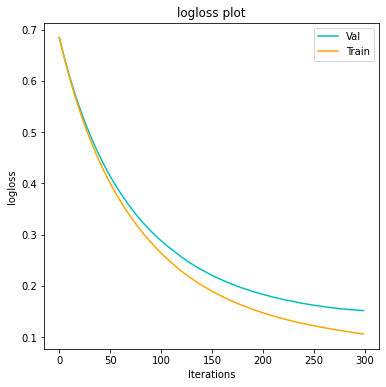

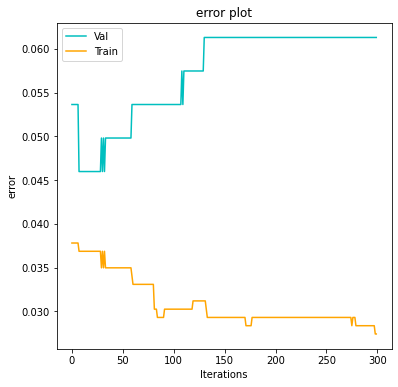

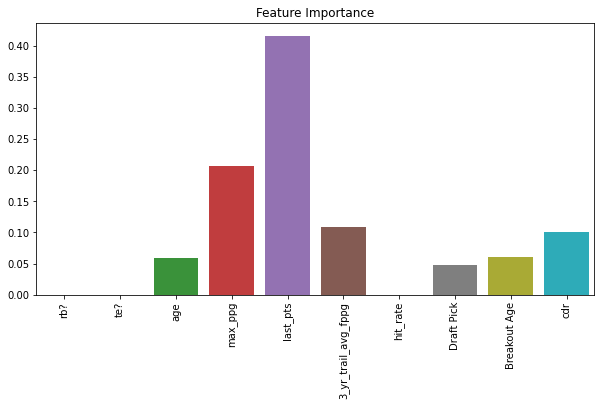

In [73]:
fitXgb(xgb2, training_data)

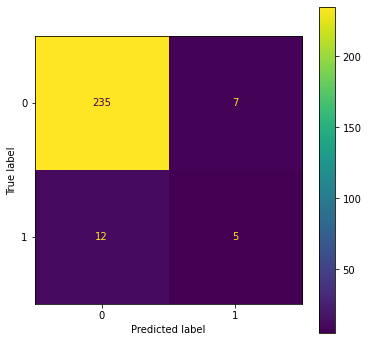

In [74]:
plot_confusion_matrix(xgb2,X_test,
                     Y_test,
                     values_format='d')

## Score 2022

In [75]:
df_2022_X

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8,A.J. Dillon,2022.0
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0,Aaron Jones,2022.0
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9,Aaron Ripkowski,2022.0
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7,Adrian Peterson,2022.0
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3,Ahmad Bradshaw,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green,NaN
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt,NaN
147,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano,NaN
148,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride,NaN


In [78]:
j_scores_2022 = pd.DataFrame(xgb2.predict_proba(df_2022_X.drop(columns=['id']))).set_index(df_2022_X_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2022

,0,1
id,,
Cooper Kupp,0.258675,0.741325
Austin Ekeler,0.261074,0.738926
Davante Adams,0.262292,0.737708
Tyreek Hill,0.278320,0.721680
Alvin Kamara,0.278320,0.721680
...,...,...
Derrick Willies,0.811502,0.188498
Derek Hagan,0.811502,0.188498
Deonte Thompson,0.811502,0.188498


In [88]:
j_scores_2022.to_csv('j_scores_v6.csv')

In [157]:
rb_adp = pd.read_csv('rb_adp.csv')
wr_adp = pd.read_csv('wr_adp.csv')
te_adp = pd.read_csv('te_adp.csv')

adp_df = rb_adp.append(wr_adp.append(te_adp))
adp_df

,Full Name,Position,ADP
0,A.J. Dillon,RB,72.1
1,Aaron Green,RB,-
2,Aaron Jones,RB,19.7
3,Aaron Ripkowski,RB,-
4,Abram Smith,RB,215.8
...,...,...,...
499,Zach Ertz,TE,109.8
500,Zach Gentry,TE,216
501,Zach Miller,TE,-
502,Zach Miller,TE,-


In [80]:
winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df_3.0.csv')

In [81]:
df_2022_id.to_csv('df_2022_id.csv')

## Backtest

### 2018

In [80]:
test_2018

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,23.5,8.0,8.0,8.000000,0.000000,5.39,18.8,47.0
3,0,1,0,33.2,16.3,7.9,9.066667,0.333333,1.07,19.5,42.7
7,0,1,0,24.0,0.0,0.0,0.000000,0.000000,6.08,NaN,3.2
8,0,1,0,23.8,11.4,11.4,7.700000,0.000000,5.34,19.0,29.9
11,0,1,0,27.1,8.0,5.6,6.000000,0.000000,6.05,21.4,14.4
...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,1,34.3,7.6,7.6,7.066667,0.000000,1.06,21.6,35.9
1247,0,0,1,29.8,5.2,3.6,4.000000,0.000000,7.01,21.1,19.5
1248,0,0,1,21.9,NaN,NaN,NaN,NaN,4.20,NaN,10.3
1250,0,0,1,25.7,4.3,2.4,3.350000,0.000000,NaN,NaN,13.1


In [86]:
j_scores_2018 = pd.DataFrame(xgb2.predict_proba(test_2018.drop(columns=['y']))).set_index(test_2018_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2018 = j_scores_2018.reset_index().merge(fp_2018[['Full Name','Fantasy Points Per Game (2018)']],
                                                  left_on='id',
                                                  right_on='Full Name',
                                                  how='left')
j_scores_2018.head(20)

,id,0,1,Full Name,Fantasy Points Per Game (2018)
0,Alvin Kamara,0.243529,0.756471,Alvin Kamara,23.2
1,Antonio Brown,0.258675,0.741325,Antonio Brown,21.6
2,Kareem Hunt,0.304869,0.695131,Kareem Hunt,20.9
3,Ezekiel Elliott,0.323710,0.676290,Ezekiel Elliott,21.8
4,DeAndre Hopkins,0.342879,0.657121,DeAndre Hopkins,20.8
5,Todd Gurley,0.358261,0.641739,Todd Gurley,26.2
6,Devonta Freeman,0.359644,0.640356,Devonta Freeman,7.0
7,Tyreek Hill,0.368480,0.631520,Tyreek Hill,20.5
8,Rob Gronkowski,0.386400,0.613600,Rob Gronkowski,10.1
9,LeSean McCoy,0.407066,0.592934,LeSean McCoy,9.1


In [87]:
j_scores_2017 = pd.DataFrame(xgb2.predict_proba(test_2017.drop(columns=['y']))).set_index(test_2017_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2017 = j_scores_2017.reset_index().merge(fp_2017[['Full Name','Fantasy Points Per Game (2017)']],
                                                  left_on='id',
                                                  right_on='Full Name',
                                                  how='left')
j_scores_2017.head(20)

,id,0,1,Full Name,Fantasy Points Per Game (2017)
0,David Johnson,0.255427,0.744573,David Johnson,13.0
1,Antonio Brown,0.258675,0.741325,Antonio Brown,22.0
2,DeMarco Murray,0.278320,0.721680,DeMarco Murray,11.4
3,LeSean McCoy,0.306362,0.693638,LeSean McCoy,16.5
4,Le'Veon Bell,0.310438,0.689562,Le'Veon Bell,22.8
5,Devonta Freeman,0.315479,0.684521,Devonta Freeman,14.3
6,Ezekiel Elliott,0.323710,0.676290,Ezekiel Elliott,20.3
7,Melvin Gordon,0.351827,0.648173,Melvin Gordon,18.0
8,Doug Baldwin,0.410782,0.589218,Doug Baldwin,13.8
9,Jordan Howard,0.411674,0.588326,Jordan Howard,12.5
